In [2]:
import pandas as pd
import numpy as np
import tifffile
import dask.array as da
from dask.array.image import imread
import os
import seaborn as sns
import matplotlib.pyplot as plt
#from scipy.ndimage import binaay_dilation
import copy
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

In [3]:
os.getcwd()

'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/mi_spatialomics/analysis/seqIF_python'

In [20]:
# lazily load ../spatial_comp_setup_regions/test_data_for_expansion/test_data.tif using dask

# load the data
#data = imread('../../../spatial_comp_setup_regions/test_data_for_expansion/test_data.tif').rechunk((1,1, 1024, 1024))
#data = imread('/Volumes/Luna_heart/background_subtracted/24h_83/20221212_121039_2_62P4E2_FW_KB_FS_SeqIF_final_medium_MI_d1_backsub.ome.tif').rechunk((1,1, 1024, 1024))
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels.csv')


In [20]:
cells = cell_data[cell_data['fov'] == '24h_83']
quantification_table = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/24h_83_quantification.csv')
# merge cells with quantification table by "label" (in cells) and "CellID" (in quantification_table)
merged = pd.merge(cells, quantification_table, left_on='label', right_on='CellID')
# exclude all columns after WGA_250_TRITC (not inlusice)
merged = merged.loc[:, :'WGA_250_TRITC']
x_positions = merged['X_centroid_x'].astype(int)
y_positions = merged['Y_centroid_x'].astype(int)

In [46]:
mask = tifffile.imread('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/spatial_comp_setup_regions/heart_data/export_masks/24h_83_region_labels.tif')
CM_mask = tifffile.imread('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/spatial_comp_setup_regions/heart_data/export_masks/24h_83_CM_labels.tif')
endocardial_layer_mask = tifffile.imread('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/spatial_comp_setup_regions/heart_data/export_masks/24h_83_endocardial_layer_labels.tif')

In extra_mask, the labels are binary - 1 for infarcted, 0 for not

In mask, the labels are as follows:

    Lumen - 1 -- source label
    Endocardium - 2 -- target label 1
    remote_endocardium - 3 -- target label 2
    Background - 4
    border_zone - 5
    papillary_muscle - 6
    Epicardium - 7
    Ignore - 8
    Myocardium - 9 (in controls)

In CM_mask, the labels are as follows

    remote_infarct - 1
    infarct_core - 2

In endocardial_layer_mask, the labels are as follows:

    subMI_endocardiallayer - 1
    Endocardial_layer - 2

In [164]:
merged['region_label'] = mask[y_positions, x_positions]
merged['CM_label'] = CM_mask[y_positions, x_positions]
merged['endocardial_label'] = endocardial_layer_mask[y_positions, x_positions]

label_mapping_regions = {
    0: 'other_tissue',
    1: 'lumen',
    2: 'endocardium',
    3: 'remote_endocardium',
    4: 'background',
    5: 'border_zone',
    6: 'papillary_muscle',
    7: 'epicardium',
    9: 'ignore'
}
merged['region_value'] = merged['region_label'].map(label_mapping_regions)

label_mapping_CM = {
    0: 'other_tissue',
    1: 'remote_infarct',
    2: 'infarct_core'
}
merged['CM_value'] = merged['CM_label'].map(label_mapping_CM)
merged['injured'] = merged['CM_label']>0
merged.loc[merged['CM_value'] == 'infarct_core', 'region_value'] = 'infarct_core'

label_mapping_endo = {
    0: 'other_tissue',
    1: 'sub_MI_endocardial_layer',
    2: 'endocardial_layer'
}
merged['endocardial_value'] = merged['endocardial_label'].map(label_mapping_CM)

merged.loc[(merged['cell_meta_cluster'] == 'Endothelial cells') & (merged['endocardial_label']>0), 'cell_meta_cluster'] = 'Endocardial cells'
merged['endothelial_status'] = np.logical_or(merged['cell_meta_cluster'] == 'Endothelial cells', merged['cell_meta_cluster'] == 'Endocardial cells')

merged.loc[(merged['cell_meta_cluster'] == 'Endocardial cells') & (merged['region_value']=="endocardium"), 'ICAM1_300_Cy5'].values

Text(0.5, 1.0, 'Endocardial cells vs other endothelial cells - "endocardial region"')

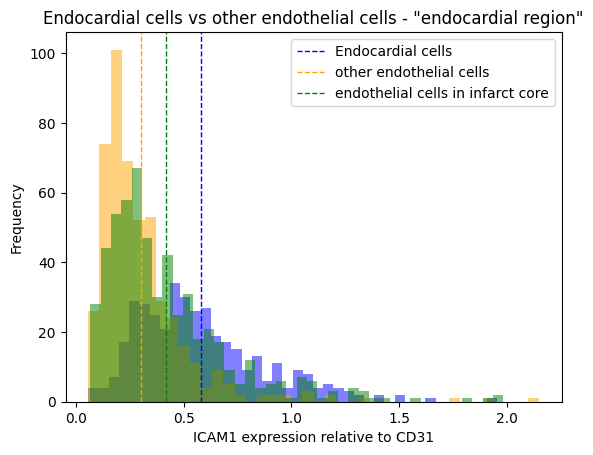

In [142]:
endoc_list = merged.loc[(merged['cell_meta_cluster'] == 'Endocardial cells') & (merged['region_value']=="endocardium"), 'ICAM1_300_Cy5'].values
endot_list = merged.loc[(merged['cell_meta_cluster'] == 'Endothelial cells') & (merged['region_value']=="endocardium"), 'ICAM1_300_Cy5'].values
endoc2_list = merged.loc[(merged['cell_meta_cluster'] == 'Endocardial cells') & (merged['region_value']=="endocardium"), 'CD31_250_Cy5'].values
endot2_list = merged.loc[(merged['cell_meta_cluster'] == 'Endothelial cells') & (merged['region_value']=="endocardium"), 'CD31_250_Cy5'].values
endothelial_infarct_list = merged.loc[(merged['cell_meta_cluster'] == 'Endothelial cells') & (merged['region_value']=="infarct_core"), 'ICAM1_300_Cy5'].values
endothelial_infarct_list2 = merged.loc[(merged['cell_meta_cluster'] == 'Endothelial cells') & (merged['region_value']=="infarct_core"), 'CD31_250_Cy5'].values
endoc = [a / b for a, b in zip(endoc_list, endoc2_list)]
endot = [a / b for a, b in zip(endot_list, endot2_list)]
endothelial_infarct = [a / b for a, b in zip(endothelial_infarct_list, endothelial_infarct_list2)]
# plot histograms of endoc and endot so that the area under the curve is 1

num_bins = 40
alpha = 0.5
plt.hist(endoc, bins=num_bins, alpha=alpha, color='blue')
plt.hist(endot, bins=num_bins, alpha=alpha, color='orange')
plt.hist(endothelial_infarct, bins=num_bins, alpha=alpha, color='green')
plt.xlabel('ICAM1 expression relative to CD31')
plt.ylabel('Frequency')

# plot the means as vertical lines
plt.axvline(np.mean(endoc), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(endot), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(endothelial_infarct), color='green', linestyle='dashed', linewidth=1)

# add legend
plt.legend(['Endocardial cells', 'other endothelial cells', 'endothelial cells in infarct core'])
# title ICAM1 expression in endocardial cells vs other endothelial cells
plt.title('Endocardial cells vs other endothelial cells - "endocardial region"')

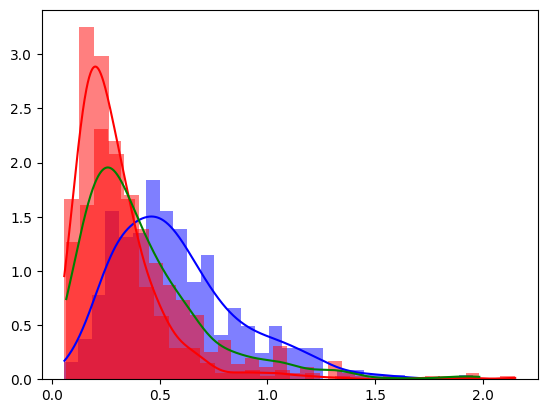

In [153]:
from scipy.stats import gaussian_kde
plt.hist(endoc, bins=30, density=True, alpha=0.5, color='blue', label='600 points')
x_vals = np.linspace(min(endoc), max(endoc), 1000)
kde1 = gaussian_kde(endoc)
plt.plot(x_vals, kde1(x_vals), color='blue')

plt.hist(endot, bins=30, density=True, alpha=0.5, color='red', label='100 points')
kde2 = gaussian_kde(endot)
x_vals = np.linspace(min(endot), max(endot), 1000)
plt.plot(x_vals, kde2(x_vals), color='red')

plt.hist(endothelial_infarct, bins=30, density=True, alpha=0.5, color='red', label='100 points')
kde3 = gaussian_kde(endothelial_infarct)
x_vals = np.linspace(min(endothelial_infarct), max(endothelial_infarct), 1000)
plt.plot(x_vals, kde3(x_vals), color='green')


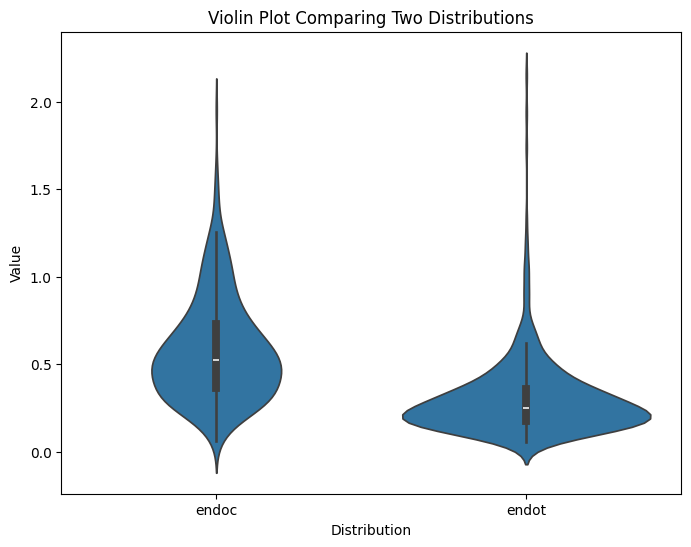

In [154]:

import seaborn as sns
data = pd.DataFrame({
    'Value': np.concatenate([endoc, endot]),
    'Distribution': ['endoc'] * len(endoc) + ['endot'] * len(endot)
})

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Distribution', y='Value', data=data)

# Add labels and title
plt.xlabel('Distribution')
plt.ylabel('Value')
plt.title('Violin Plot Comparing Two Distributions')
plt.show()

Text(0.5, 1.0, 'Endocardial cells vs other endothelial cells - "endocardial region"')

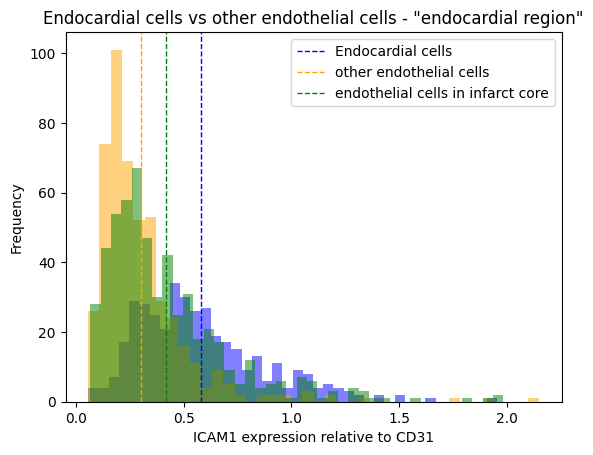

In [143]:
from scipy.stats import gaussian_kde
kde1 = gaussian_kde(endoc)
kde2 = gaussian_kde(endot)
kde3 = gaussian_kde(endothelial_infarct)
num_bins = 40
alpha = 0.5
x_vals = np.linspace(min(endoc), max(endoc), 1000)

plt.hist(endoc, bins=num_bins, alpha=alpha, color='blue')
plt.hist(endot, bins=num_bins, alpha=alpha, color='orange')
plt.hist(endothelial_infarct, bins=num_bins, alpha=alpha, color='green')
plt.xlabel('ICAM1 expression relative to CD31')
plt.ylabel('Frequency')

# plot the means as vertical lines
plt.axvline(np.mean(endoc), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(endot), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(endothelial_infarct), color='green', linestyle='dashed', linewidth=1)

# add legend
plt.legend(['Endocardial cells', 'other endothelial cells', 'endothelial cells in infarct core'])
# title ICAM1 expression in endocardial cells vs other endothelial cells
plt.title('Endocardial cells vs other endothelial cells - "endocardial region"')

Text(0.5, 1.0, 'ICAM1 expression relative to CD31 in endocardial cells vs in other endothelial cells - remote_endocardium')

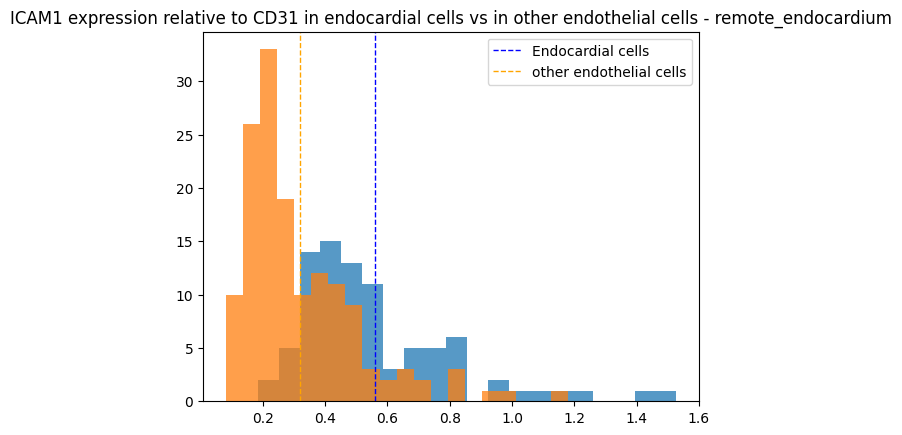

In [131]:
endoc_list = merged.loc[(merged['cell_meta_cluster'] == 'Endocardial cells') & (merged['region_value']=="remote_endocardium"), 'ICAM1_300_Cy5'].values
endot_list = merged.loc[(merged['cell_meta_cluster'] == 'Endothelial cells') & (merged['region_value']=="remote_endocardium"), 'ICAM1_300_Cy5'].values
endoc2_list = merged.loc[(merged['cell_meta_cluster'] == 'Endocardial cells') & (merged['region_value']=="remote_endocardium"), 'CD31_250_Cy5'].values
endot2_list = merged.loc[(merged['cell_meta_cluster'] == 'Endothelial cells') & (merged['region_value']=="remote_endocardium"), 'CD31_250_Cy5'].values
endoc = [a / b for a, b in zip(endoc_list, endoc2_list)]
endot = [a / b for a, b in zip(endot_list, endot2_list)]
plt.hist(endoc, bins=20, alpha=0.75)
plt.hist(endot, bins=20, alpha=0.75)

# plot the means as vertical lines
plt.axvline(np.mean(endoc), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(endot), color='orange', linestyle='dashed', linewidth=1)

# add legend
plt.legend(['Endocardial cells', 'other endothelial cells'])
# title ICAM1 expression in endocardial cells vs other endothelial cells
plt.title('ICAM1 expression relative to CD31 in endocardial cells vs in other endothelial cells - remote_endocardium')

In [224]:
pixel_size = 0.23 # in lunaphore images, this is 0.23 um/pixel
source_label = 1
target_label = 2
target_label2 = 3
extra_mask_label = 1
iteration_width_pixels = 4
iteration_width_um = iteration_width_pixels*pixel_size
max_iterations = 20
number_of_channels = 2#data.shape[1] # C dimension

channel_list = [2, 5, 7]
channel_names = ['CD68', 'CD31', 'CCR2']
result_endocardium = pd.DataFrame(columns=['area'] + ['area_um'] + ['stressed_percentage'] + ['distance_start'] + ['distance_stop'] + [f'channel_{i}_mean' for i in channel_names])

In [229]:
source_mask = mask == source_label
target_mask = mask == target_label
stressed_mask = CM_mask == extra_mask_label
result_mask = np.zeros_like(mask)
iteration_width_pixels = 80
iteration_width_um = iteration_width_pixels*pixel_size
max_iterations = 10

for iteration in range(max_iterations):
    dilated_source_mask = binary_dilation(source_mask, iterations=iteration_width_pixels)
    overlap_mask = np.bitwise_and(dilated_source_mask, target_mask)
    if overlap_mask.sum() == 0:
        break
    source_mask = dilated_source_mask
    target_mask = np.bitwise_and(target_mask, np.bitwise_not(overlap_mask))
    result_mask = result_mask + (1+iteration)*overlap_mask

In [268]:
source_mask = mask == source_label
end_mask = np.zeros_like(mask)
iteration_width_pixels = 80
iteration_width_um = iteration_width_pixels*pixel_size
max_iterations = 40

for iteration in range(max_iterations):
    dilated_source_mask = binary_dilation(source_mask, iterations=iteration_width_pixels)
    overlap_mask = np.bitwise_and(dilated_source_mask, np.bitwise_not(source_mask))
    if overlap_mask.sum() == 0:
        break
    source_mask = dilated_source_mask
    end_mask = end_mask + (1+iteration)*overlap_mask
end_mask = end_mask.astype(np.uint8)
tifffile.imwrite('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/lumen_layers_expanded.tif', end_mask)

In [271]:
merged['lumen_bins'] = end_mask[y_positions, x_positions]

In [274]:
merged['cell_meta_cluster'].value_counts()

cell_meta_cluster
Cardiomyocytes            23638
Cardiomyocytes Ankrd1+    15304
Endothelial cells          7902
Mono / Macros Ccr2+        5069
Fibroblasts                3934
Neutrophils                2604
Smooth muscle cells         987
Endocardial cells           639
background                  627
Macrophages Trem2+          225
out_of_mask                 194
Other Leukocytes            158
Macrophages Trem2-           82
Name: count, dtype: int64

In [272]:
# save merged
merged.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/merged_ongoing_20240820.csv', index=False)

In [230]:
# save the result mask
result_mask = result_mask.astype(np.uint8)
tifffile.imwrite('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/endo_layers.tif', result_mask)


In [231]:
merged['endo_layer'] = result_mask[y_positions, x_positions]

plot_df = pd.DataFrame(columns = ['ratio', 'layer'])
for layer in range(1, max(merged.endo_layer)+1):
    ICAM1_list = merged.loc[merged['endothelial_status'] & (merged['endo_layer']==layer), 'ICAM1_300_Cy5'].values
    CD31_list = merged.loc[merged['endothelial_status'] & (merged['endo_layer']==layer), 'CD31_250_Cy5'].values
    ratio = [a / b for a, b in zip(ICAM1_list, CD31_list)]
    mean_ratio = np.mean(ratio)
    #plot_df.loc[layer-1] = [ratio, layer]
    for r in ratio:
        plot_df.loc[len(plot_df)] = [r, layer]

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_40796/163936458.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='layer', y='ratio', data=plot_df, palette="Set2", cut=0)


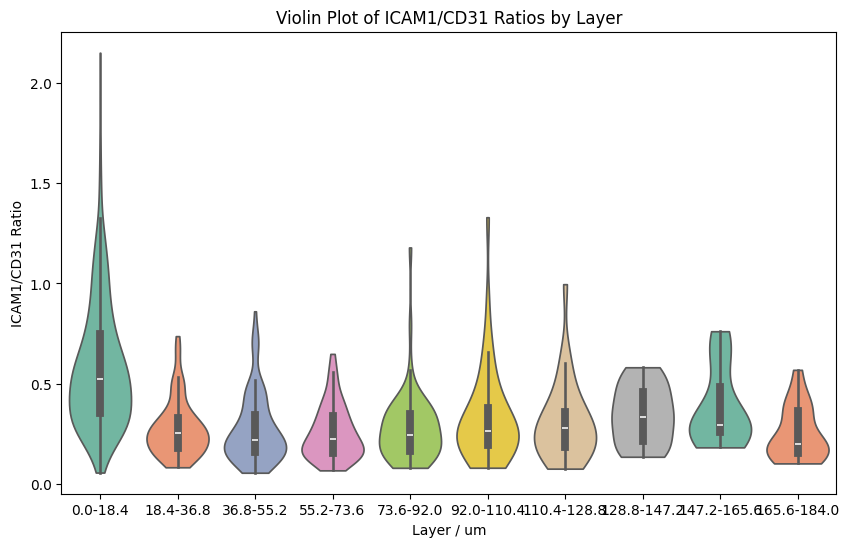

In [235]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='layer', y='ratio', data=plot_df, palette="Set2", cut=0)
plt.xlabel('Layer / um')
plt.ylabel('ICAM1/CD31 Ratio')
plt.title('Violin Plot of ICAM1/CD31 Ratios by Layer')
plt.xticks(ticks=range(0, max(merged.endo_layer)), labels=[f'{np.round(i*iteration_width_um,1)}-{np.round((i+1)*iteration_width_um, 1)}' for i in range(0, max(merged.endo_layer))]) 
plt.show()

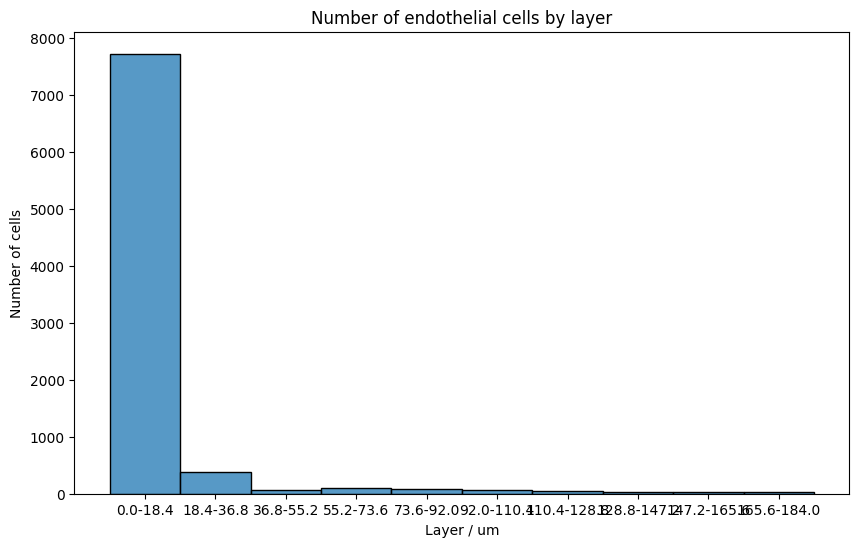

In [267]:
plt.figure(figsize=(10, 6))
plt.xlabel('Layer / um')
plt.ylabel('Number of cells')
plt.title('Number of endothelial cells by layer')
sns.histplot(x='endo_layer', data=merged[merged['endothelial_status']], bins=max(merged.endo_layer), kde=False)
plt.xticks(ticks=range(0, max(merged.endo_layer)), labels=[f'{np.round(i*iteration_width_um,1)}-{np.round((i+1)*iteration_width_um, 1)}' for i in range(0, max(merged.endo_layer))]) 
#plt.xticks(fontsize=6)
plt.xticks(ticks=np.arange(0, max(merged.endo_layer), 1)+0.5, labels=[f'{np.round(i*iteration_width_um,1)}-{np.round((i+1)*iteration_width_um, 1)}' for i in range(0, max(merged.endo_layer))])
plt.show()

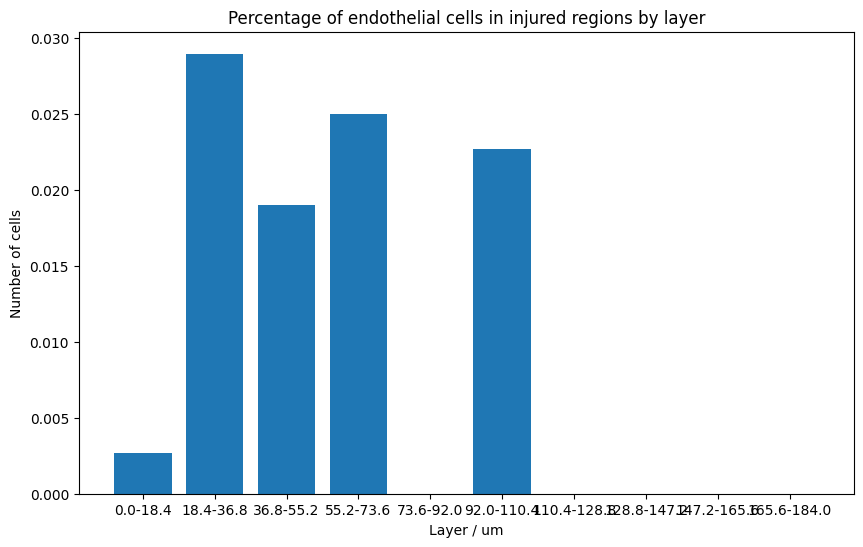

In [266]:
# for each layer, calculate the percentage of cells that are injured
injury_list = []
for layer in range(1, max(merged.endo_layer)+1):
    injured = merged.loc[(merged['endothelial_status']) & (merged['endo_layer'] == layer), 'injured'].sum()
    total = merged.loc[(merged['endothelial_status']) & (merged['endo_layer'] == layer), 'injured'].count()
    injury_list.append(injured/total)
plt.figure(figsize=(10, 6))
plt.xlabel('Layer / um')
plt.ylabel('Number of cells')
plt.title('Percentage of endothelial cells in injured regions by layer')

plt.bar(range(0, max(merged.endo_layer)), injury_list)
plt.xticks(ticks=range(0, max(merged.endo_layer)), labels=[f'{np.round(i*iteration_width_um,1)}-{np.round((i+1)*iteration_width_um, 1)}' for i in range(0, max(merged.endo_layer))])
plt.show()

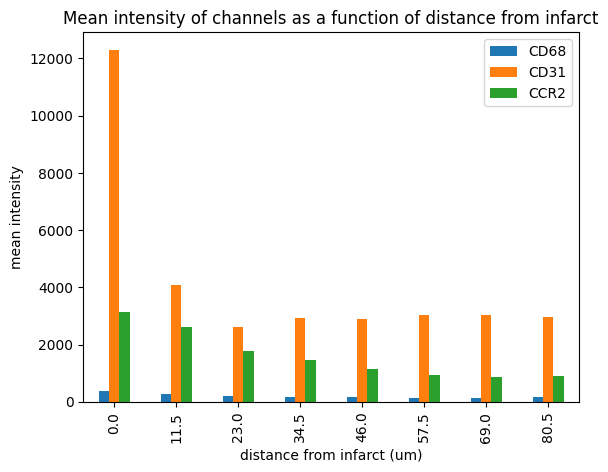

In [144]:
# plot channel_CD68_mean, channel_CD31_mean, channel_CCR2_mean as a function of distance_start and add a legend, should be barplot
import matplotlib.pyplot as plt

result_endocardium.plot(x='distance_start', y=['channel_CD68_mean', 'channel_CD31_mean', 'channel_CCR2_mean'], kind='bar')
plt.legend(channel_names)
plt.xlabel('distance from infarct (um)')
plt.ylabel('mean intensity')
plt.title('Mean intensity of channels as a function of distance from infarct')
plt.show()


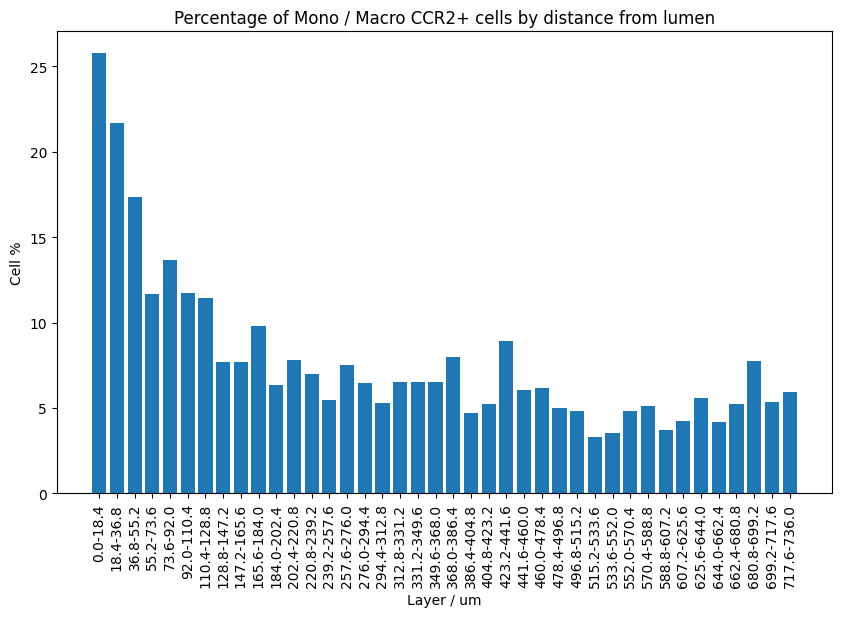

In [315]:
plot_info_ccr2 = merged.loc[merged['cell_meta_cluster'] == 'Mono / Macros Ccr2+'].lumen_bins.value_counts().sort_index()
all_info = merged.lumen_bins.value_counts().sort_index()
plot_info_ccr2_ratio = plot_info_ccr2/all_info * 100
plt.figure(figsize=(10, 6))
plt.xlabel('Layer / um')
plt.ylabel('Cell %')
plt.title('Percentage of Mono / Macro CCR2+ cells by distance from lumen')

plt.bar(range(0, max(merged.lumen_bins)), plot_info_ccr2_ratio[1:])
plt.xticks(ticks=range(0, max(merged.lumen_bins)), labels=[f'{np.round(i*iteration_width_um,1)}-{np.round((i+1)*iteration_width_um, 1)}' for i in range(0, max(merged.lumen_bins))])
# rotate xticks
plt.xticks(rotation=90)
plt.show()

In [1]:
plot_info_ccr2 = merged.loc[merged['cell_meta_cluster'] == 'Neutrophils'].lumen_bins.value_counts().sort_index()
all_info = merged.lumen_bins.value_counts().sort_index()
plot_info_ccr2_ratio = plot_info_ccr2/all_info * 100
plt.figure(figsize=(10, 6))
plt.xlabel('Layer / um')
plt.ylabel('Cell %')
plt.title('Percentage of Neutrophils by distance from lumen')

plt.bar(range(0, max(merged.lumen_bins)), plot_info_ccr2_ratio[1:])
plt.xticks(ticks=range(0, max(merged.lumen_bins)), labels=[f'{np.round(i*iteration_width_um,1)}-{np.round((i+1)*iteration_width_um, 1)}' for i in range(0, max(merged.lumen_bins))])
# rotate xticks
plt.xticks(rotation=90)
plt.show()

NameError: name 'merged' is not defined

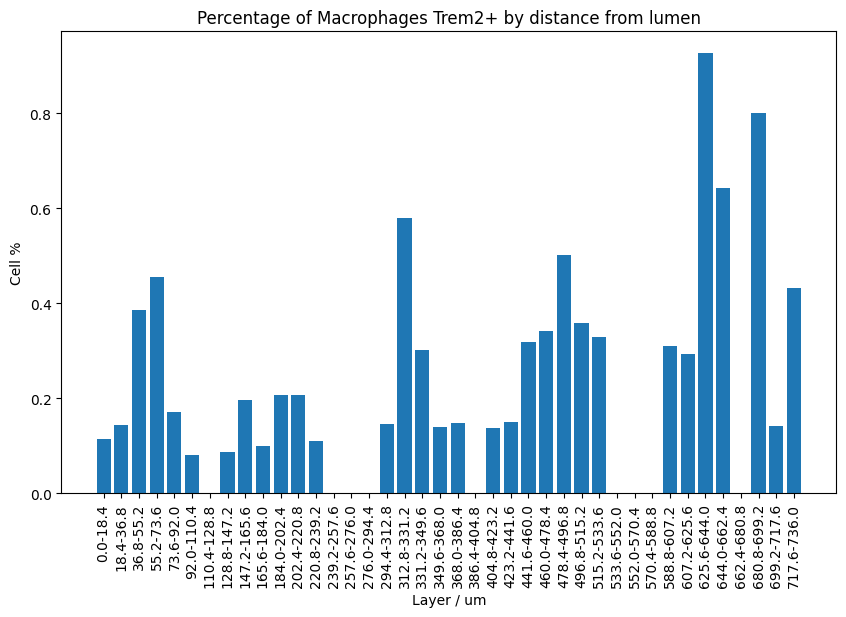

In [318]:
plot_info_ccr2 = merged.loc[merged['cell_meta_cluster'] == 'Macrophages Trem2+'].lumen_bins.value_counts().sort_index()
all_info = merged.lumen_bins.value_counts().sort_index()
plot_info_ccr2_ratio = plot_info_ccr2/all_info * 100
plt.figure(figsize=(10, 6))
plt.xlabel('Layer / um')
plt.ylabel('Cell %')
plt.title('Percentage of Macrophages Trem2+ by distance from lumen')

plt.bar(range(0, max(merged.lumen_bins)), plot_info_ccr2_ratio[1:])
plt.xticks(ticks=range(0, max(merged.lumen_bins)), labels=[f'{np.round(i*iteration_width_um,1)}-{np.round((i+1)*iteration_width_um, 1)}' for i in range(0, max(merged.lumen_bins))])
# rotate xticks
plt.xticks(rotation=90)
plt.show()

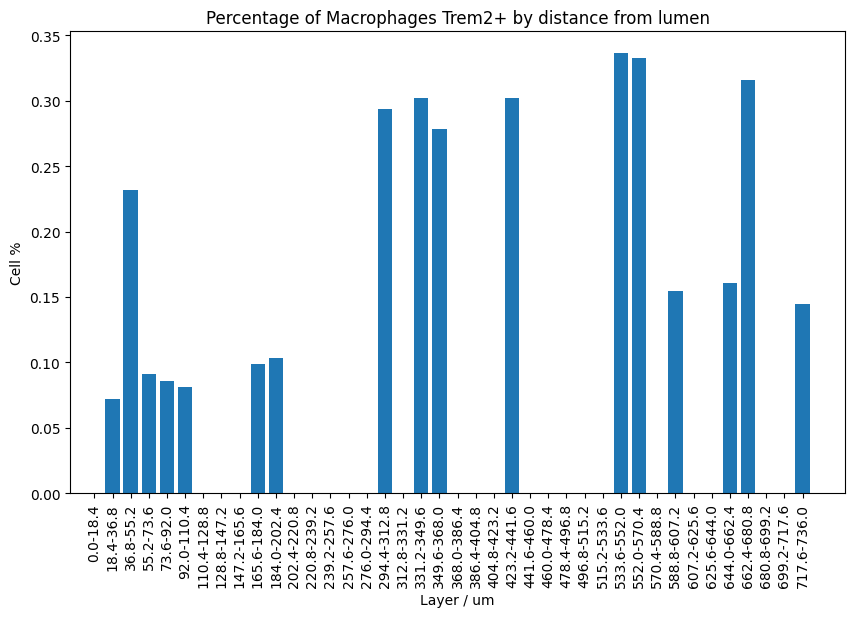

In [319]:
plot_info_ccr2 = merged.loc[merged['cell_meta_cluster'] == 'Macrophages Trem2-'].lumen_bins.value_counts().sort_index()
all_info = merged.lumen_bins.value_counts().sort_index()
plot_info_ccr2_ratio = plot_info_ccr2/all_info * 100
plt.figure(figsize=(10, 6))
plt.xlabel('Layer / um')
plt.ylabel('Cell %')
plt.title('Percentage of Macrophages Trem2- by distance from lumen')

plt.bar(range(0, max(merged.lumen_bins)), plot_info_ccr2_ratio[1:])
plt.xticks(ticks=range(0, max(merged.lumen_bins)), labels=[f'{np.round(i*iteration_width_um,1)}-{np.round((i+1)*iteration_width_um, 1)}' for i in range(0, max(merged.lumen_bins))])
# rotate xticks
plt.xticks(rotation=90)
plt.show()

In [16]:
# load pixel map
pixel_map = tifffile.imread('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/sample_1d.r1.pixel_mask.tiff')
merged = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/merged_ongoing_20240820.csv')
layers = tifffile.imread('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/lumen_layers_expanded.tif')
population_pixel_mask = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/population_pixel_mask.csv')

In [55]:
import copy
binary_target_mask = np.logical_or(mask == 2, CM_mask == 2)
layers_endo_infarct = copy.copy(layers)
layers_endo_infarct[~binary_target_mask] = 0

In [56]:
# prepare a dataframe, each row will be a layer, each column will be a region_id
layer_df = pd.DataFrame(columns=population_pixel_mask.region_id.unique())
unique_values_in_layers = np.unique(layers)
unique_values_in_pixel_map = np.unique(pixel_map)
for layer in unique_values_in_layers:
    layer_df.loc[layer] = 0.0

In [82]:
stressed_percentage_layers = []
stressed_mask = CM_mask > 0
for layer in unique_values_in_layers:
    layer_mask = layers_endo_infarct == layer
    stressed_layer_mask = np.logical_and(layer_mask, stressed_mask)
    stressed_percentage_layers.append(stressed_layer_mask.sum()/layer_mask.sum())
layer_df['stressed_percentage'] = stressed_percentage_layers

In [84]:
layer_df

region_name   Ankrd1+      Mpo+     aSMA+   Pdgfra+     Cd45+     Ccr2+  \
0            0.017907  0.004699  0.002545  0.010856  0.000307  0.005453   
1            0.025336  0.111024  0.000145  0.047959  0.001825  0.140403   
2            0.060638  0.032982  0.000092  0.036175  0.002291  0.116544   
3            0.076857  0.033636  0.000373  0.033435  0.002982  0.072446   
4            0.136370  0.048749  0.000274  0.034657  0.002907  0.036599   
5            0.292052  0.059808  0.000898  0.029344  0.002876  0.042615   
6            0.465675  0.073554  0.002426  0.025163  0.004703  0.041347   
7            0.558562  0.076895  0.002752  0.026583  0.003131  0.033216   
8            0.591295  0.061208  0.005710  0.032455  0.003247  0.027004   
9            0.597182  0.071934  0.002851  0.035281  0.003346  0.025051   
10           0.607056  0.059385  0.001688  0.039311  0.003738  0.024336   
11           0.608945  0.067335  0.002919  0.036576  0.005744  0.022269   
12           0.622547  0.065387  0.003548  0.042347  0.003953  0.022218   
13           0.639131  0.055317  0.008039  0.040741  0.004599  0.019747   
14           0.658060  0.052569  0.007421  0.035916  0.004033  0.014032   
15           0.672010  0.050102  0.008006  0.036548  0.003858  0.016780   
16           0.664922  0.064618  0.006671  0.035602  0.004818  0.013150   
17           0.706949  0.061435  0.004237  0.032905  0.004435  0.008766   
18           0.703677  0.056540  0.004496  0.030779  0.004337  0.007932   
19           0.698332  0.046067  0.005122  0.033419  0.006223  0.012092   
20           0.694049  0.039290  0.009164  0.043801  0.005587  0.012314   
21           0.683760  0.048170  0.010145  0.046355  0.003460  0.015932   
22           0.700945  0.047210  0.009655  0.031131  0.005097  0.011640   
23           0.702627  0.037820  0.017355  0.031403  0.003232  0.011518   
24           0.675334  0.041512  0.017941  0.036913  0.004432  0.017318   
25           0.673586  0.049394  0.012318  0.039717  0.004384  0.015264   
26           0.707462  0.045064  0.007653  0.028111  0.004132  0.011107   
27           0.693738  0.043688  0.004437  0.040763  0.002796  0.014470   
28           0.691431  0.049058  0.008240  0.029437  0.003277  0.014066   
29           0.711882  0.035789  0.013422  0.032777  0.002784  0.013647   
30           0.717197  0.036892  0.011589  0.028939  0.001695  0.011317   
31           0.715538  0.052426  0.003785  0.028562  0.004105  0.012356   
32           0.726409  0.047979  0.002831  0.022227  0.002066  0.011413   
33           0.705119  0.056647  0.004953  0.023244  0.003153  0.016914   
34           0.718025  0.065844  0.002836  0.021704  0.002424  0.015168   
35           0.724137  0.063756  0.004718  0.015401  0.002635  0.013844   
36           0.746109  0.057266  0.005356  0.016156  0.003542  0.013716   
37           0.706763  0.069346  0.007788  0.021213  0.001787  0.012739   
38           0.693328  0.071776  0.015403  0.016041  0.003997  0.016014   
39           0.697620  0.071622  0.013114  0.009607  0.002742  0.014966   
40           0.686840  0.062306  0.018366  0.014919  0.003505  0.016539   

region_name    Trem2+     Cd31+    Tnnt2+     Cd68+  background        31  \
0            0.000220  0.024163  0.162375  0.000727    0.005004  0.000735   
1            0.001056  0.271114  0.291358  0.001052    0.004267  0.084248   
2            0.000145  0.046410  0.686293  0.000555    0.008484  0.009392   
3            0.000469  0.074631  0.687827  0.001993    0.010791  0.004560   
4            0.000408  0.081103  0.632404  0.001890    0.021791  0.002848   
5            0.000248  0.072966  0.472648  0.001701    0.020221  0.004623   
6            0.000130  0.072499  0.287638  0.000924    0.021486  0.004454   
7            0.000213  0.061860  0.214288  0.000755    0.016856  0.004889   
8            0.000110  0.064972  0.191446  0.001031    0.018452  0.003069   
9            0.000566  0.057817  0.184648  0.001343    0.016740  0.003241   
10

In [59]:
def calculate_pixel_percentage(layer, layers_input):
    layer_mask = layers_input == layer
    out_list = []
    for region_id in population_pixel_mask.region_id.unique():
        region_mask = pixel_map == region_id
        out_list.append(np.sum(np.logical_and(layer_mask, region_mask))/np.sum(layer_mask))
    return out_list

In [60]:
# fill layer_df with values
for layer in unique_values_in_layers:
    layer_df.loc[layer, :] = calculate_pixel_percentage(layer, layers_endo_infarct)

In [61]:
import copy
layer_df_copy = copy.copy(layer_df)

In [62]:
layer_df
# rename columns in layer_df based on population_pixel_mask
layer_df.columns = population_pixel_mask.set_index('region_id').region_name

In [42]:
# layer_df_normalized should be a copy of layer_df, normalized by the max of each column
layer_df_normalized = layer_df.div(layer_df.max(axis=0), axis=1)


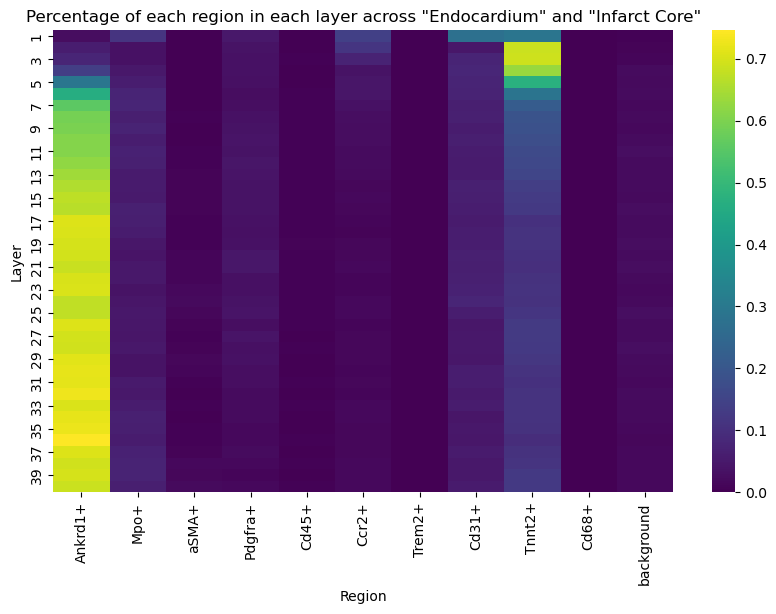

In [66]:
# plot the layer_df as a heatmap excluding row 0
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(layer_df.iloc[1:, :-1], cmap='viridis')
plt.xlabel('Region')
plt.ylabel('Layer')
plt.title('Percentage of each region in each layer across "Endocardium" and "Infarct Core"')
plt.show()


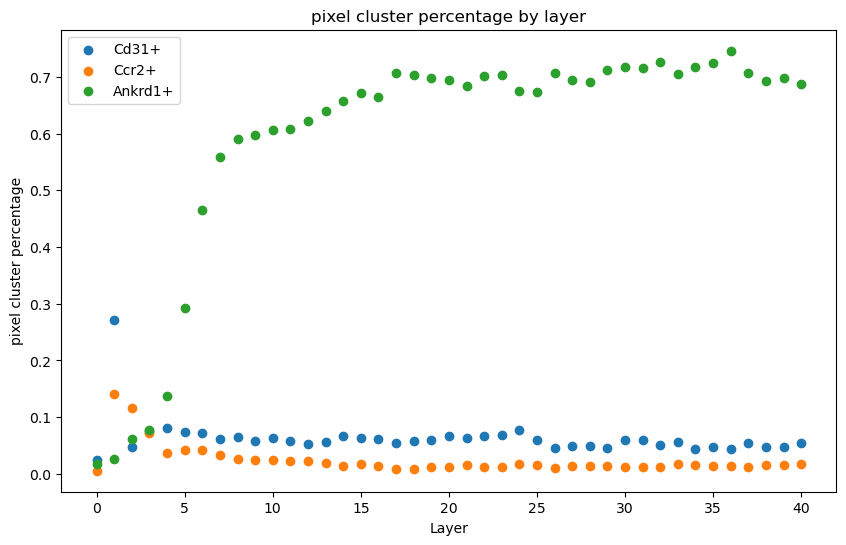

In [6]:
# plot the CD31+ column of layer_df as a scatter plot with layer on the x-axis and CD31+ percentage on the y-axis
plt.figure(figsize=(10, 6))
plt.scatter(layer_df.index, layer_df['Cd31+'])
plt.scatter(layer_df.index, layer_df['Ccr2+'])
#plt.scatter(layer_df.index, layer_df['Mpo+'])
plt.scatter(layer_df.index, layer_df['Ankrd1+'])
plt.xlabel('Layer')
plt.legend(['Cd31+', 'Ccr2+', 'Ankrd1+'])
plt.ylabel('pixel cluster percentage')
plt.title('pixel cluster percentage by layer')
plt.show()

In [90]:
layer_df.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/label_df.csv', index=False)

In [4]:
layer_df = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/label_df.csv')

## Below is the processing needed to recreate the plot above for each image - written as a function:

In [21]:
sample_list = ["Control_12", "Control_13", "Control_14", "4h_96", "4h_97", "24h_83", "24h_86", "48h_76", "48h_79"]

sample_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/sample_name_matching.csv')
sample_list_final = [sample_matching.loc[sample_matching['sample_kb'] == sample, 'sample_final'].values[0] for sample in sample_list]

- in region_mask, Lumen always has value 1; Ignore always has value 8 (such regions are excluded from analysis)
- in endocardial_mask, near-infarct endocardium is 1, remote (and in control) is 2

In [57]:
# add 'Endocardial cells' as cell type
cell_data_refined = copy.copy(cell_data)
cell_data_refined['refined_cell_type'] = cell_data['cell_meta_cluster']
for sample in sample_list:
    sample_final_name = sample_list_final[sample_list.index(sample)]

    endocardial_layer_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_endocardium.tif'

    pixel_size = 0.23 # in lunaphore images, this is 0.23 um/pixel

    # read the region_mask
    endocardial_layer_mask = tifffile.imread(endocardial_layer_path)

    cell_data_subset = cell_data[cell_data['fov'] == sample]
    cell_data_subset['endocardial_layer'] = endocardial_layer_mask[np.rint(cell_data_subset['Y_centroid']).astype(int), np.rint(cell_data_subset['X_centroid']).astype(int)]
    cell_data_subset['endocardial_layer'] = cell_data_subset['endocardial_layer']>0
    cell_data_subset['refined_cell_type'] = cell_data_subset['cell_meta_cluster']
    cell_data_subset.loc[np.logical_and(cell_data_subset['refined_cell_type'] == 'Endothelial cells', cell_data_subset['endocardial_layer']), 'refined_cell_type'] = 'Endocardial cells'

    cell_data_refined.loc[cell_data_refined['fov'] == sample, 'refined_cell_type'] = cell_data_subset['refined_cell_type']  
cell_data_refined.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined.csv', index=False)  

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_92152/1071430060.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['endocardial_layer'] = endocardial_layer_mask[np.rint(cell_data_subset['Y_centroid']).astype(int), np.rint(cell_data_subset['X_centroid']).astype(int)]
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_92152/1071430060.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['endocardial_layer'] = cell_data_subset['endocardial_layer']>0
/var/

In [46]:
for sample in sample_list:
    sample_final_name = sample_list_final[sample_list.index(sample)]

    region_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_regions.tif'

    pixel_size = 0.23 # in lunaphore images, this is 0.23 um/pixel

    # read the region_mask
    region_mask = tifffile.imread(region_mask_path)

    lumen_label = 1
    iteration_width_pixels = 80
    iteration_width_um = iteration_width_pixels*pixel_size
    max_iterations = 20

    lumen_mask = region_mask == lumen_label
    layers_mask = np.zeros_like(lumen_mask)

    for iteration in range(max_iterations):
        dilated_lumen_mask = binary_dilation(lumen_mask, iterations=iteration_width_pixels)
        overlap_mask = np.bitwise_and(dilated_lumen_mask, np.bitwise_not(lumen_mask))
        if overlap_mask.sum() == 0:
            break
        lumen_mask = dilated_lumen_mask
        layers_mask = layers_mask + (1+iteration)*overlap_mask
    layers_mask = layers_mask.astype(np.uint8)

    layers_mask[region_mask == 8] = 0

    tifffile.imwrite(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/lumen_expanded_masks/{sample}_lumen_layers.tif', layers_mask)

In [17]:
for sample in sample_list:
    sample_final_name = sample_list_final[sample_list.index(sample)]

    region_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_regions.tif'

    pixel_size = 0.23 # in lunaphore images, this is 0.23 um/pixel

    # read the region_mask
    region_mask = tifffile.imread(region_mask_path)

    lumen_label = 1
    background_label = 1
    iteration_width_pixels = 80
    iteration_width_um = iteration_width_pixels*pixel_size
    max_iterations = 20

    background_mask = region_mask == background_label
    background_layers_mask = np.zeros_like(background_mask)

    for iteration in range(max_iterations):
        dilated_background_mask = binary_dilation(background_mask, iterations=iteration_width_pixels)
        background_overlap_mask = np.bitwise_and(dilated_background_mask, np.bitwise_not(background_mask))
        if background_overlap_mask.sum() == 0:
            break
        background_mask = dilated_background_mask
        background_layers_mask = background_layers_mask + (1+iteration)*background_overlap_mask
    background_layers_mask = background_layers_mask.astype(np.uint8)

    background_layers_mask[region_mask == 8] = 0

    tifffile.imwrite(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/lumen_expanded_masks/{sample}_background_layers.tif', background_layers_mask)

In [62]:
# add layer information to cell_data_refined
cell_data_refined_layers = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined.csv')
cell_data_refined_layers['lumen_layer'] = 0
cell_data_refined_layers['background_layer'] = 0
cell_data_refined_layers['region'] = 0
cell_data_refined_layers['region_name'] = '0'
for sample in sample_list:
    sample_final_name = sample_list_final[sample_list.index(sample)]
    cell_data_subset = cell_data_refined[cell_data_refined['fov'] == sample]

    lumen_layer_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/lumen_expanded_masks/{sample}_lumen_layers.tif'
    lumen_layers = tifffile.imread(lumen_layer_path)
    cell_data_subset['lumen_layer'] = lumen_layers[np.rint(cell_data_subset['Y_centroid']).astype(int), np.rint(cell_data_subset['X_centroid']).astype(int)]
    cell_data_refined_layers.loc[cell_data_refined['fov'] == sample, 'lumen_layer'] = cell_data_subset['lumen_layer']
    lumen_layers = None

    background_layer_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/lumen_expanded_masks/{sample}_background_layers.tif'
    background_layers = tifffile.imread(background_layer_path)
    cell_data_subset['background_layer'] = background_layers[np.rint(cell_data_subset['Y_centroid']).astype(int), np.rint(cell_data_subset['X_centroid']).astype(int)]
    cell_data_refined_layers.loc[cell_data_refined['fov'] == sample, 'background_layer'] = cell_data_subset['background_layer']
    background_layers = None
    
    region_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_regions.tif'
    region_mask = tifffile.imread(region_mask_path)
    cell_data_subset['region'] = region_mask[np.rint(cell_data_subset['Y_centroid']).astype(int), np.rint(cell_data_subset['X_centroid']).astype(int)]
    # new column region_name - 1 (lumen), 2 (endocardium_near_infarct), 3 (endocardium_remote), 4 (background), 5 (border_zone), 6 (papillary_muscle), 7 (epicardium), 8 (ignore), 9 (myocardium)
    cell_data_subset['region_name'] = cell_data_subset['region'].astype(str)
    cell_data_subset.loc[cell_data_subset['region'] == 1, 'region_name'] = 'lumen'
    cell_data_subset.loc[cell_data_subset['region'] == 2, 'region_name'] = 'endocardium'
    cell_data_subset.loc[cell_data_subset['region'] == 3, 'region_name'] = 'remote_endocardium'
    cell_data_subset.loc[cell_data_subset['region'] == 4, 'region_name'] = 'background'
    cell_data_subset.loc[cell_data_subset['region'] == 5, 'region_name'] = 'border_zone'
    cell_data_subset.loc[cell_data_subset['region'] == 6, 'region_name'] = 'papillary_muscle'
    cell_data_subset.loc[cell_data_subset['region'] == 7, 'region_name'] = 'epicardium'
    cell_data_subset.loc[cell_data_subset['region'] == 8, 'region_name'] = 'ignore'
    cell_data_subset.loc[cell_data_subset['region'] == 9, 'region_name'] = 'border_zone' # controls have no border_zone but for comparison (this is myocardium)

    cell_data_refined_layers.loc[cell_data_refined['fov'] == sample, 'region'] = cell_data_subset['region']
    cell_data_refined_layers.loc[cell_data_refined['fov'] == sample, 'region_name'] = cell_data_subset['region_name']
cell_data_refined_layers.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers.csv', index=False)

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_92152/3500106976.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['lumen_layer'] = lumen_layers[np.rint(cell_data_subset['Y_centroid']).astype(int), np.rint(cell_data_subset['X_centroid']).astype(int)]
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_92152/3500106976.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['background_layer'] = background_layers[np.rint(cell_data_subset['Y_centroid']).asty

### For all monocytes, calculate the distance to the closest endothelial cell and to the closest endocardial cell

- exclude Ignore region_name, exclude lumen region_name, exclude background region_name

In [200]:
cell_data_refined_layers = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers.csv')
# exclude background lumen and ignore
cell_data_refined_layers = cell_data_refined_layers[cell_data_refined_layers['region_name'] != 'ignore']
cell_data_refined_layers = cell_data_refined_layers[cell_data_refined_layers['region_name'] != 'background']
cell_data_refined_layers = cell_data_refined_layers[cell_data_refined_layers['region_name'] != 'lumen']

cell_data_refined_layers['closest_type'] = "None"
cell_data_refined_layers['min_endothelial_distance'] = -1.0
cell_data_refined_layers['min_endocardial_distance'] = -1.0

# Function to calculate Euclidean distance
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Function to calculate Manhattan distance as a rough filter
def manhattan_distance(x1, y1, x2, y2):
    return np.abs(x2 - x1) + np.abs(y2 - y1)

sample = 'Control_12'
for sample in sample_list:

    origin_cell_type = 'Mono / Macros Ccr2+'
    DISTANCE_THRESHOLD = 160

    cell_distance_calculation_subset = cell_data_refined_layers[cell_data_refined_layers['fov'] == sample]
    cell_distance_calculation_subset = cell_distance_calculation_subset[cell_distance_calculation_subset['refined_cell_type'].isin(['Endothelial cells', 'Endocardial cells', origin_cell_type])]

    origin_cells = cell_distance_calculation_subset[cell_distance_calculation_subset['refined_cell_type'] == origin_cell_type]
    endothelial_cells = cell_distance_calculation_subset[cell_distance_calculation_subset['refined_cell_type'] == 'Endothelial cells']
    endocardial_cells = cell_distance_calculation_subset[cell_distance_calculation_subset['refined_cell_type'] == 'Endocardial cells']

    results = []
    for i, immune_cell in origin_cells.iterrows():
        # Get the coordinates of the immune cell
        immune_x, immune_y = immune_cell['X_centroid'], immune_cell['Y_centroid']
        
        # Pre-filter endothelial cells by Manhattan distance
        endothelial_candidates = endothelial_cells[
            endothelial_cells.apply(lambda endothelial_cell: manhattan_distance(
                immune_x, immune_y, endothelial_cell['X_centroid'], endothelial_cell['Y_centroid']
            ), axis=1) <= DISTANCE_THRESHOLD
        ]

        # Pre-filter endocardial cells by Manhattan distance
        endocardial_candidates = endocardial_cells[
            endocardial_cells.apply(lambda endocardial_cell: manhattan_distance(
                immune_x, immune_y, endocardial_cell['X_centroid'], endocardial_cell['Y_centroid']
            ), axis=1) <= DISTANCE_THRESHOLD
        ]
        

        # If no endothelial or endocardial cells are within 100 pixels, we can skip further calculations
        if endothelial_candidates.empty and endocardial_candidates.empty:
            results.append({
                'cell_id': immune_cell['label'],  # assuming there is a 'cell_id' column
                'closest_type': None,
                'min_endothelial_distance': np.nan,
                'min_endocardial_distance': np.nan
            })
            continue

        # Calculate distances to the pre-filtered endothelial cells
        endothelial_distances = endothelial_candidates.apply(
            lambda endothelial_cell: euclidean_distance(
                immune_x, immune_y, endothelial_cell['X_centroid'], endothelial_cell['Y_centroid']
            ), axis=1)

        # Calculate distances to the pre-filtered endocardial cells
        endocardial_distances = endocardial_candidates.apply(
            lambda endocardial_cell: euclidean_distance(
                immune_x, immune_y, endocardial_cell['X_centroid'], endocardial_cell['Y_centroid']
            ), axis=1)

        min_endothelial_distance = endothelial_distances.min() if not endothelial_candidates.empty else np.nan
        min_endocardial_distance = endocardial_distances.min() if not endocardial_candidates.empty else np.nan
        
        # Determine which cell type is closer
        if not np.isnan(min_endothelial_distance) and (np.isnan(min_endocardial_distance) or min_endothelial_distance < min_endocardial_distance):
            closest_type = 'Endothelial cell'
        elif not np.isnan(min_endocardial_distance):
            closest_type = 'Endocardial cell'
        else:
            closest_type = None

        # Store the result
        results.append({
            'cell_id': immune_cell['label'],  # assuming there is a 'cell_id' column
            'closest_type': closest_type,
            'min_endothelial_distance': min_endothelial_distance,
            'min_endocardial_distance': min_endocardial_distance
        })

    # Convert the results into a DataFrame
    closest_cell_results = pd.DataFrame(results)
    closest_cell_results.loc[closest_cell_results['closest_type'].isna(), 'closest_type'] = 'None'
    closest_cell_results.loc[closest_cell_results['min_endothelial_distance'].isna(), 'min_endothelial_distance'] = -1.0
    closest_cell_results.loc[closest_cell_results['min_endocardial_distance'].isna(), 'min_endocardial_distance'] = -1.0

    cell_distance_calculation_subset.loc[cell_distance_calculation_subset['label'].isin(closest_cell_results.cell_id.values), 'closest_type'] = closest_cell_results['closest_type'].values
    cell_distance_calculation_subset.loc[cell_distance_calculation_subset['label'].isin(closest_cell_results.cell_id.values), 'min_endothelial_distance'] = closest_cell_results['min_endothelial_distance'].values
    cell_distance_calculation_subset.loc[cell_distance_calculation_subset['label'].isin(closest_cell_results.cell_id.values), 'min_endocardial_distance'] = closest_cell_results['min_endocardial_distance'].values

    cell_data_refined_layers.loc[np.logical_and(cell_data_refined_layers['fov'] == sample, cell_data_refined_layers['refined_cell_type'].isin(['Endothelial cells', 'Endocardial cells', origin_cell_type])), 'closest_type'] = cell_distance_calculation_subset['closest_type']
    cell_data_refined_layers.loc[np.logical_and(cell_data_refined_layers['fov'] == sample, cell_data_refined_layers['refined_cell_type'].isin(['Endothelial cells', 'Endocardial cells', origin_cell_type])), 'min_endothelial_distance'] = cell_distance_calculation_subset['min_endothelial_distance'].values
    cell_data_refined_layers.loc[np.logical_and(cell_data_refined_layers['fov'] == sample, cell_data_refined_layers['refined_cell_type'].isin(['Endothelial cells', 'Endocardial cells', origin_cell_type])), 'min_endocardial_distance'] = cell_distance_calculation_subset['min_endocardial_distance'].values

cell_data_refined_layers['timepoint'] = cell_data_refined_layers['fov'].apply(lambda x: x.split('_')[0])
cell_data_refined_layers.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest.csv', index=False)

In [6]:
# get 'closest_type' value counts but grouped by sample and timepoint
cell_data_refined_layers = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest.csv')
closest_type_counts = cell_data_refined_layers.groupby(['timepoint', 'fov', 'lumen_layer','closest_type']).size().reset_index(name='counts')
closest_type_counts = closest_type_counts[closest_type_counts['closest_type'] != 'None']

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_49669/3615902990.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_data_refined_layers = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest.csv')


In [7]:
closest_type_counts

timepoint         fov  lumen_layer      closest_type  counts
0         24h      24h_83            0  Endothelial cell    1798
1         24h      24h_83            1  Endocardial cell     361
2         24h      24h_83            1  Endothelial cell      53
3         24h      24h_83            2  Endocardial cell     168
4         24h      24h_83            2  Endothelial cell     114
..        ...         ...          ...               ...     ...
185   Control  Control_14            0  Endocardial cell       1
186   Control  Control_14            0  Endothelial cell      45
187   Control  Control_14            2  Endocardial cell       1
188   Control  Control_14            4  Endocardial cell       1
189   Control  Control_14           14  Endocardial cell       1

[190 rows x 5 columns]

In [23]:
def tmp_plot(df):
    df = df[df['lumen_layer'] != 0]
    df = df[df['lumen_layer'] < 5]
    df['target'] = df['closest_type']+df['timepoint']
    plt.figure(figsize=(10, 6))

    sns.barplot(x='lumen_layer', y='counts', hue='target', data=df)
    # plot df_2 shifted by 

    plt.xlabel('Layer (um from lumen)')
    plt.ylabel('Number of cells')
    plt.title(f'Number of cells by closest type for each layer')
    # x ticks with custom text based on layer
    plt.xticks(ticks=range(0, 4), labels=[f'{np.round((i-1)*iteration_width_um,1)}-{np.round((i)*iteration_width_um, 1)}' for i in range(1, 5)])

import matplotlib.pyplot as plt
import numpy as np

def plot_closest_type(combined_df, plot_df=None, y_label=None, title=None, iteration_width_um=80*0.23):
    # Set up the figure
    plt.figure(figsize=(12, 8))
    
    # Define colors and patterns for different time points
    timepoints = ['Control','4h', '24h', '48h']  # Specify the timepoints to plot
    colors = ['blue','orange', 'green', 'red']  # Specify the colors for each timepoint
    
    # Define an offset step for bar positions
    offset_step = 0.2
    
    # Initialize lists to store plot elements for the legend
    legend_elements = []
    
    for marker_column in ['closest_type']:
        for i, timepoint in enumerate(timepoints):
            # Filter the data for the current time point
            timepoint_data = combined_df[combined_df['timepoint'] == timepoint]

            # for control, exclude layers and samples with Ccr2 cell count below 3

            
            # Calculate mean and std for each layer
            means = timepoint_data.groupby('lumen_layer')['counts'].mean()
            stds = timepoint_data.groupby('lumen_layer')['counts'].std()
            ses = stds / np.sqrt(timepoint_data.groupby('lumen_layer', 'closest_type')['counts'].count()) 

            # Apply an offset to the x positions for bar placement
            x_positions = np.arange(len(means)) + (i * offset_step)
            
            # Plot the data as bars with error bars
            bars = plt.bar(x_positions, means, yerr=ses, label=f'{marker_column} - {timepoint}',
                           color=colors[i], capsize=5, width=0.2, align='center')
            
            # Store the bars for the legend
            legend_elements.append(bars)
    
    # Customize the plot
    plt.xlabel('Distance from lumen (um)', fontsize=14)
    plt.ylabel(y_label if y_label else 'closest_type', fontsize=14)
    plt.title(title, fontsize=1)
    plt.xticks(ticks=np.arange(len(means)) + 0.3, 
               labels=[f'{np.round((i-1)*iteration_width_um,1)} - {np.round(i*iteration_width_um, 1)}' 
                       for i in timepoint_data['lumen_layer'].unique()])
    plt.grid(True)  # Add grid for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap
    # add a horizontal line at 1.0
    plt.axhline(y=1.0, color='black', linestyle='--')
    
    # Add the legend with all the elements
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10, title='Markers, Timepoints, and Regions')

    # Show the plot
    plt.show()

In [36]:
tp = closest_type_counts[closest_type_counts['timepoint'] == 'Control']

In [34]:
tp 
# per fov ['Control_12', 'Control_13', 'Control_14'] and lumen_layer combination, if a count does not exist, set it to 0
tp = tp.pivot(index=['lumen_layer', 'closest_type'], columns='fov', values='counts').fillna(0).reset_index()

In [37]:
tp

timepoint         fov  lumen_layer      closest_type  counts
157   Control  Control_12            0  Endothelial cell     203
158   Control  Control_12            2  Endocardial cell       1
159   Control  Control_12            3  Endothelial cell       1
160   Control  Control_12            4  Endothelial cell       1
161   Control  Control_12            6  Endothelial cell       4
162   Control  Control_12            7  Endothelial cell       2
163   Control  Control_12            8  Endothelial cell       2
164   Control  Control_12            9  Endothelial cell       2
165   Control  Control_12           10  Endothelial cell       3
166   Control  Control_12           11  Endothelial cell       5
167   Control  Control_12           12  Endothelial cell       4
168   Control  Control_12           13  Endothelial cell       2
169   Control  Control_12           14  Endothelial cell       2
170   Control  Control_12           15  Endothelial cell       2
171   Control  Control_12           16  Endothelial cell       1
172   Control  Control_12           17  Endothelial cell       2
173   Control  Control_12           18  Endothelial cell       2
174   Control  Control_12           19  Endothelial cell       2
175   Control  Control_13            0  Endothelial cell     115
176   Control  Control_13            1  Endocardial cell       1
177   Control  Control_13            3  Endothelial cell       1
178   Control  Control_13            4  Endothelial cell       4
179   Control  Control_13            6  Endothelial cell       1
180   Control  Control_13            7  Endothelial cell       1
181   Control  Control_13            8  Endothelial cell       1
182   Control  Control_13            9  Endothelial cell       1
183   Control  Control_13           17  Endothelial cell       1
184   Control  Control_13           19  Endothelial cell       1
185   Control  Control_14            0  Endocardial cell       1
186   Control  Control_14            0  Endothelial cell      45
187   Control  Control_14            2  Endocardial cell       1
188   Control  Control_14            4  Endocardial cell       1
189   Control  Control_14           14  Endocardial cell       1

In [32]:
tp.groupby(['lumen_layer', 'closest_type'])['counts'].mean().unstack()

closest_type  Endocardial cell  Endothelial cell
lumen_layer                                     
0                          1.0             121.0
1                          1.0               NaN
2                          1.0               NaN
3                          NaN               1.0
4                          1.0               2.5
6                          NaN               2.5
7                          NaN               1.5
8                          NaN               1.5
9                          NaN               1.5
10                         NaN               3.0
11                         NaN               5.0
12                         NaN               4.0
13                         NaN               2.0
14                         1.0               2.0
15                         NaN               2.0
16                         NaN               1.0
17                         NaN               1.5
18                         NaN               2.0
19                         NaN               1.5

In [13]:
plot_closest_type(closest_type_counts)

TypeError: agg function failed [how->mean,dtype->object]

<Figure size 1200x800 with 0 Axes>

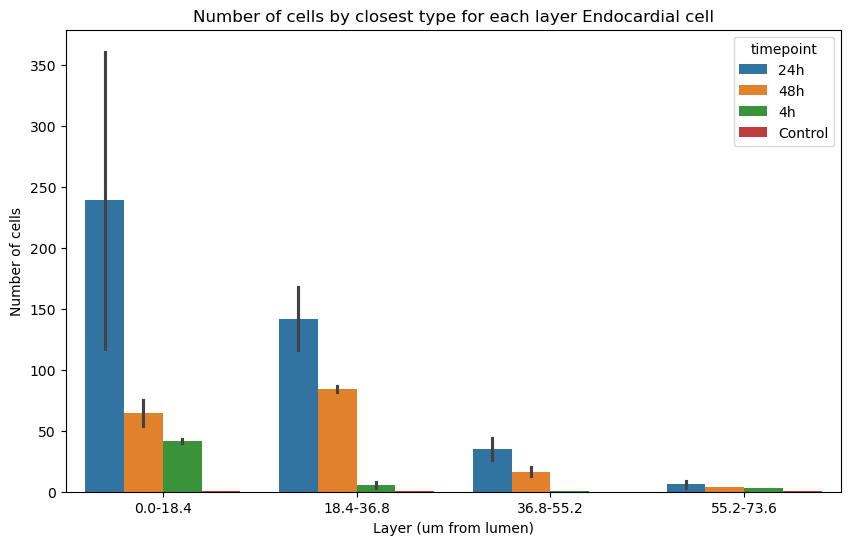

In [259]:
tmp_plot(closest_type_counts, "Endocardial cell")

([<matplotlib.axis.XTick at 0x3f7b26940>,
 [Text(0, 0, '0.0-18.4'),
  Text(1, 0, '18.4-36.8'),
  Text(2, 0, '36.8-55.2'),
  Text(3, 0, '55.2-73.6')])

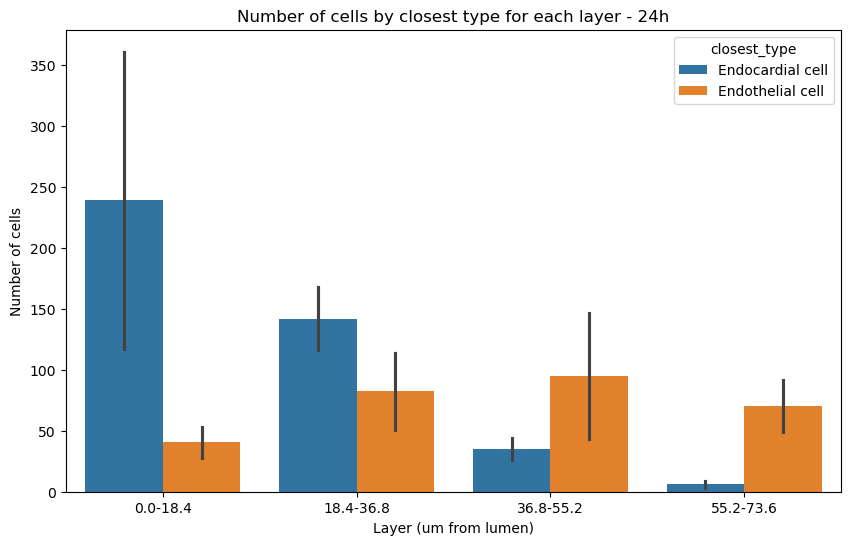

In [237]:
closest_type_counts
# exclude rows with closest_type == None

# for 24h timepoint, plot the counts of closest_type for each layer
timepoint = '24h'
closest_type_counts_subset = closest_type_counts[closest_type_counts['timepoint'] == timepoint]
closest_type_counts_subset = closest_type_counts_subset[closest_type_counts_subset['lumen_layer'] != 0]
closest_type_counts_subset = closest_type_counts_subset[closest_type_counts_subset['lumen_layer'] < 5]
# plot the counts of closest_type for each layer
plt.figure(figsize=(10, 6))
sns.barplot(x='lumen_layer', y='counts', hue='closest_type', data=closest_type_counts_subset)
plt.xlabel('Layer (um from lumen)')
plt.ylabel('Number of cells')
plt.title(f'Number of cells by closest type for each layer - {timepoint}')
# x ticks with custom text based on layer
plt.xticks(ticks=range(0, 4), labels=[f'{np.round((i-1)*iteration_width_um,1)}-{np.round((i)*iteration_width_um, 1)}' for i in range(1, 5)])


### Pixel population percentages

In [68]:
population_pixel_mask = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/pixel_masks/population_pixel_mask.csv')

def calculate_pixel_percentage_per_layer(layer, layers_input_mask, pixel_population_csv, pixel_mask):
    layer_mask = layers_input_mask == layer
    out_list = []
    for region_id in pixel_population_csv.region_id.unique():
        px_region_mask = pixel_mask == region_id
        out_list.append(np.sum(np.logical_and(layer_mask, px_region_mask))/np.sum(layer_mask))
    return out_list

In [103]:
for sample in sample_list:
    sample_final_name = sample_list_final[sample_list.index(sample)]

    pixel_map_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/pixel_masks/{sample_final_name}.pixel_mask.tiff'
    region_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_regions.tif'
    endocardium_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_endocardium.tif'
    lumen_layer_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/lumen_expanded_masks/{sample}_lumen_layers.tif'
    injury_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_injury.tif'

    pixel_map = tifffile.imread(pixel_map_path)
    layers = tifffile.imread(lumen_layer_path)

    # prepare a dataframe, each row will be a layer, each column will be a region_id
    layer_df = pd.DataFrame(columns=population_pixel_mask.region_id.unique())

    if 'Control' not in sample:
        CM_mask = tifffile.imread(injury_mask_path)
        region_mask = tifffile.imread(region_mask_path)
        # CM_mask has value 2 for infarct core which should be included in this analysis.
        # region mask has the Endocardium annotated as 2, which should be included in this analysis
        binary_target_mask = np.logical_or(region_mask == 2, CM_mask == 2)
        layers = layers * binary_target_mask
    
    unique_values_in_layers = np.unique(layers)
    unique_values_in_pixel_map = np.unique(pixel_map)

    for layer in unique_values_in_layers:
        layer_df.loc[layer] = 0.0
        layer_df.loc[layer, :] = calculate_pixel_percentage_per_layer(layer, layers, population_pixel_mask, pixel_map)
    layer_df.columns = population_pixel_mask.set_index('region_id').region_name

    if 'Control' not in sample:
        stressed_percentage_layers = []
        stressed_mask = CM_mask > 0
        for layer in unique_values_in_layers:
            layer_mask = layers == layer
            stressed_layer_mask = np.logical_and(layer_mask, CM_mask)
            stressed_percentage_layers.append(np.sum(stressed_layer_mask)/np.sum(layer_mask))
        layer_df['stressed_percentage'] = stressed_percentage_layers
    else:
        layer_df['stressed_percentage'] = [0]*len(unique_values_in_layers)

    layer_df = layer_df.iloc[1:, :] # exclude where value is 0
    layer_df.to_csv(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/{sample}_layers.csv', index=False)

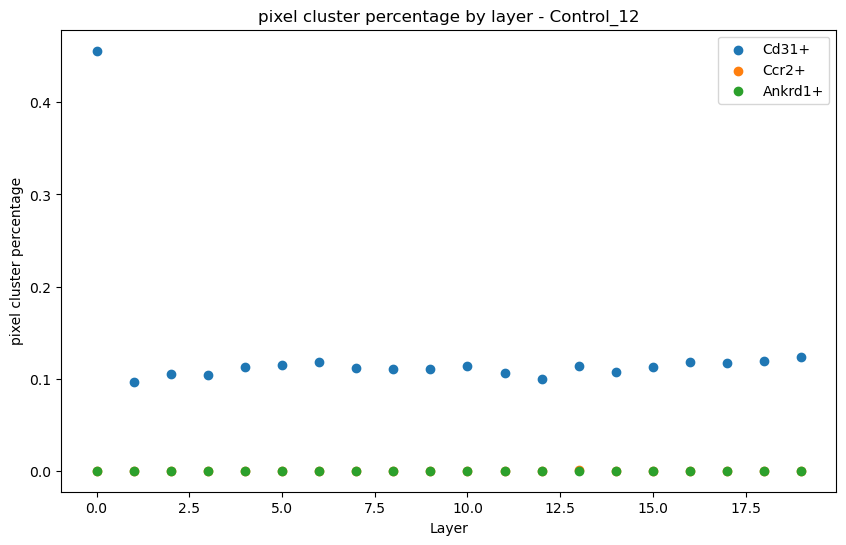

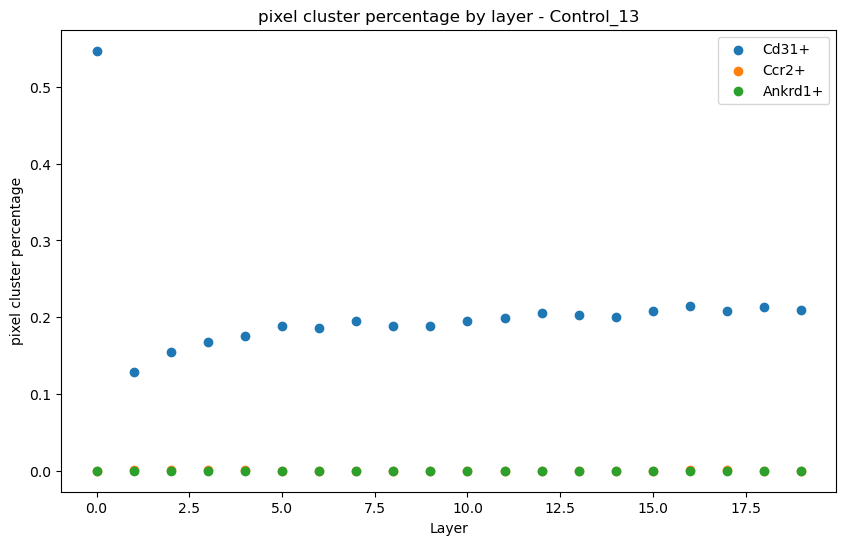

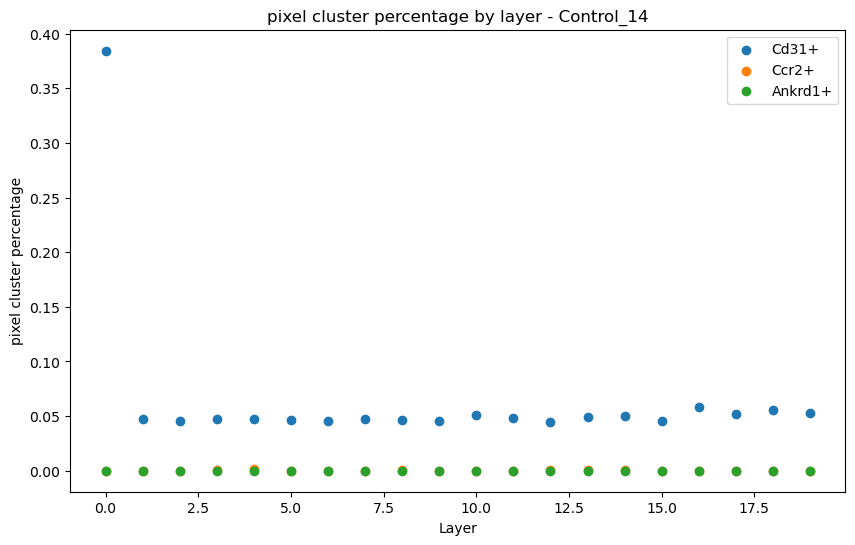

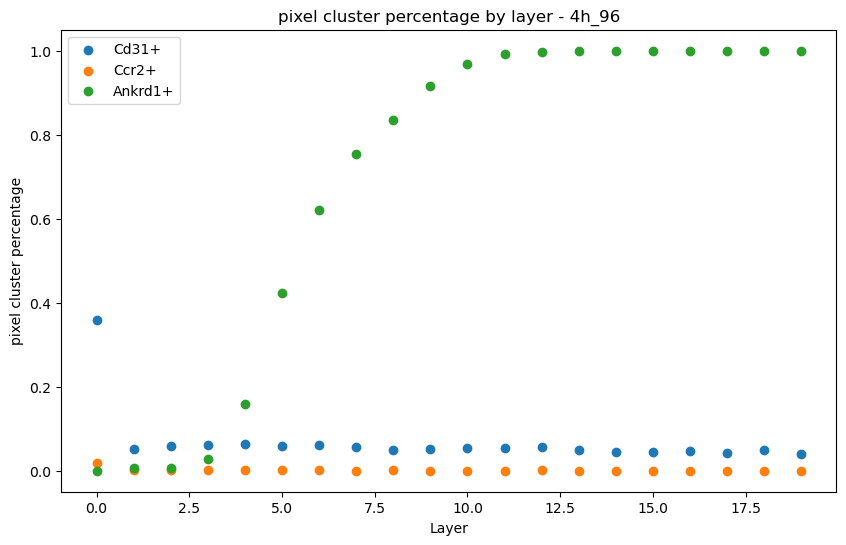

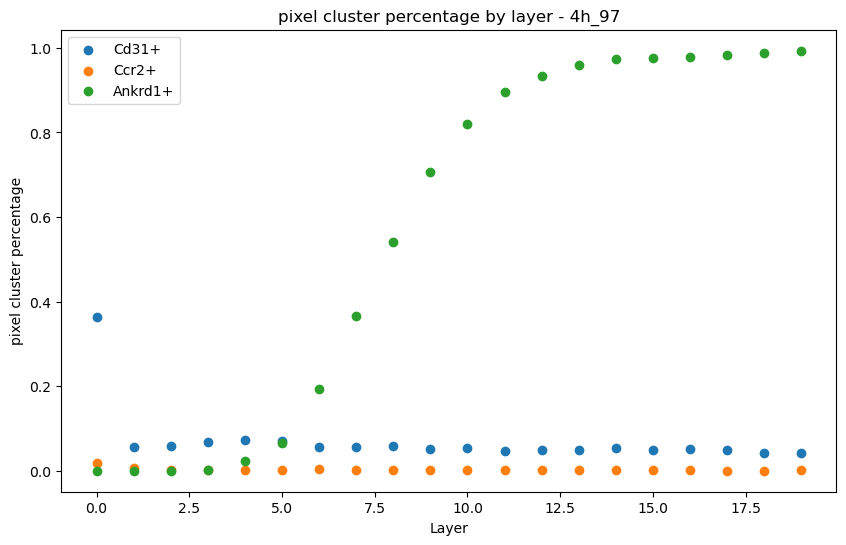

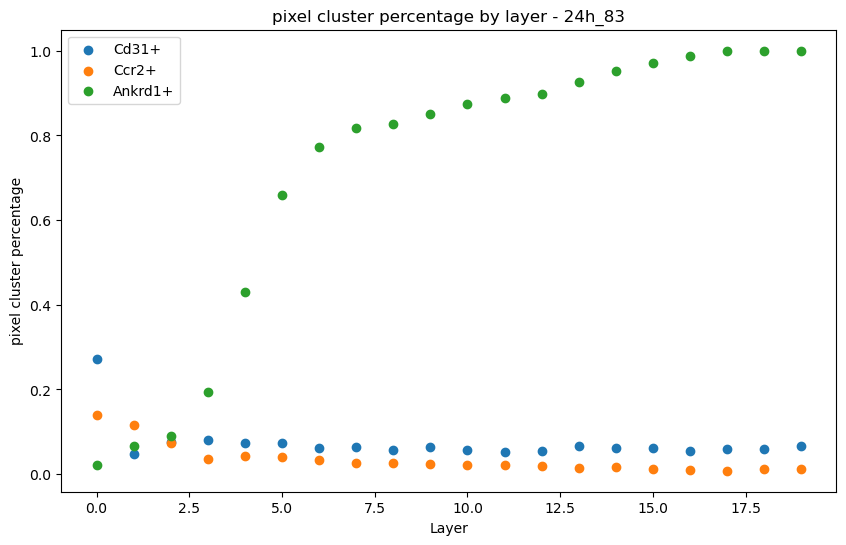

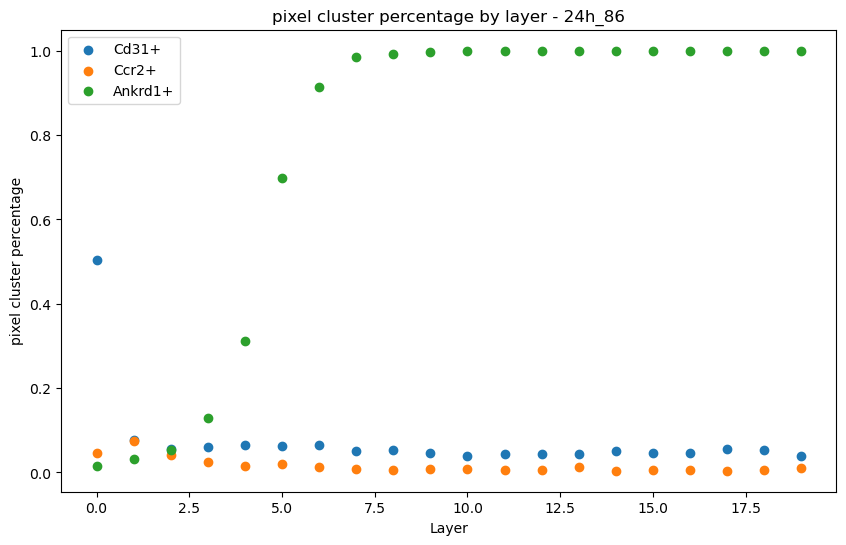

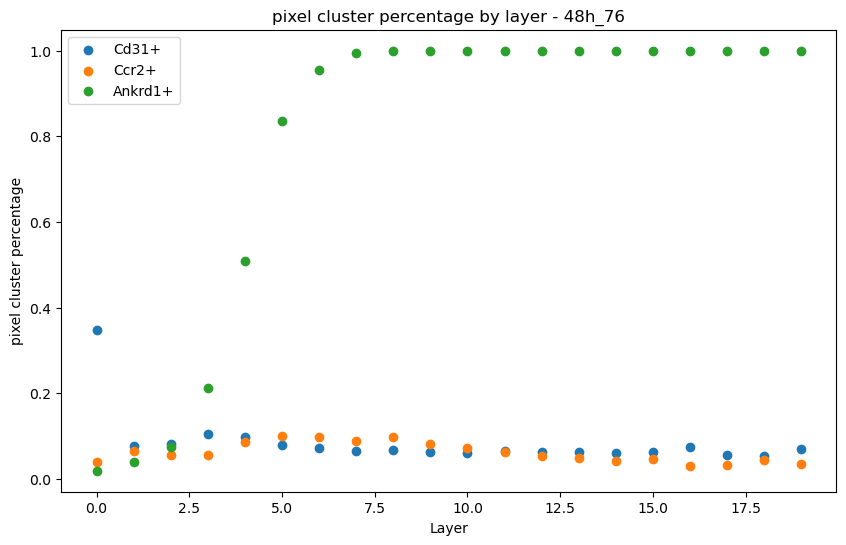

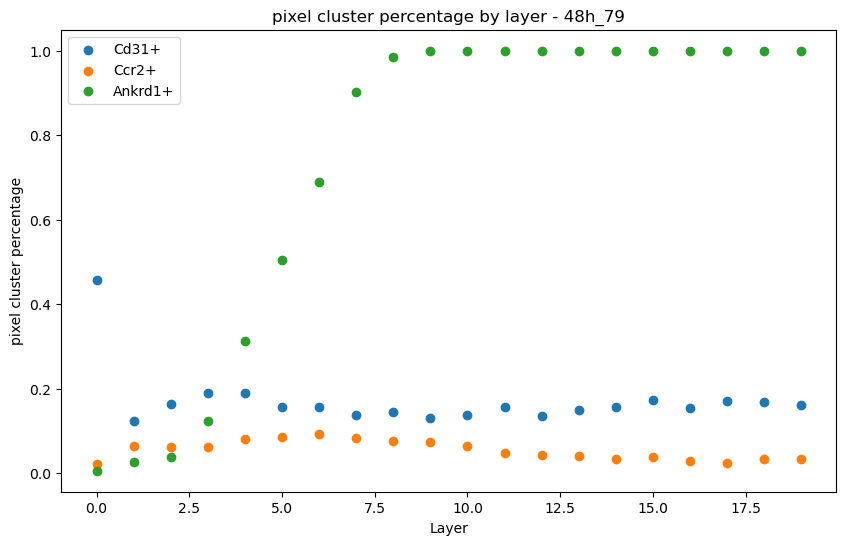

In [121]:
# plot the CD31+ column of layer_df as a scatter plot with layer on the x-axis and CD31+ percentage on the y-axis
for sample in sample_list:
    layer_df = pd.read_csv(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/{sample}_layers.csv')
    plt.figure(figsize=(10, 6))
    plt.scatter(layer_df.index, layer_df['Cd31+'])
    plt.scatter(layer_df.index, layer_df['Ccr2+'])
    #plt.scatter(layer_df.index, layer_df['Mpo+'])
    plt.scatter(layer_df.index, layer_df['stressed_percentage'])
    plt.xlabel('Layer')
    plt.legend(['Cd31+', 'Ccr2+', 'Ankrd1+'])
    plt.ylabel('pixel cluster percentage')
    plt.title('pixel cluster percentage by layer - ' + sample)
    plt.show()

In [145]:
for sample in sample_list:
    layer_df = pd.read_csv(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/{sample}_layers.csv')
    layer_df = layer_df.rename(columns={'Unnamed: 0': 'layer_value'})
    layer_df['layer_start'] = (layer_df['layer_value']-1)*iteration_width_um
    layer_df['layer_stop'] = layer_df['layer_value']*iteration_width_um
    layer_df['sample'] = sample
    sample_final_name = sample_list_final[sample_list.index(sample)]
    layer_df['sample_final'] = sample_final_name
    layer_df['timepoint'] = sample.split('_')[0]
    layer_df.to_csv(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/{sample}_layers.csv', index=False)

In [8]:
# combine all the layer quantifications into one dataframe
layer_df_combined = pd.DataFrame()
for sample in sample_list:
    layer_df = pd.read_csv(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/{sample}_layers.csv')
    layer_df_combined = pd.concat([layer_df_combined, layer_df])

In [10]:
# for Cd31+, get a mean value for each layer across Control samples
layer_df_combined['timepoint'] = layer_df_combined['timepoint'].astype('category')
layer_df_combined['sample'] = layer_df_combined['sample'].astype('category')
layer_df_combined['layer_value'] = layer_df_combined['layer_value'].astype('category')
layer_df_combined['sample_final'] = layer_df_combined['sample_final'].astype('category')

layer_df_combined['Cd31+'] = layer_df_combined['Cd31+'].astype(float)
layer_df_combined['Ccr2+'] = layer_df_combined['Ccr2+'].astype(float)
layer_df_combined['stressed_percentage'] = layer_df_combined['stressed_percentage'].astype(float)

In [11]:
# per layer, calculate the mean Cd31+ percentage for Control samples
layer_df_combined[layer_df_combined['timepoint'] == 'Control'].groupby('layer_value')[['Cd31+', 'Ccr2+']].mean()

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/354766648.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  layer_df_combined[layer_df_combined['timepoint'] == 'Control'].groupby('layer_value')[['Cd31+', 'Ccr2+']].mean()


Cd31+     Ccr2+
layer_value                    
1            0.462477  0.000090
2            0.090949  0.000214
3            0.101767  0.000170
4            0.106239  0.000568
5            0.111779  0.000565
6            0.116564  0.000096
7            0.116339  0.000082
8            0.117891  0.000115
9            0.114960  0.000236
10           0.114847  0.000004
11           0.120071  0.000011
12           0.117746  0.000083
13           0.116619  0.000172
14           0.121703  0.000242
15           0.119198  0.000260
16           0.121855  0.000007
17           0.130658  0.000147
18           0.125473  0.000135
19           0.128964  0.000051
20           0.128514  0.000012

# PLOT THE TIME SERIES IN ONE PLOT!!!! FIGURE IT OUT

In [201]:
### 

def plot_one_column_across_all(column, combined_df, error_bars=False, initial_values=False):
    combined_means = combined_df.groupby(['layer_value', 'timepoint'])[column].mean().unstack()

    combined_df['layer_value'] = combined_df['layer_value'].astype(int)

    # plot the layer_df_combined_Cd31_means as a point plot with offset for each timepoint
    plt.figure(figsize=(15, 6))
    plt.bar(combined_means.index, combined_means['Control'], width=0.2)
    plt.bar(combined_means.index+0.2, combined_means['4h'], width=0.2)
    plt.bar(combined_means.index+0.4, combined_means['24h'], width=0.2)
    plt.bar(combined_means.index+0.6, combined_means['48h'], width=0.2)

    # add legend
    plt.legend(['Control', '4h', '24h', '48h'])

    # add initial layer values from layer_df_combined as points
    if initial_values:
        plt.scatter(combined_df[combined_df['timepoint'] == 'Control']['layer_value'], combined_df[combined_df['timepoint'] == 'Control'][column], color='black', s=10)
        plt.scatter(combined_df[combined_df['timepoint'] == '4h']['layer_value']+0.2, combined_df[combined_df['timepoint'] == '4h'][column], color='black', s=10)
        plt.scatter(combined_df[combined_df['timepoint'] == '24h']['layer_value']+0.4, combined_df[combined_df['timepoint'] == '24h'][column], color='black', s=10)
        plt.scatter(combined_df[combined_df['timepoint'] == '48h']['layer_value']+0.6, combined_df[combined_df['timepoint'] == '48h'][column], color='black', s=10)

    # add error bars
    if error_bars:
        plt.errorbar(combined_means.index, combined_means['Control'], yerr=combined_df[combined_df['timepoint'] == 'Control'].groupby('layer_value')[column].std(), fmt='none', color='black')
        plt.errorbar(combined_means.index+0.2, combined_means['4h'], yerr=combined_df[combined_df['timepoint'] == '4h'].groupby('layer_value')[column].std(), fmt='none', color='black')
        plt.errorbar(combined_means.index+0.4, combined_means['24h'], yerr=combined_df[combined_df['timepoint'] == '24h'].groupby('layer_value')[column].std(), fmt='none', color='black')
        plt.errorbar(combined_means.index+0.6, combined_means['48h'], yerr=combined_df[combined_df['timepoint'] == '48h'].groupby('layer_value')[column].std(), fmt='none', color='black')
    # add title
    plt.title(f'{column} by layer across timepoints')
    # replace xtick values with layer start and stop values
    plt.xticks(ticks=combined_means.index+0.3, labels=[f'{np.round((i-1)*iteration_width_um,1)} - {np.round(i*iteration_width_um, 1)}' for i in combined_means.index])
    # y axis is column percentage
    plt.ylabel(f'{column} fraction')
    plt.xlabel('Distance from lumen (µm)')


In [83]:
layer_df_combined.groupby(['layer_value', 'timepoint'])[['Cd31+', 'Ccr2+']].mean().unstack()

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/2534123719.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  layer_df_combined.groupby(['layer_value', 'timepoint'])[['Cd31+', 'Ccr2+']].mean().unstack()


Cd31+                                   Ccr2+            \
timepoint         24h       48h        4h   Control       24h       48h   
layer_value                                                               
1            0.387575  0.403423  0.360498  0.462477  0.093682  0.031379   
2            0.061575  0.099715  0.053261  0.090949  0.095394  0.065747   
3            0.064735  0.122621  0.058282  0.101767  0.057489  0.058541   
4            0.070919  0.147278  0.065469  0.106239  0.030853  0.058435   
5            0.068653  0.143245  0.068112  0.111779  0.029445  0.084185   
6            0.067063  0.117366  0.064932  0.116564  0.030869  0.092724   
7            0.064037  0.115018  0.059065  0.116339  0.023420  0.094755   
8            0.058437  0.101032  0.056808  0.117891  0.017691  0.085978   
9            0.055908  0.105961  0.053233  0.114960  0.015906  0.086475   
10           0.054395  0.096758  0.052262  0.114847  0.016015  0.077770   
11           0.048258  0.098873  0.054203  0.120071  0.015081  0.068960   
12           0.048438  0.110341  0.050493  0.117746  0.013543  0.055450   
13           0.049806  0.099417  0.052697  0.116619  0.013070  0.048069   
14           0.054818  0.106154  0.048427  0.121703  0.013119  0.045555   
15           0.056842  0.108876  0.049049  0.119198  0.010436  0.037315   
16           0.053989  0.117914  0.046811  0.121855  0.009639  0.042353   
17           0.050011  0.114332  0.048190  0.130658  0.006988  0.030092   
18           0.057010  0.113808  0.045530  0.125473  0.006219  0.028822   
19           0.057253  0.111451  0.045085  0.128964  0.009520  0.039046   
20           0.052742  0.115716  0.041700  0.128514  0.011081  0.034978   

                                 
timepoint          4h   Control  
layer_value                      
1            0.018054  0.000090  
2            0.003314  0.000214  
3            0.001984  0.000170  
4            0.001800  0.000568  
5            0.001574  0.000565  
6            0.001340  0.000096  
7            0.002002  0.000082  
8            0.001279  0.000115  
9            0.001156  0.000236  
10           0.001181  0.000004  
11           0.000543  0.000011  
12           0.000809  0.000083  
13           0.000997  0.000172  
14           0.000446  0.000242  
15           0.001149  0.000260  
16           0.000624  0.000007  
17           0.000307  0.000147  
18           0.000174  0.000135  
19           0.000131  0.000051  
20           0.000906  0.000012

In [41]:
layer_df_combined.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/layer_df_combined.csv', index=False)

In [38]:
import seaborn as sns
def plot_heatmap(columns, combined_df):
    # get information about all columns in the columns list

    combined_means = combined_df.groupby(['layer_value', 'timepoint'])[columns].mean().unstack()

    combined_df['layer_value'] = combined_df['layer_value'].astype(int)
    plt.figure(figsize=(10, 6))
    # show only first 6 layers
    sns.heatmap(combined_means.iloc[:6, :], cmap='viridis')
    plt.xlabel('Timepoint')
    plt.ylabel('Layer')
    plt.title(f'{columns} by layer across timepoints')

    return

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/2650382563.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_means = combined_df.groupby(['layer_value', 'timepoint'])[columns].mean().unstack()
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/2650382563.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_means = combined_df.groupby(['layer_value', 'timepoint'])[columns].mean().unstack()
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/2650382563.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a 

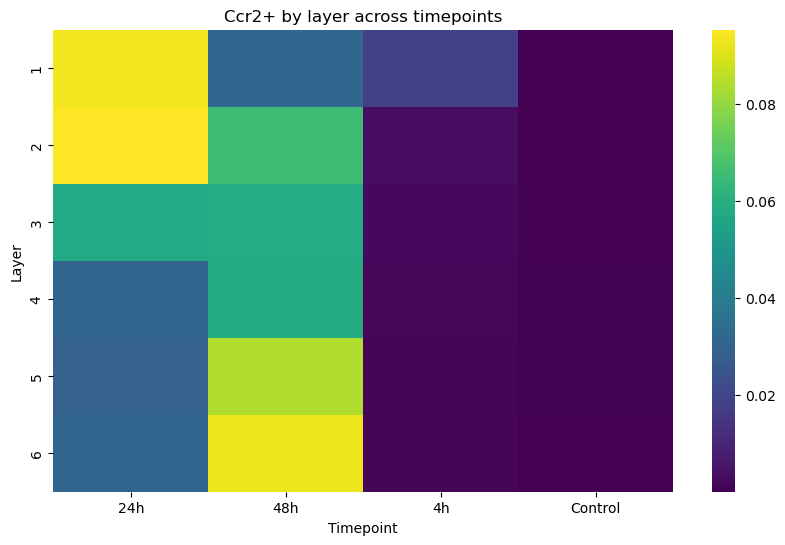

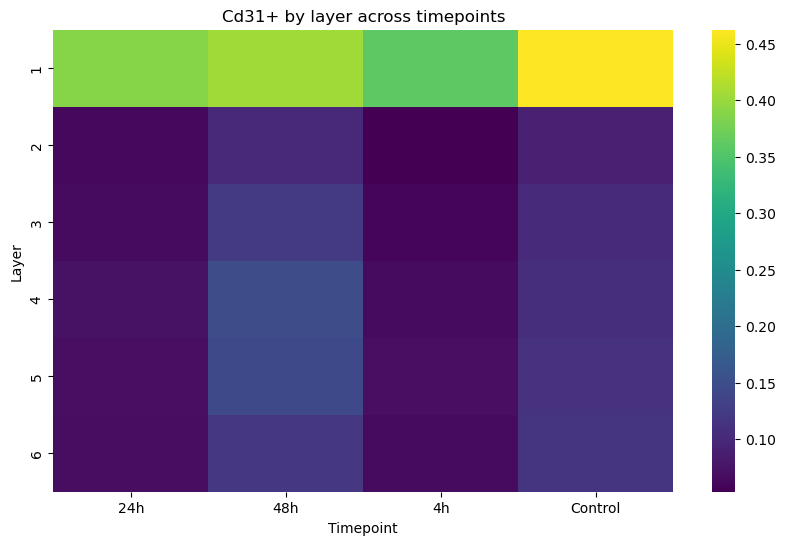

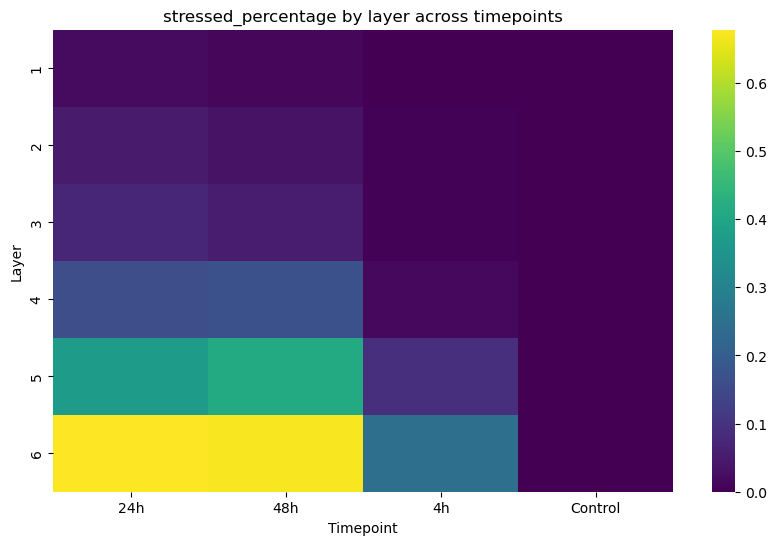

In [84]:
plot_heatmap('Ccr2+', layer_df_combined)
plot_heatmap('Cd31+', layer_df_combined)
plot_heatmap('stressed_percentage', layer_df_combined)

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/756070653.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, replicate_data in time_point_data.groupby('sample'):


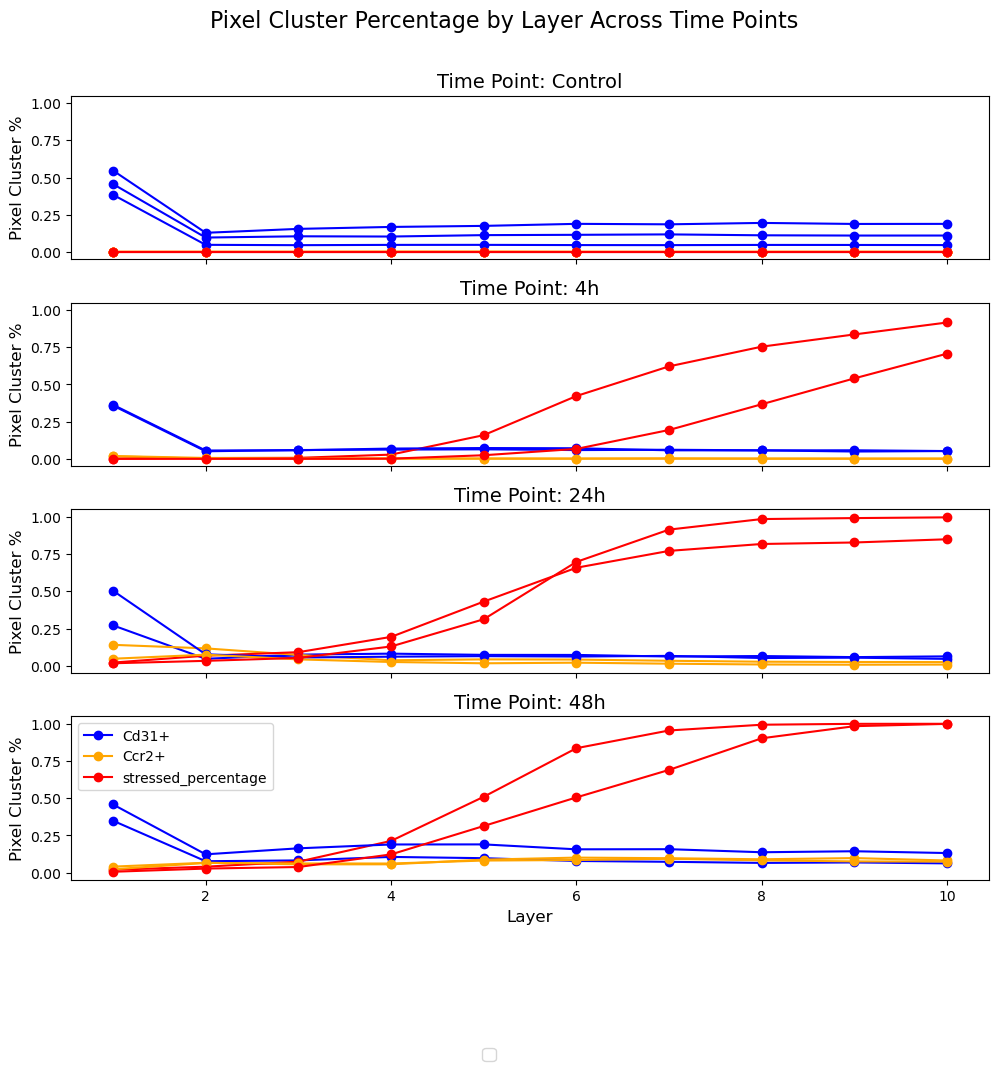

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
layer_df_combined
# Get the unique time points
time_points = layer_df_combined['timepoint'].unique()

# Set up the figure and subplots
fig, axs = plt.subplots(len(time_points), 1, figsize=(10, 10), sharex=True, sharey=True)

# Colors for the markers
colors = {'Cd31+': 'blue', 'Ccr2+': 'orange', 'stressed_percentage': 'red'}

# subset layer_df_combined to only include first 10 layers
layer_df_subset = layer_df_combined[layer_df_combined['layer_value'] <= 10]

# Plot for each time point
for i, time_point in enumerate(time_points):
    ax = axs[i]
    time_point_data = layer_df_subset[layer_df_subset['timepoint'] == time_point]
    
    # Iterate over each replicate within the time point
    for _, replicate_data in time_point_data.groupby('sample'):
        ax.plot(replicate_data['layer_value'], replicate_data['Cd31+'], marker='o', color=colors['Cd31+'])
        ax.plot(replicate_data['layer_value'], replicate_data['Ccr2+'], marker='o', color=colors['Ccr2+'])
        ax.plot(replicate_data['layer_value'], replicate_data['stressed_percentage'], marker='o', color=colors['stressed_percentage'])
    
    ax.set_title(f'Time Point: {time_point}', fontsize=14)
    ax.set_ylabel('Pixel Cluster %', fontsize=12)
    
    if i == len(time_points) - 1:
        ax.set_xlabel('Layer', fontsize=12)

# Creating a single legend for all subplots
lines, labels = axs[0].get_legend_handles_labels()
fig.legend(lines[:3], ['Cd31+', 'Ccr2+', 'stressed_percentage'], loc='upper right', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)

# Adjust layout
plt.suptitle('Pixel Cluster Percentage by Layer Across Time Points', fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.97])  # Adjust rect to make room for the legend
plt.legend(['Cd31+', 'Ccr2+', 'stressed_percentage'])
# Show the plot
plt.show()

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/885760634.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, replicate_data in time_point_data.groupby('sample'):


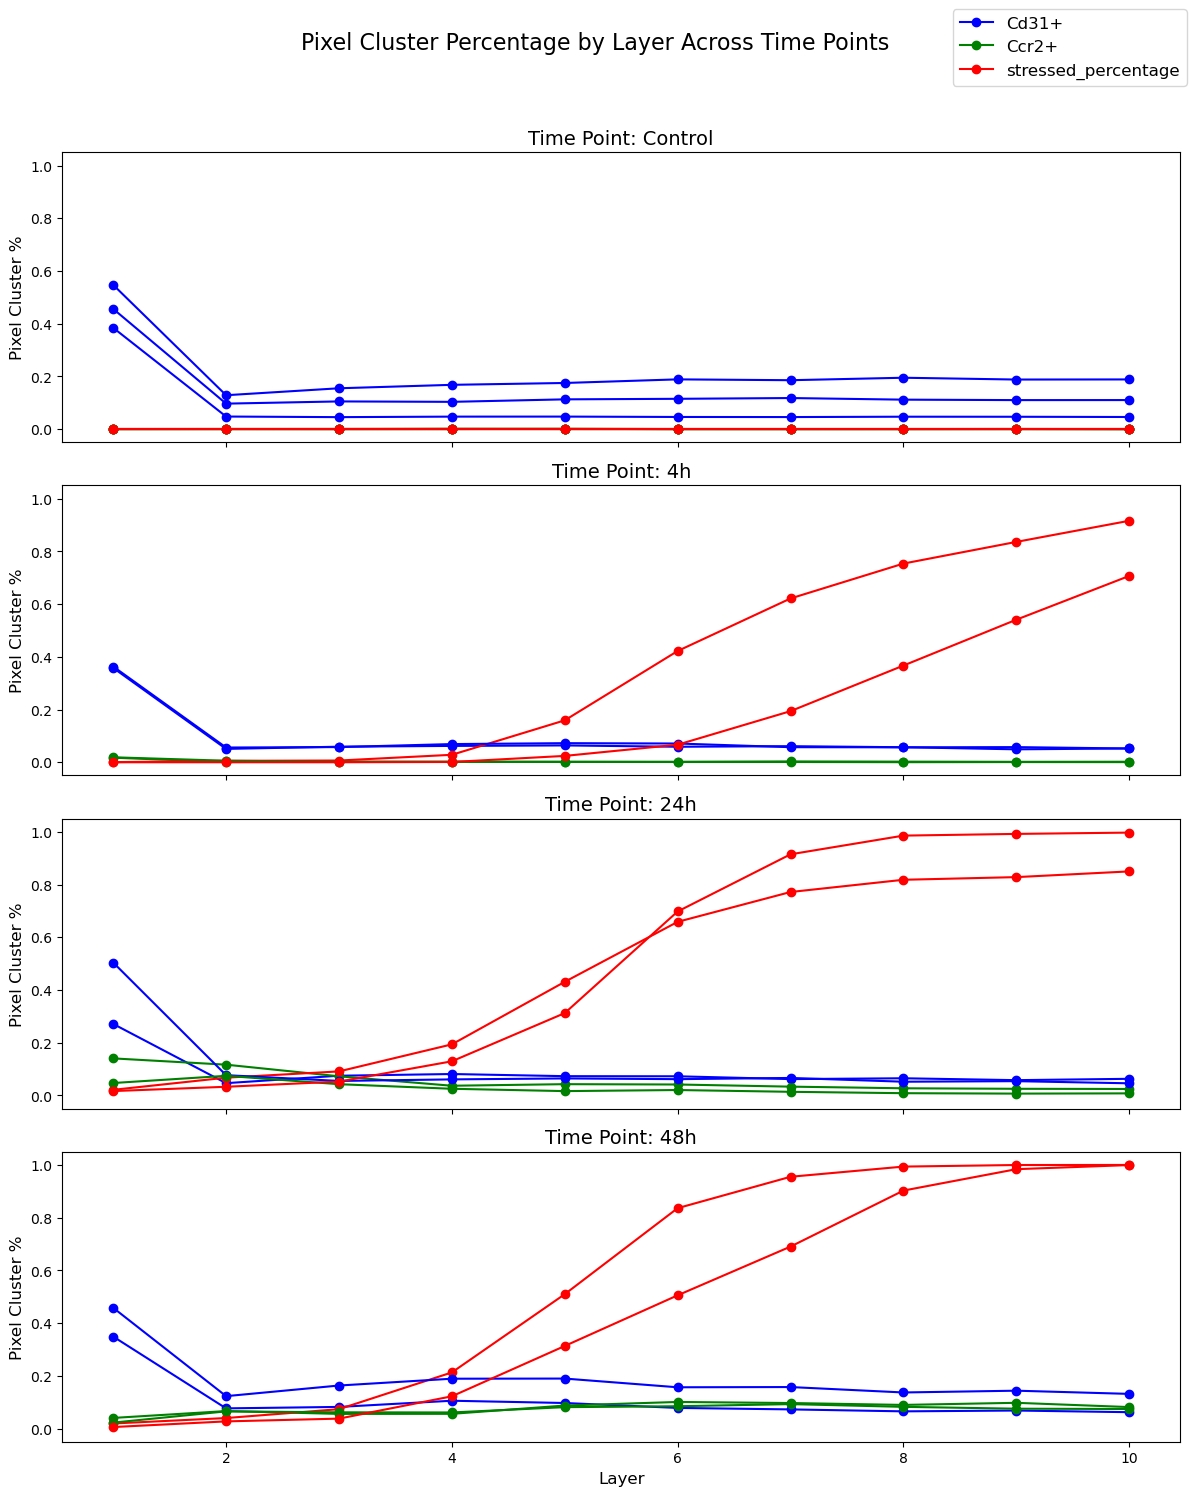

<Figure size 640x480 with 0 Axes>

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'layer_df_combined' is already defined or loaded

# Get the unique time points
time_points = layer_df_combined['timepoint'].unique()

# Set up the figure and subplots
fig, axs = plt.subplots(len(time_points), 1, figsize=(12, 15), sharex=True, sharey=True)

# Colors for the markers
colors = {'Cd31+': 'blue', 'Ccr2+': 'green', 'stressed_percentage': 'red'}

# Subset layer_df_combined to only include the first 10 layers
layer_df_subset = layer_df_combined[layer_df_combined['layer_value'] <= 10]

# Plot for each time point
for i, time_point in enumerate(time_points):
    ax = axs[i]
    time_point_data = layer_df_subset[layer_df_subset['timepoint'] == time_point]
    
    # Iterate over each replicate within the time point
    for _, replicate_data in time_point_data.groupby('sample'):
        ax.plot(replicate_data['layer_value'], replicate_data['Cd31+'], marker='o', color=colors['Cd31+'])
        ax.plot(replicate_data['layer_value'], replicate_data['Ccr2+'], marker='o', color=colors['Ccr2+'])
        ax.plot(replicate_data['layer_value'], replicate_data['stressed_percentage'], marker='o', color=colors['stressed_percentage'])
    
    ax.set_title(f'Time Point: {time_point}', fontsize=14)
    ax.set_ylabel('Pixel Cluster %', fontsize=12)
    
    if i == len(time_points) - 1:
        ax.set_xlabel('Layer', fontsize=12)

# Creating a single legend for all subplots
lines, labels = axs[0].get_legend_handles_labels()
fig.legend(['Cd31+', 'Ccr2+', 'stressed_percentage'], loc='upper right', fontsize=12, bbox_to_anchor=(1, 1))

# Adjust layout
plt.suptitle('Pixel Cluster Percentage by Layer Across Time Points', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make room for the legend

# Show the plot
plt.show()

# save plot
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/layer_quantifications.png')

In [153]:
layer_df_combined_cells = pd.DataFrame()
cell_type_list = cell_data.cell_meta_cluster.unique()
for sample in sample_list:

    sample_final_name = sample_list_final[sample_list.index(sample)]

    pixel_map_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/pixel_masks/{sample_final_name}.pixel_mask.tiff'
    region_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_regions.tif'
    endocardium_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_endocardium.tif'
    lumen_layer_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/lumen_expanded_masks/{sample}_lumen_layers.tif'
    injury_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_injury.tif'

    cell_data_subset = cell_data[cell_data['fov'] == sample]
    layers = tifffile.imread(lumen_layer_path)

    # prepare a dataframe, each row will be a layer, each column will be a region_id
    layer_df = pd.DataFrame(columns=cell_type_list)

    unique_values_in_layers = np.unique(layers)
    unique_values_in_cell_data = cell_data_subset.cell_meta_cluster.unique()

    def calculate_layer_value(x, y, layers_mask):
        return layers_mask[y, x]

    cell_data_subset['layer_value'] = cell_data_subset.apply(lambda x: calculate_layer_value(np.rint(x['X_centroid']).astype(int), np.rint(x['Y_centroid']).astype(int), layers), axis=1)
    cell_df = cell_data_subset.groupby('layer_value')['cell_meta_cluster'].value_counts().unstack()
    cell_df = cell_df.fillna(0)
    cell_df = cell_df.astype(int)
    cell_df = cell_df.div(cell_data_subset.layer_value.value_counts(), axis=0)
    cell_df['sample'] = sample
    cell_df = cell_df.drop(0)
    
    layer_df_combined_cells = pd.concat([layer_df_combined_cells, cell_df])

layer_df_combined_cells.columns = layer_df_combined_cells.columns.values
layer_df_combined_cells['layer_value'] = layer_df_combined_cells.index.astype(int)
layer_df_combined_cells.reset_index(drop=True, inplace=True)

layer_df_combined_all = pd.merge(layer_df_combined, layer_df_combined_cells, on=['layer_value', 'sample'], how='left')
layer_df_combined_all.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/layer_df_combined_all.csv', index=False)

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/1102821399.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['layer_value'] = cell_data_subset.apply(lambda x: calculate_layer_value(np.rint(x['X_centroid']).astype(int), np.rint(x['Y_centroid']).astype(int), layers), axis=1)
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/1102821399.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['layer_value'] = cell_data_subset.apply(lambda x: calcu

In [188]:
# write a list that includes 1:14 and 19:-2
columns_list = list(range(1, 14))
columns_list.extend(list(range(19, len(layer_df_combined_all.columns)-2)))

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/4105946077.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_means = combined_df.groupby(['layer_value', 'timepoint'])[column].mean().unstack()
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/4105946077.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['layer_value'] = combined_df['layer_value'].astype(int)
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/4105946077.py:4: FutureWarning: The default of observed=False is deprecated and wil

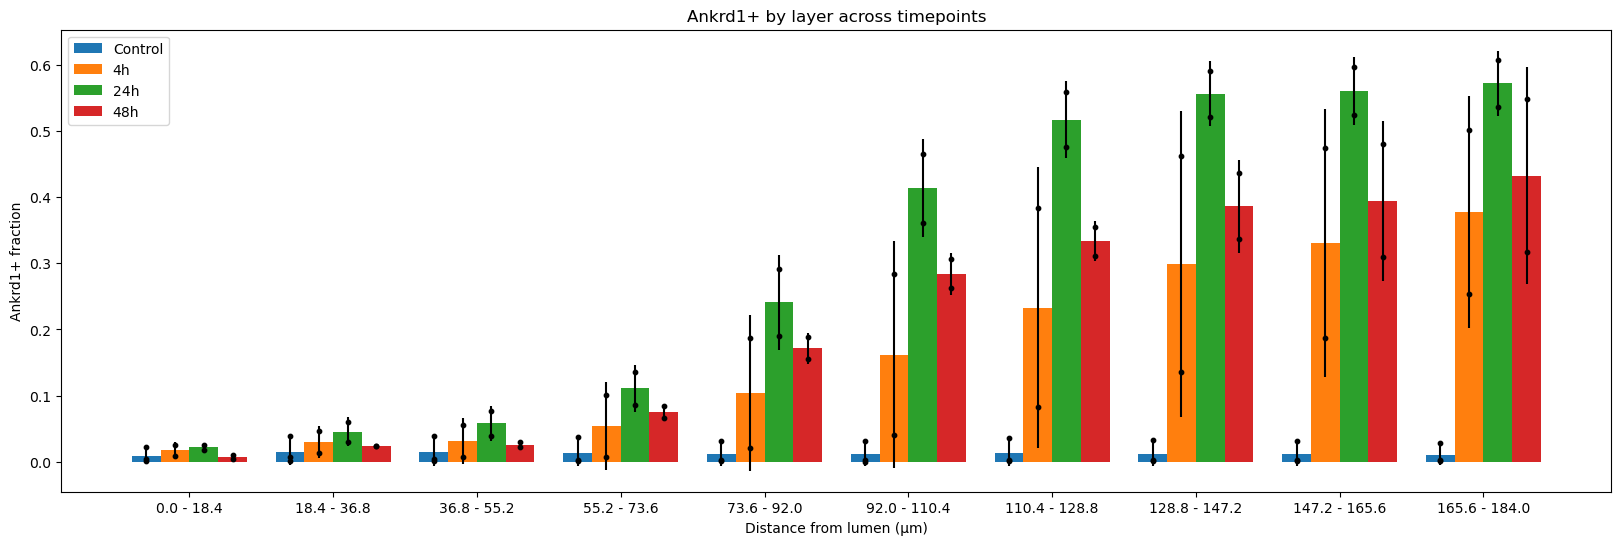

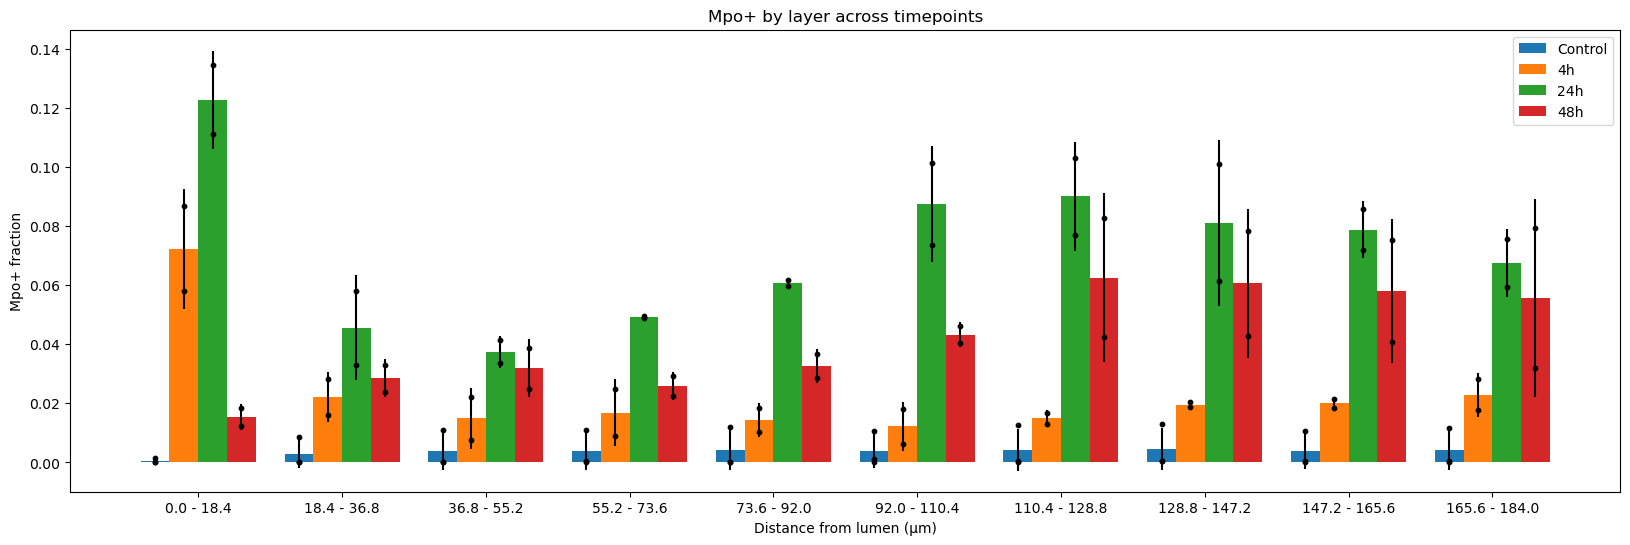

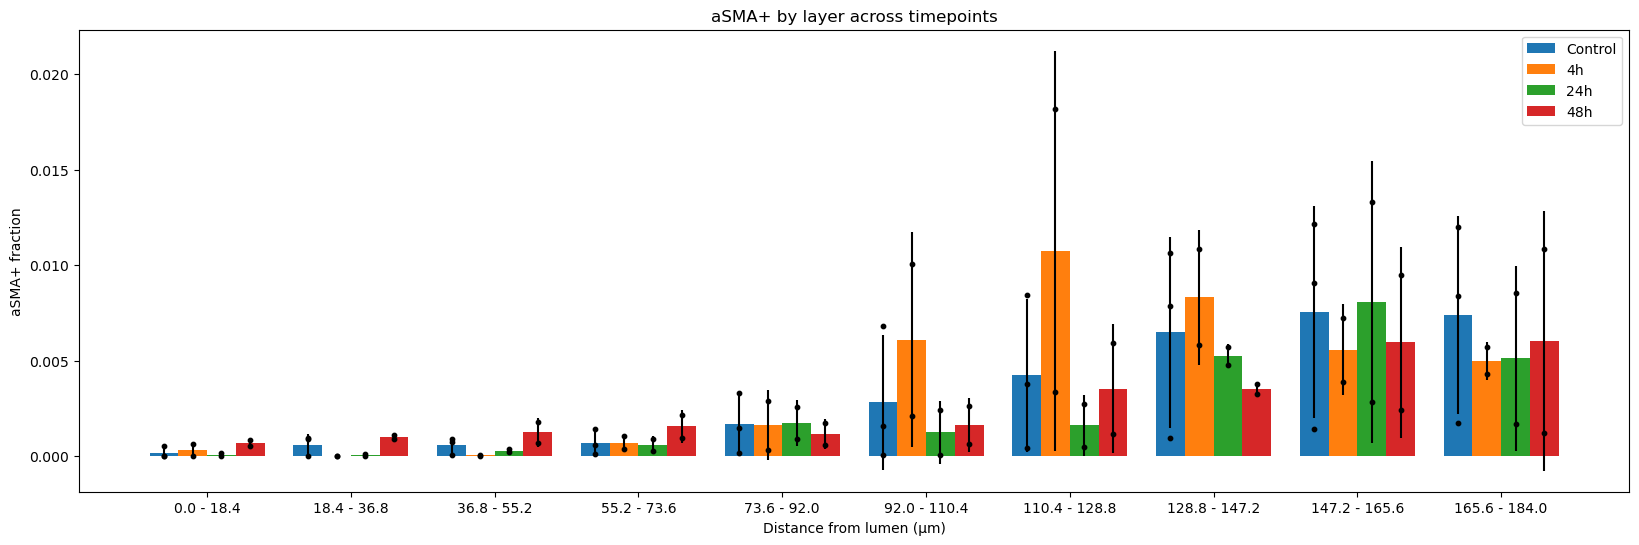

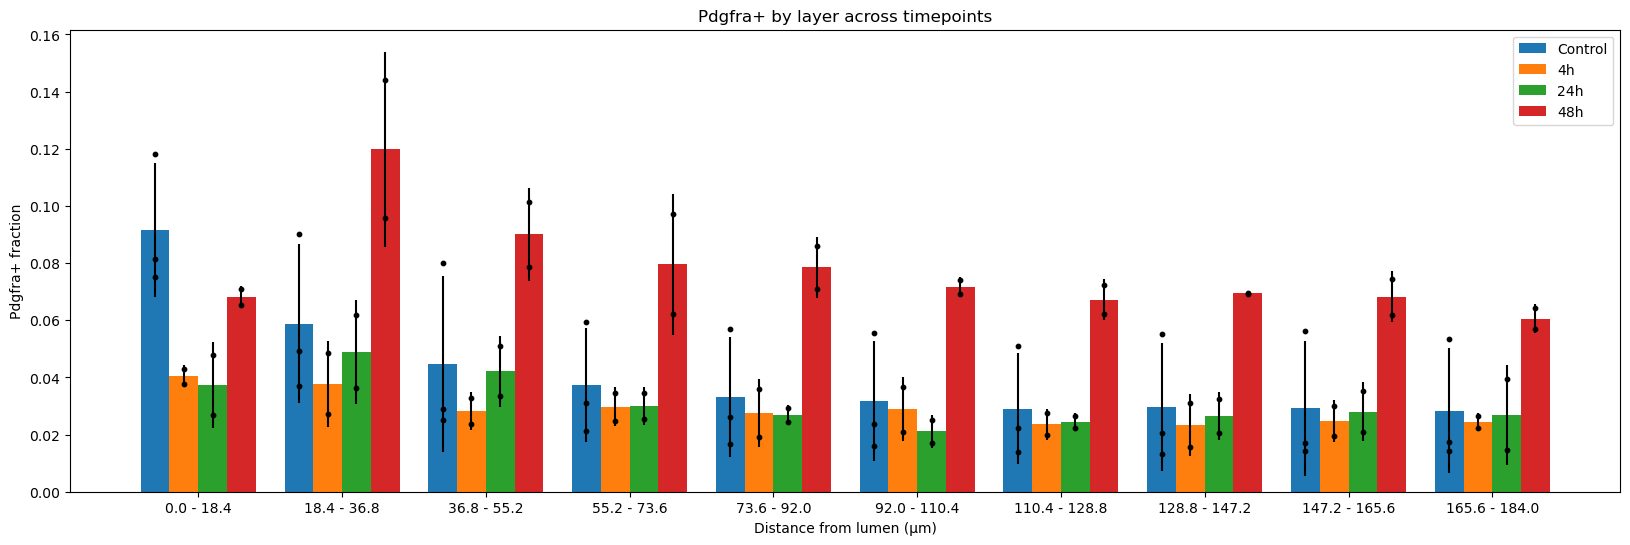

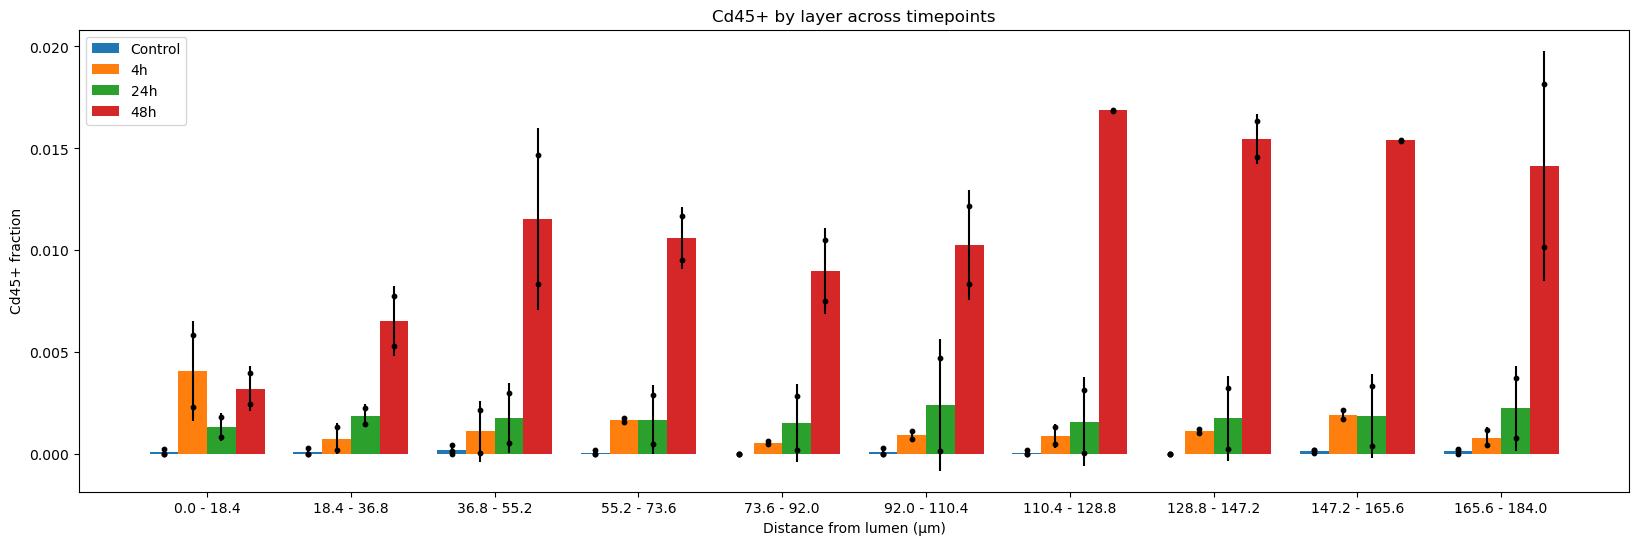

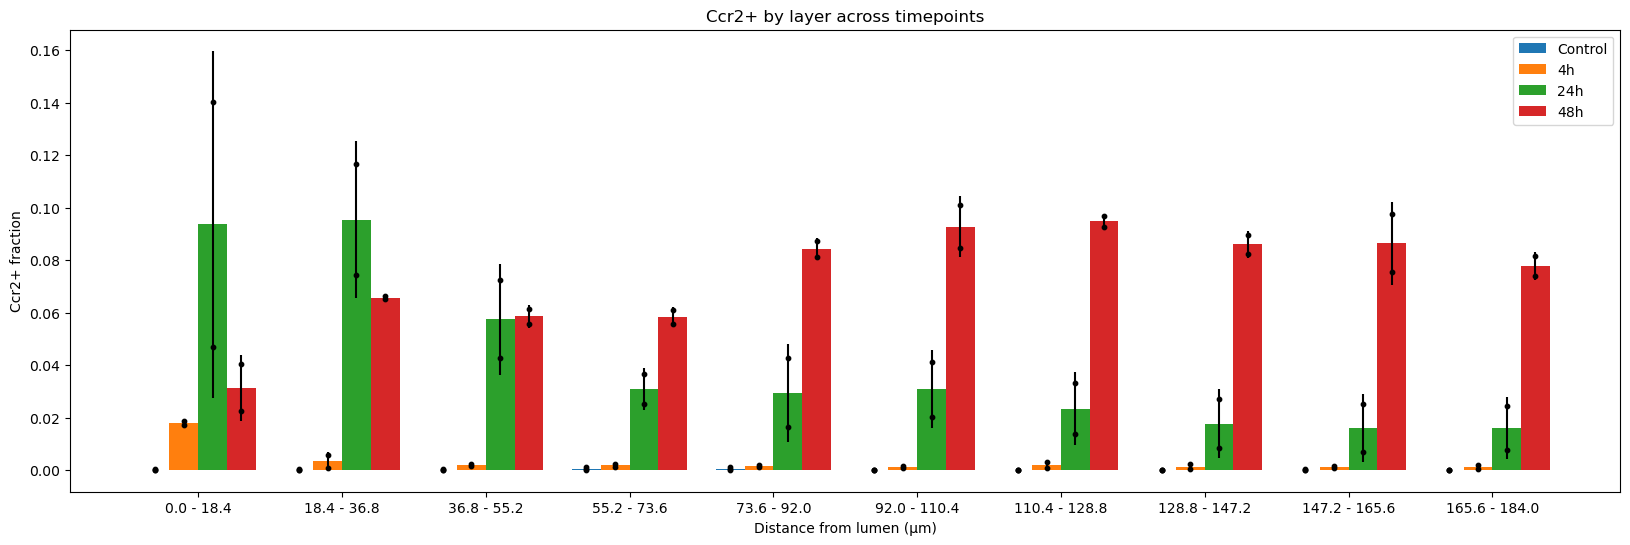

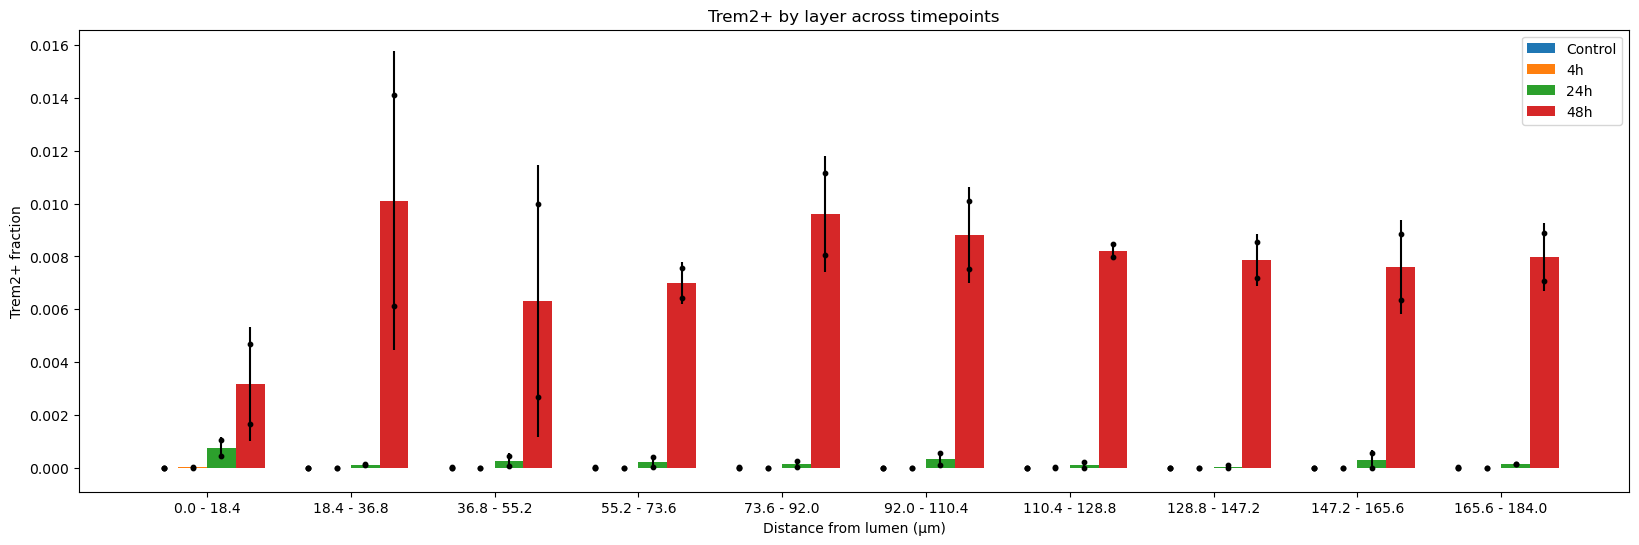

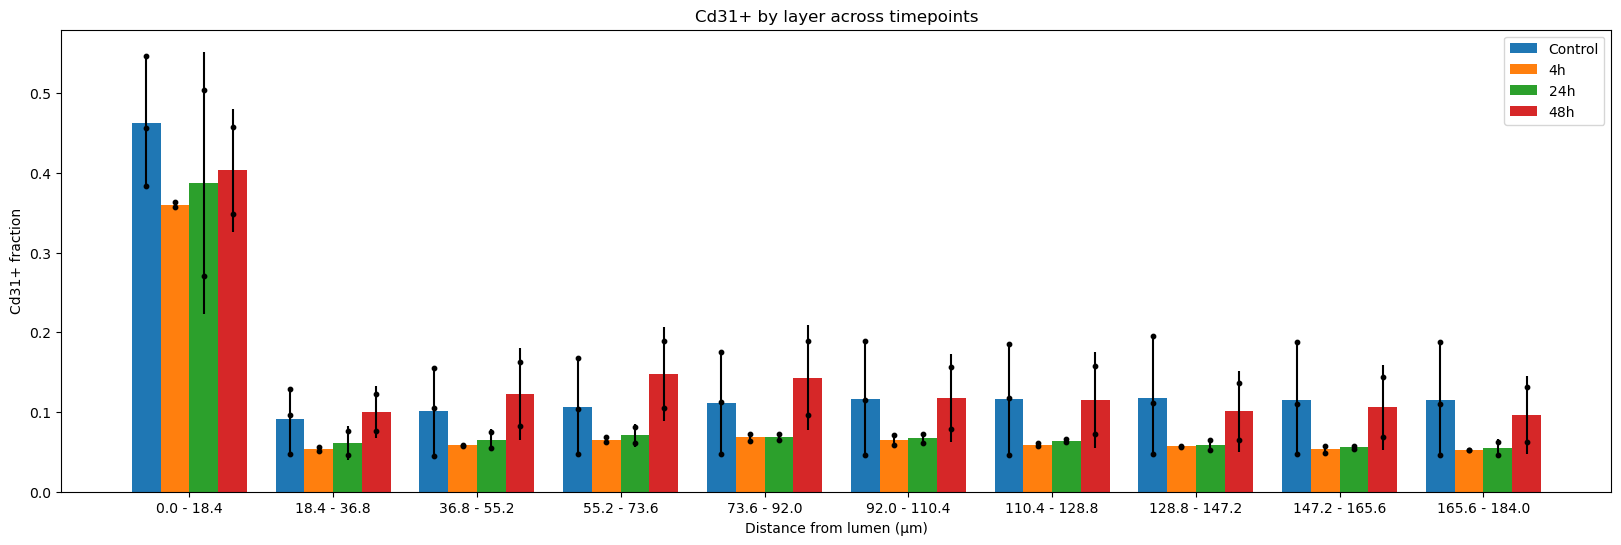

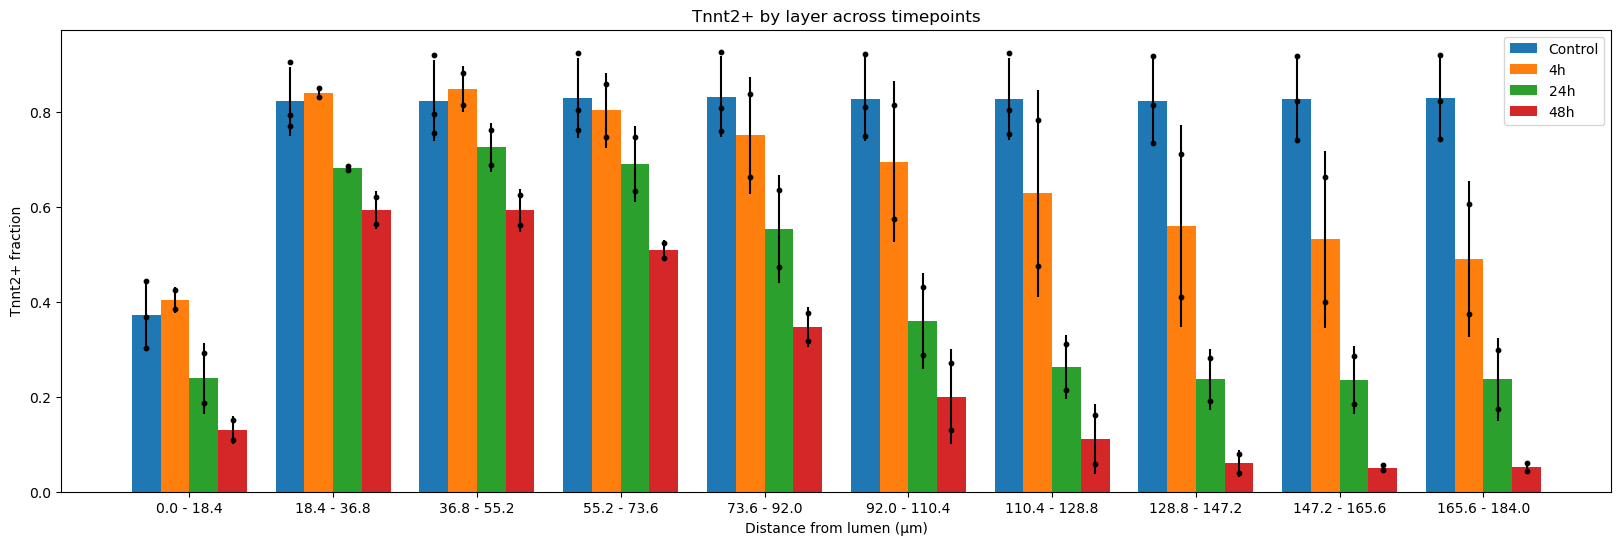

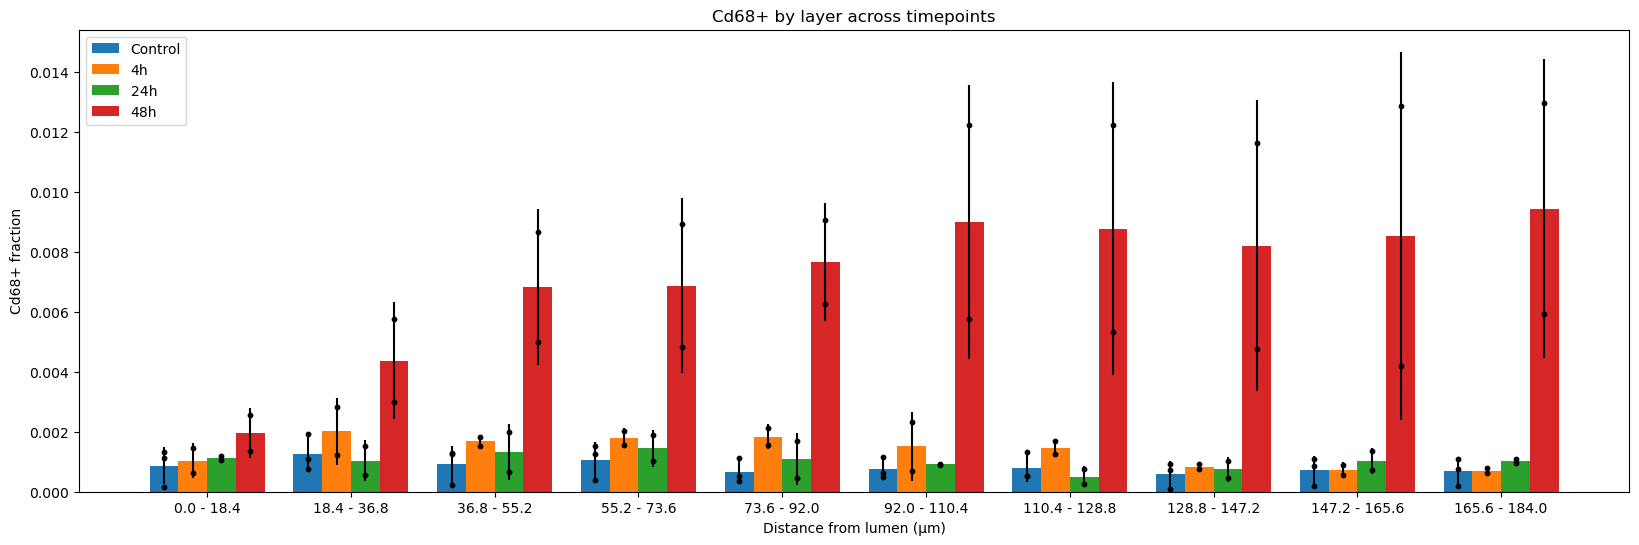

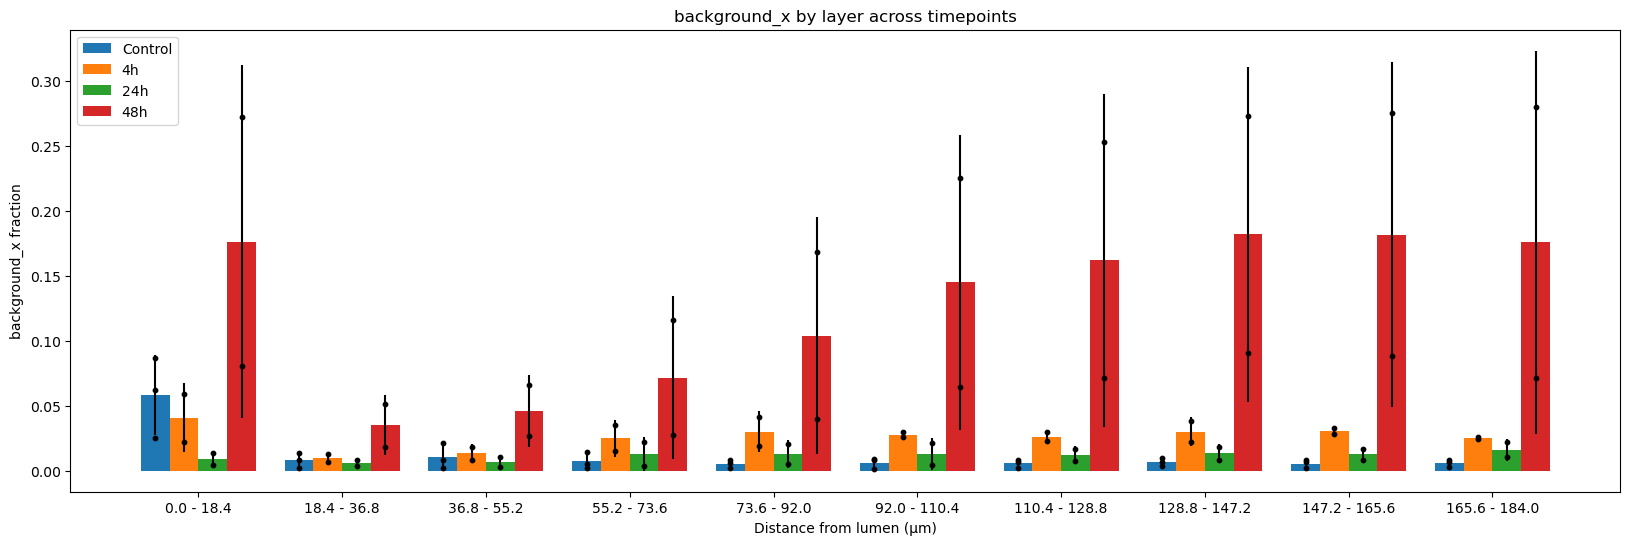

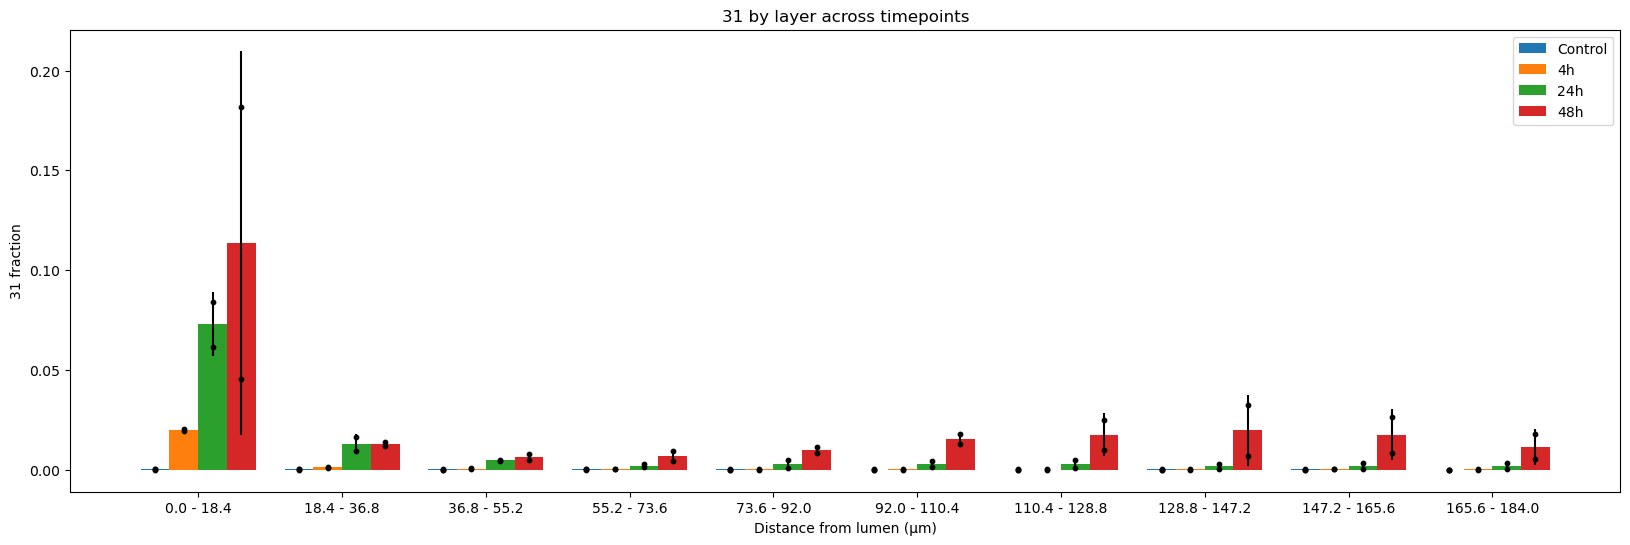

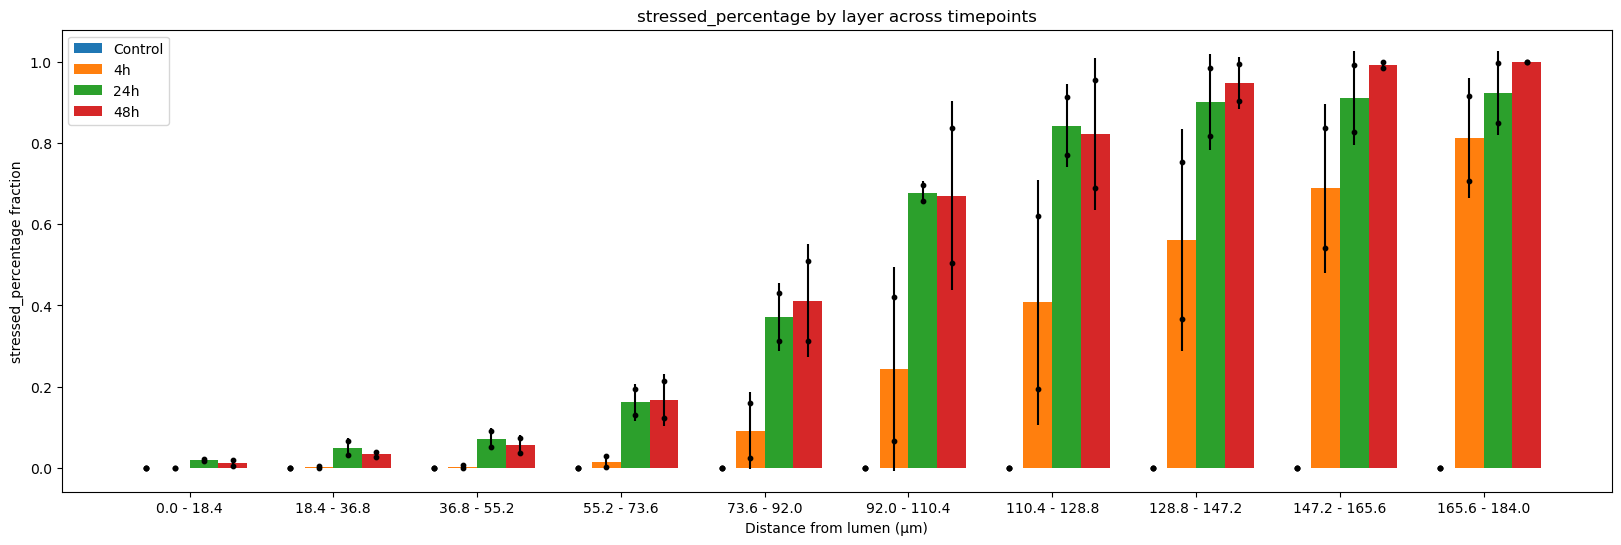

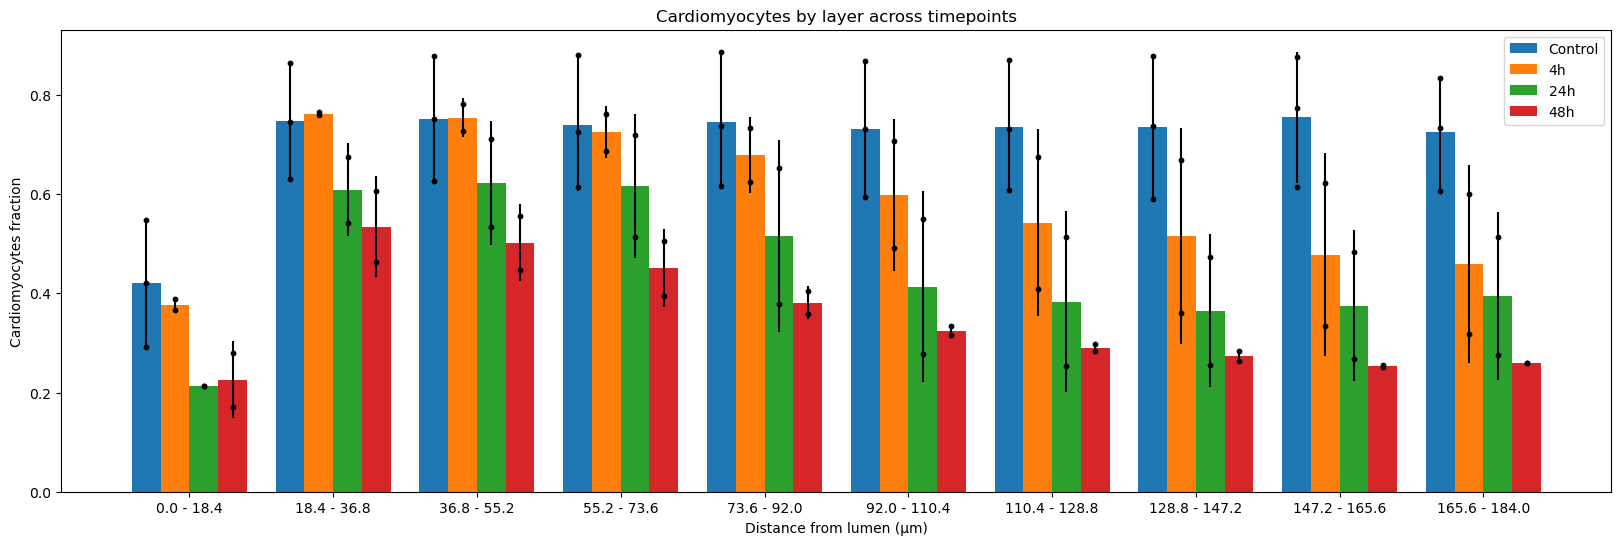

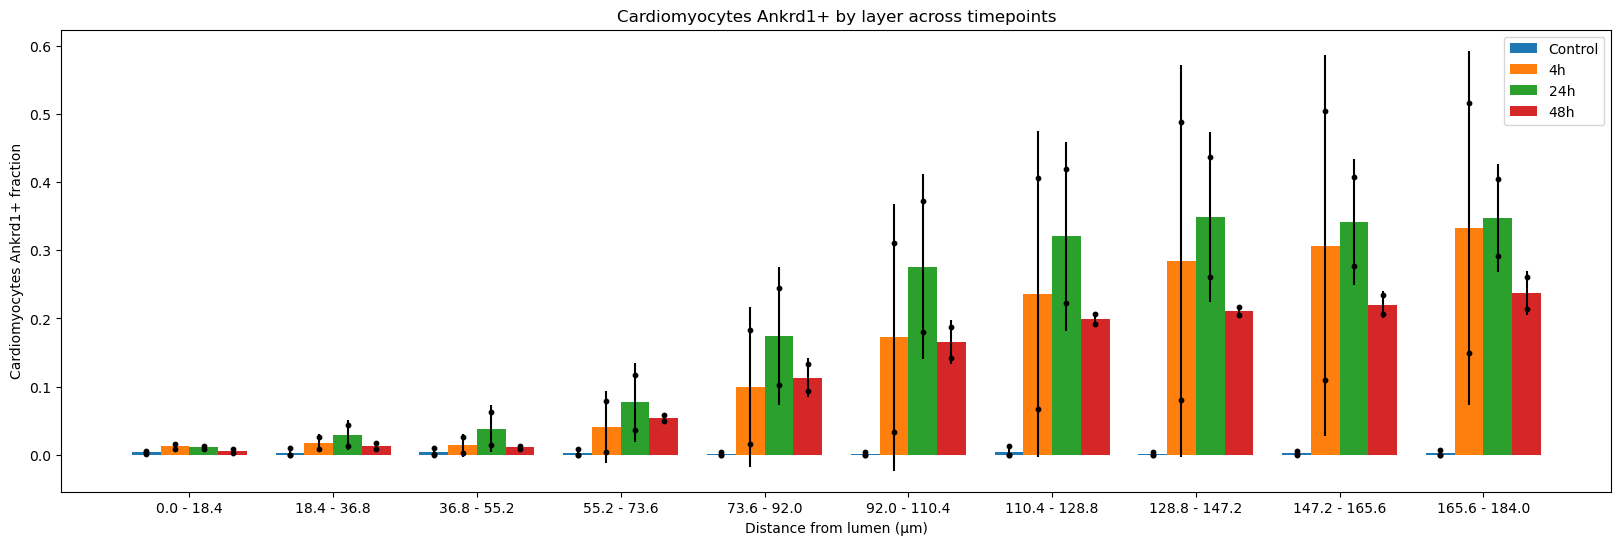

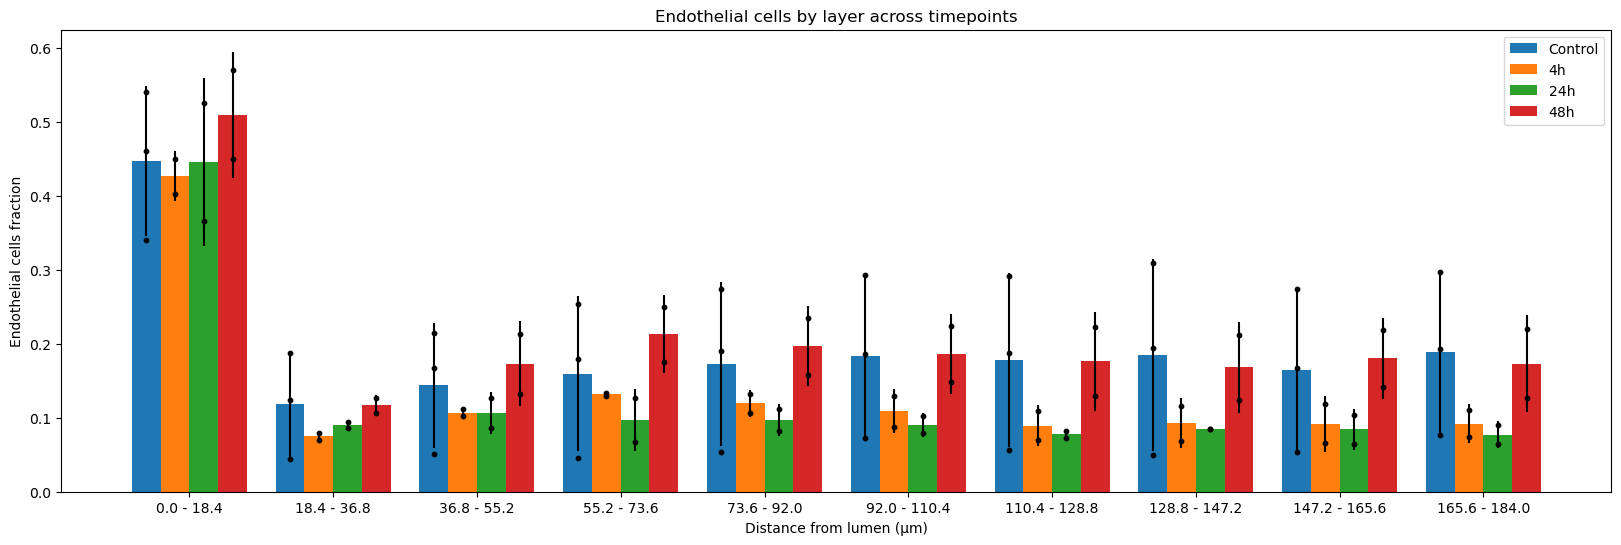

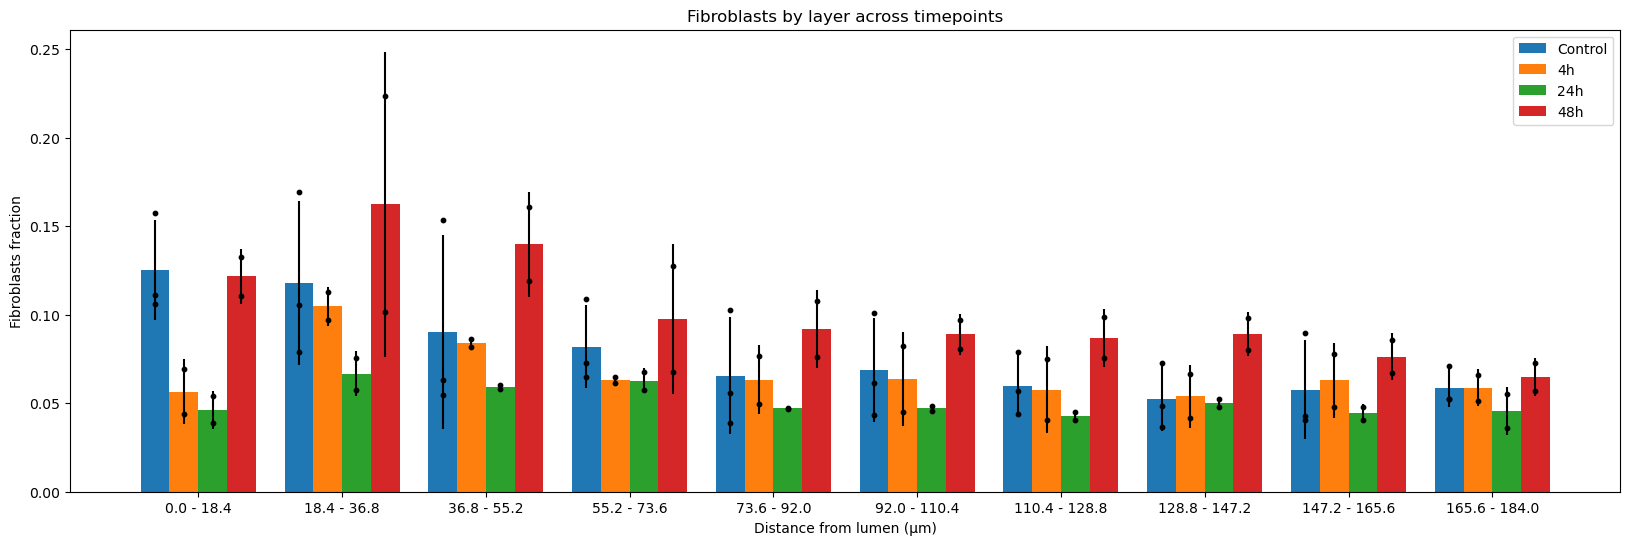

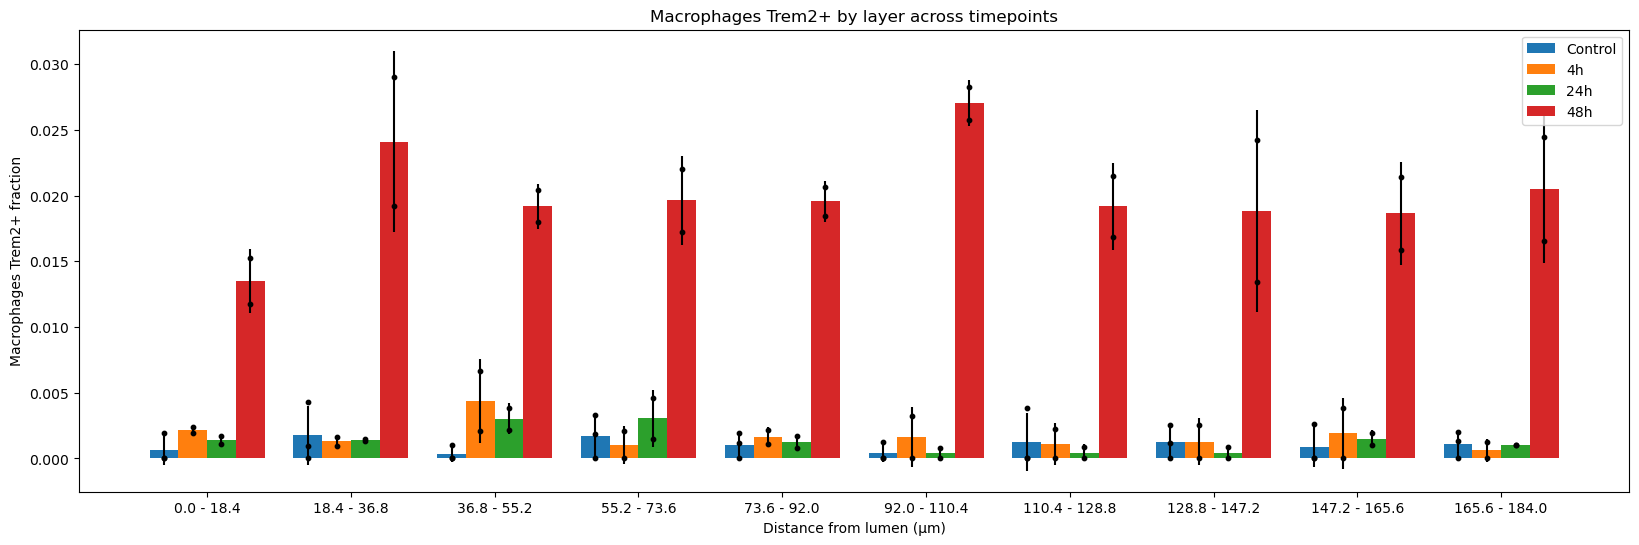

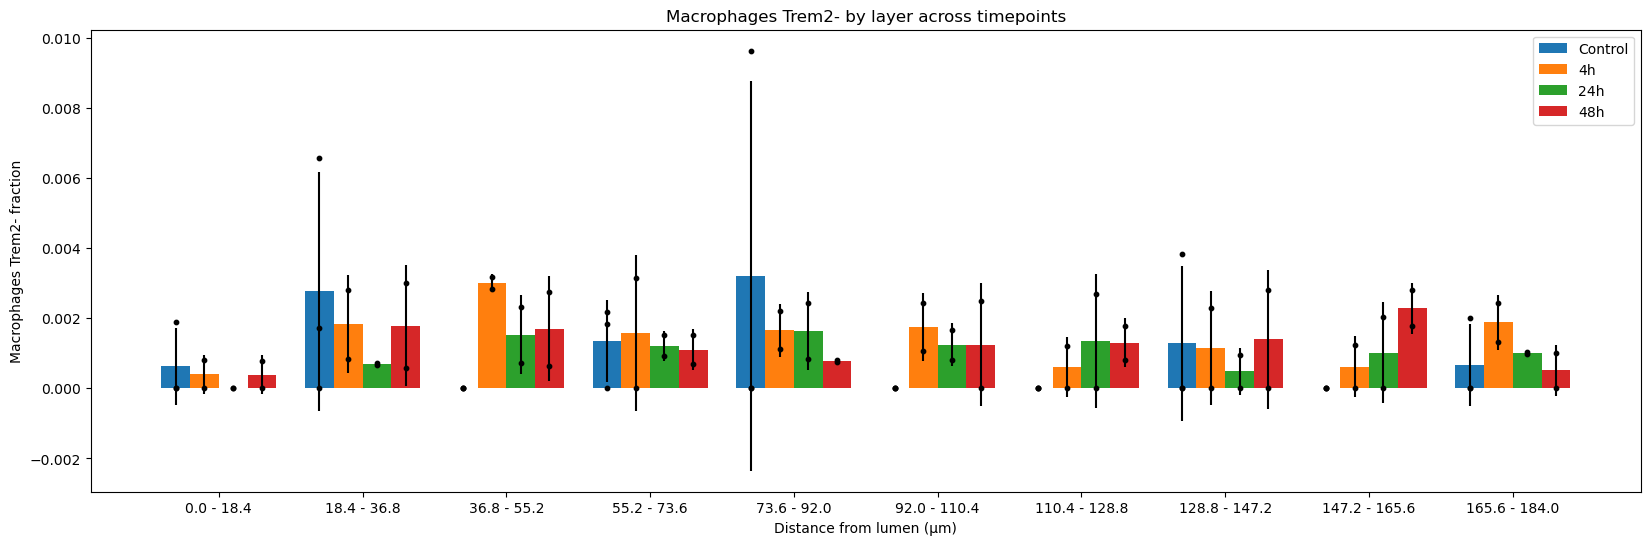

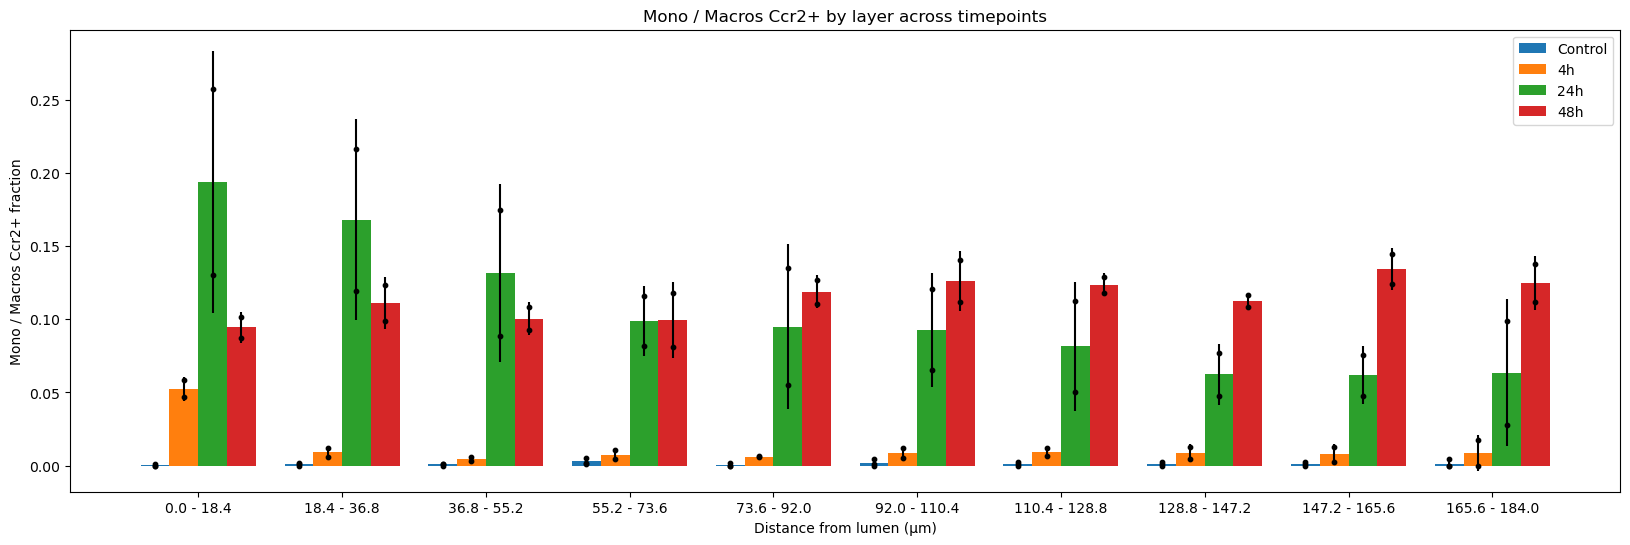

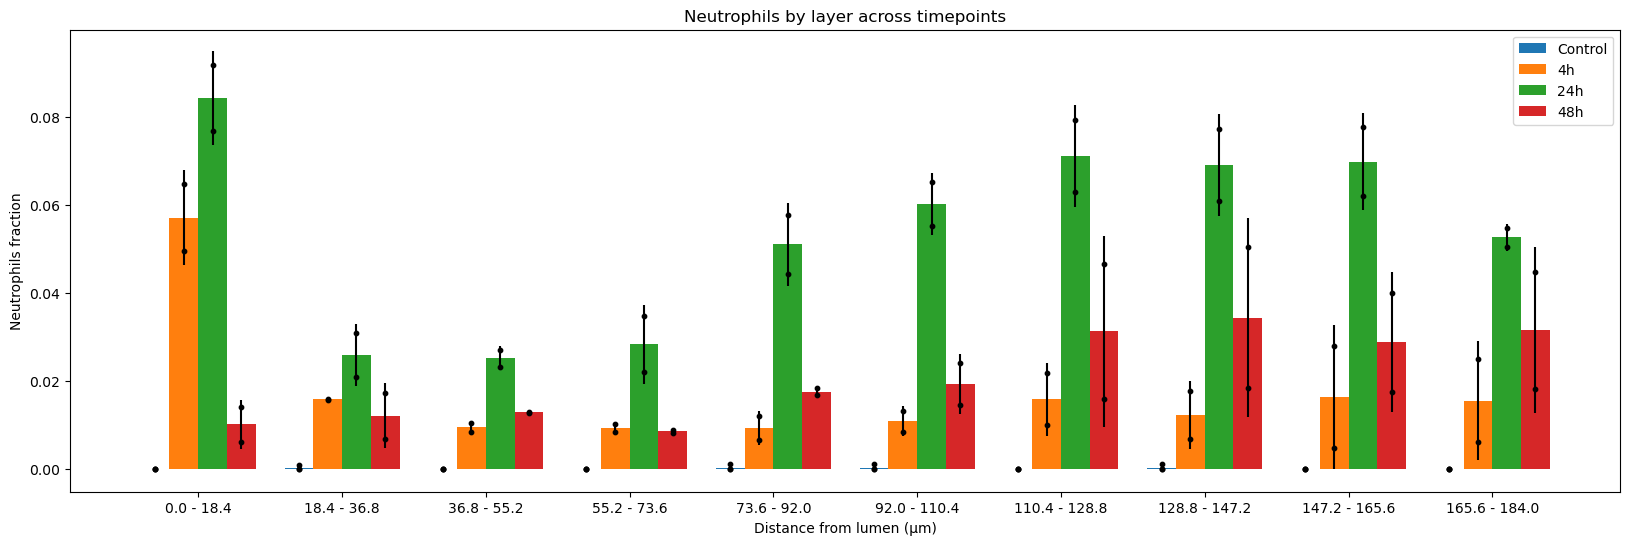

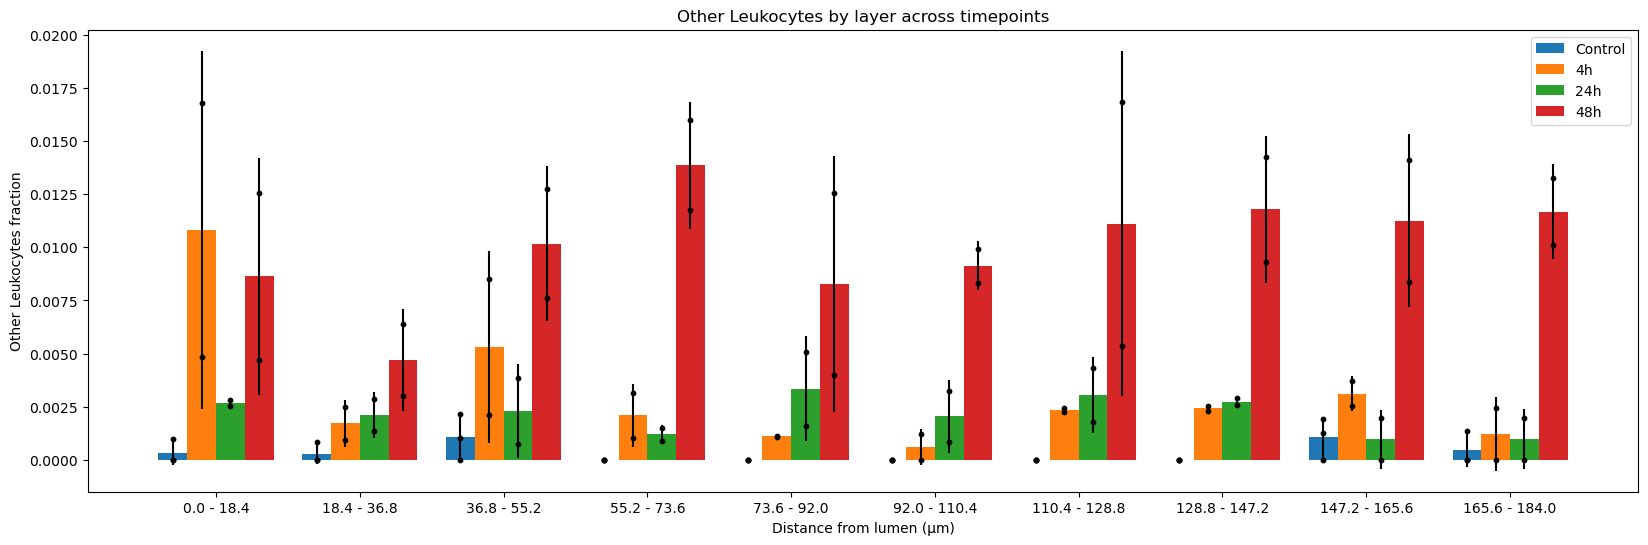

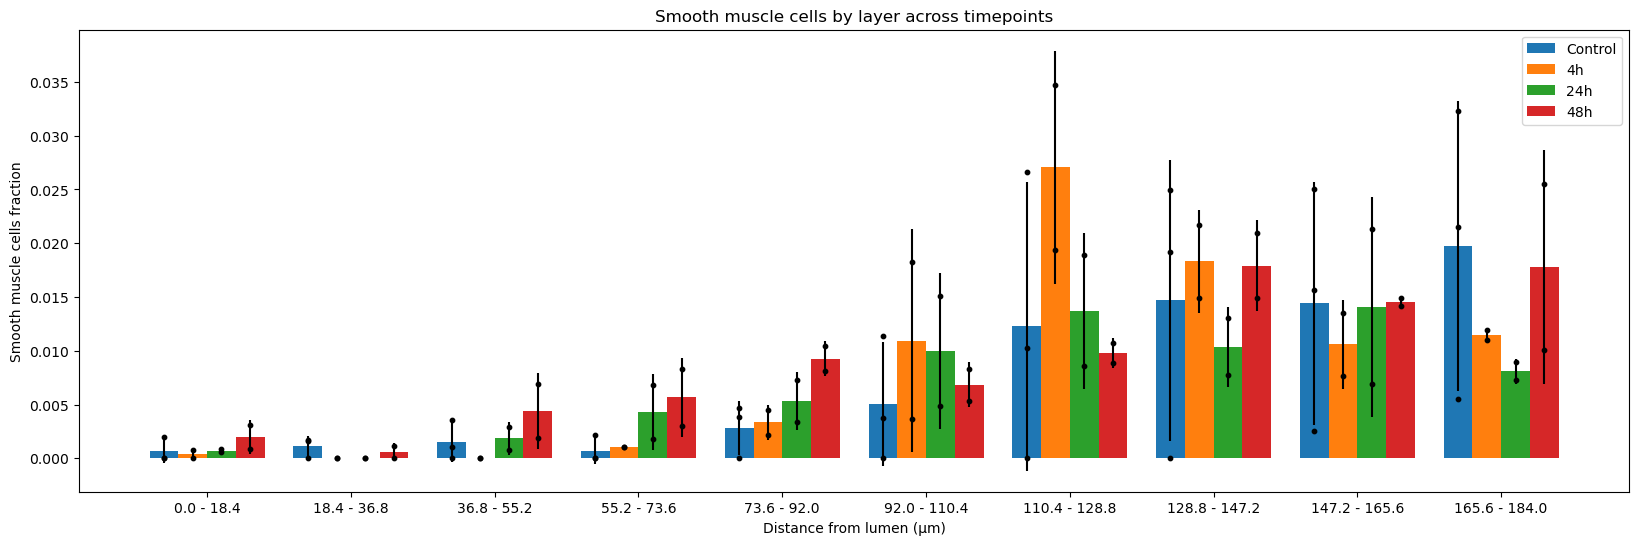

In [189]:
layer_df_subset = layer_df_combined_all[layer_df_combined_all['layer_value'] <= 10]
for column in layer_df_subset.columns[columns_list]:
    plot_one_column_across_all(column, layer_df_subset, error_bars=True, initial_values=True)

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/1867821640.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_means = combined_df.groupby(['layer_value', 'timepoint'])[column].mean().unstack()
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/1867821640.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['layer_value'] = combined_df['layer_value'].astype(int)
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/1867821640.py:4: FutureWarning: The default of observed=False is deprecated and wil

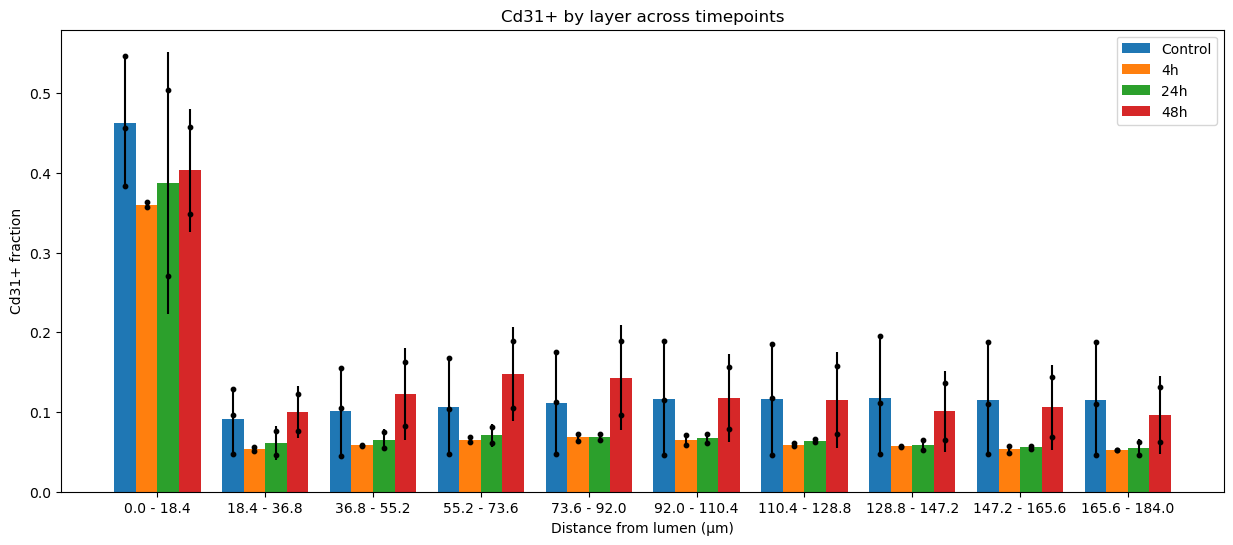

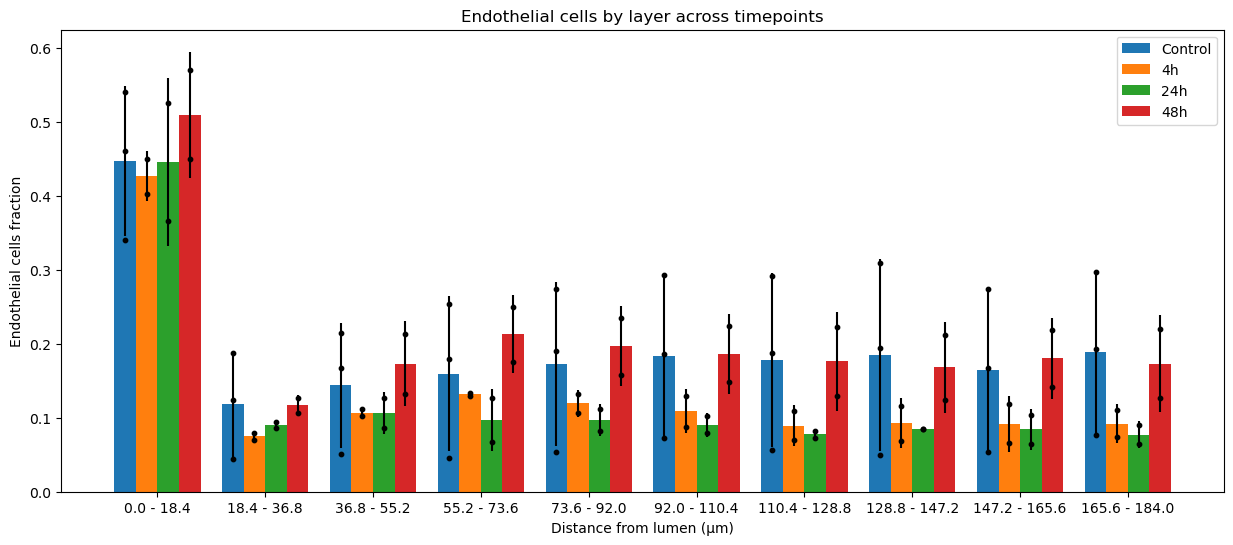

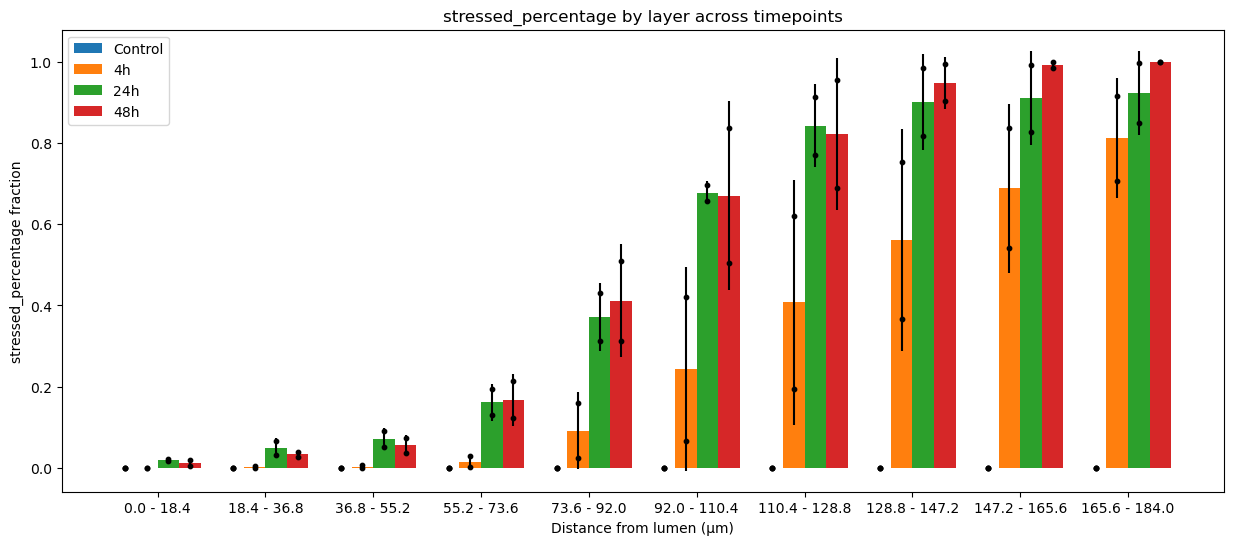

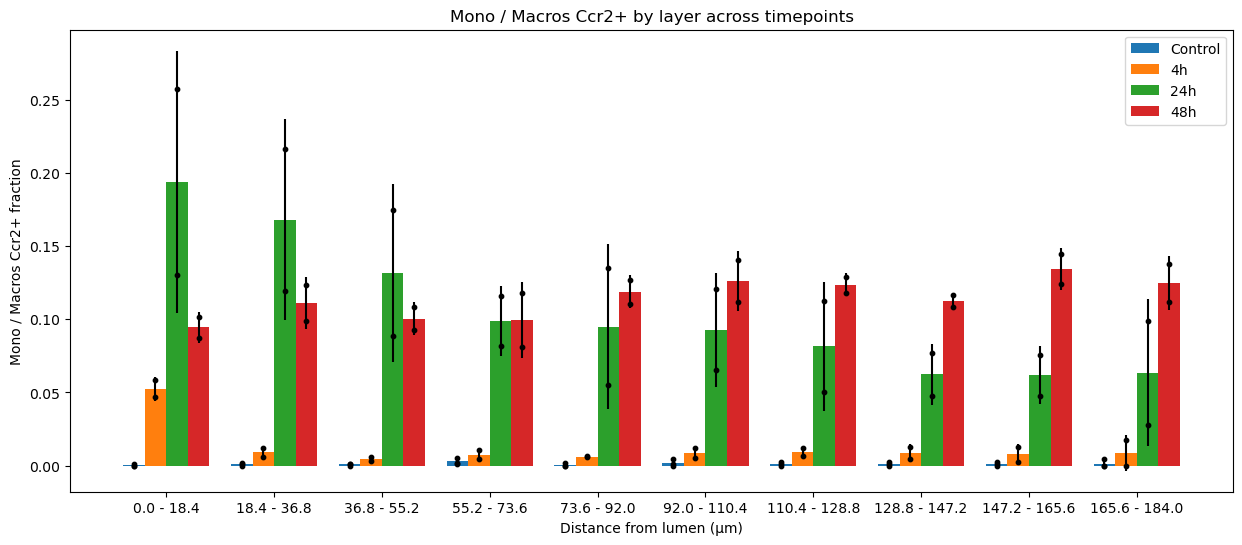

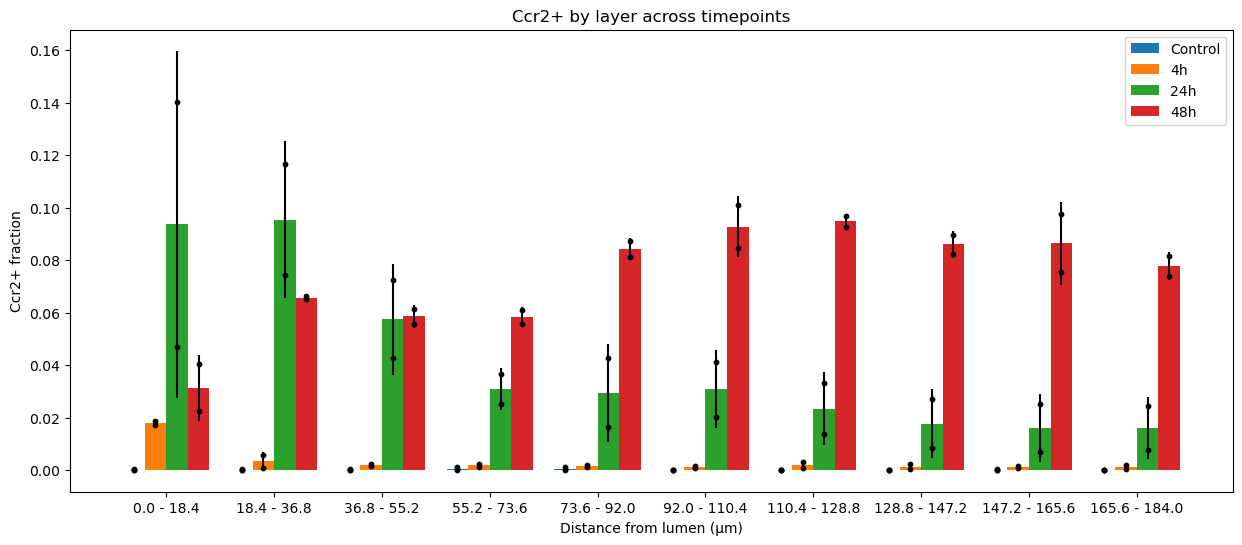

In [202]:
layer_df_subset = layer_df_combined_all[layer_df_combined_all['layer_value'] <= 10]
collist = ['Cd31+', 'Endothelial cells', 'stressed_percentage', 'Mono / Macros Ccr2+', 'Ccr2+']
for column in collist:
    plot_one_column_across_all(column, layer_df_subset, error_bars=True, initial_values=True)

In [411]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_with_error_bars(marker_columns, combined_df, plot_df=None):
    # Set up the figure
    plt.figure(figsize=(12, 8))
    
    # Define colors and markers for different time points
    timepoints = ['Control', '4h', '24h', '48h']
    colors = ['blue', 'orange', 'green', 'red']
    markers = ['o', 's', 'D', '^']
    
    # Define an offset step
    offset_step = 0.1
    
    for marker_column in marker_columns:
        for i, timepoint in enumerate(timepoints):
            # Filter the data for the current time point
            timepoint_data = combined_df[combined_df['timepoint'] == timepoint]
            
            # Calculate mean and std for each layer
            means = timepoint_data.groupby('layer_value')[marker_column].mean()
            stds = timepoint_data.groupby('layer_value')[marker_column].std()
            
            # Apply an offset to the x positions
            x_positions = means.index + (i * offset_step)
            
            # Plot the data with error bars
            plt.errorbar(x_positions, means, yerr=stds, label=f'{marker_column} - {timepoint}',
                         color=colors[i], marker=markers[i], linestyle='-', capsize=5)
    
    # Customize the plot
    plt.xlabel('Layer', fontsize=14)
    plt.ylabel(f'{marker_columns[0]} fraction', fontsize=14)
    plt.title(f'{marker_columns[0]} fraction by Layer Across Time Points', fontsize=16)
    
    plt.grid(True)  # Add grid for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap

    if plot_df is not None:
        plt.axhline(y=plot_df.loc['BZ', 'Control'], color='blue', linestyle='--')
        plt.axhline(y=plot_df.loc['BZ', '4h'], color='orange', linestyle='--')
        plt.axhline(y=plot_df.loc['BZ', '24h'], color='green', linestyle='--')
        plt.axhline(y=plot_df.loc['BZ', '48h'], color='red', linestyle='--')
        plt.axhline(y=plot_df.loc['Epicardium', 'Control'], color='blue', linestyle=':')
        plt.axhline(y=plot_df.loc['Epicardium', '4h'], color='orange', linestyle=':')
        plt.axhline(y=plot_df.loc['Epicardium', '24h'], color='green', linestyle=':')
        plt.axhline(y=plot_df.loc['Epicardium', '48h'], color='red', linestyle=':')
    
    plt.legend(loc='upper right', fontsize=10, title='Markers, Timepoints, and Regions')


    # Show the plot
    plt.show()

In [415]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_with_error_bars(marker_columns, combined_df, plot_df=None):
    # Set up the figure
    plt.figure(figsize=(12, 8))
    
    # Define colors and markers for different time points
    timepoints = ['Control', '4h', '24h', '48h']
    colors = ['blue', 'orange', 'green', 'red']
    markers = ['o', 's', 'D', '^']
    
    # Define an offset step
    offset_step = 0.1
    
    # Initialize lists to store plot elements for the legend
    legend_elements = []
    
    for marker_column in marker_columns:
        for i, timepoint in enumerate(timepoints):
            # Filter the data for the current time point
            timepoint_data = combined_df[combined_df['timepoint'] == timepoint]
            
            # Calculate mean and std for each layer
            means = timepoint_data.groupby('layer_value')[marker_column].mean()
            stds = timepoint_data.groupby('layer_value')[marker_column].std()
            
            # Apply an offset to the x positions
            x_positions = means.index + (i * offset_step)
            
            # Plot the data with error bars
            line = plt.errorbar(x_positions, means, yerr=stds, label=f'{marker_column} - {timepoint}',
                                color=colors[i], marker=markers[i], linestyle='-', capsize=5)
            # Store the line for the legend
            legend_elements.append(line)
    
    # Customize the plot
    plt.xlabel('Layer', fontsize=14)
    plt.ylabel(f'{marker_columns[0]} fraction', fontsize=14)
    plt.title(f'{marker_columns[0]} fraction by Layer Across Time Points', fontsize=16)
    
    plt.grid(True)  # Add grid for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap

    # Add dashed and dotted lines for BZ and Epicardium if plot_df is provided
    if plot_df is not None:
        plt.axhline(y=plot_df.loc['BZ', 'Control'], color=colors[0], linestyle='--')
        plt.axhline(y=plot_df.loc['BZ', '4h'], color=colors[1],linestyle='--')
        plt.axhline(y=plot_df.loc['BZ', '24h'], color=colors[2], linestyle='--')
        plt.axhline(y=plot_df.loc['BZ', '48h'], color=colors[3], linestyle='--')
        plt.axhline(y=plot_df.loc['Epicardium', 'Control'], color=colors[0], linestyle=':')
        plt.axhline(y=plot_df.loc['Epicardium', '4h'], color=colors[1], linestyle=':')
        plt.axhline(y=plot_df.loc['Epicardium', '24h'], color=colors[2], linestyle=':')
        plt.axhline(y=plot_df.loc['Epicardium', '48h'], color=colors[3], linestyle=':')

        # Add BZ and Epicardium lines to the legend
        legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='BZ'))
        legend_elements.append(plt.Line2D([0], [0], color='black', linestyle=':', label='Epicardium'))
    
    # Add the legend with all the elements
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10, title='Markers, Timepoints, and Regions')

    # Show the plot
    plt.show()

# Example of how to use this function:
# combined_df = ...  # Your DataFrame containing the data
# plot_df = ...      # Optional DataFrame containing BZ and Epicardium values
# marker_columns = ['Cd31+', 'Ccr2+', 'Ankrd1+']
# plot_with_error_bars(marker_columns, combined_df, plot_df)


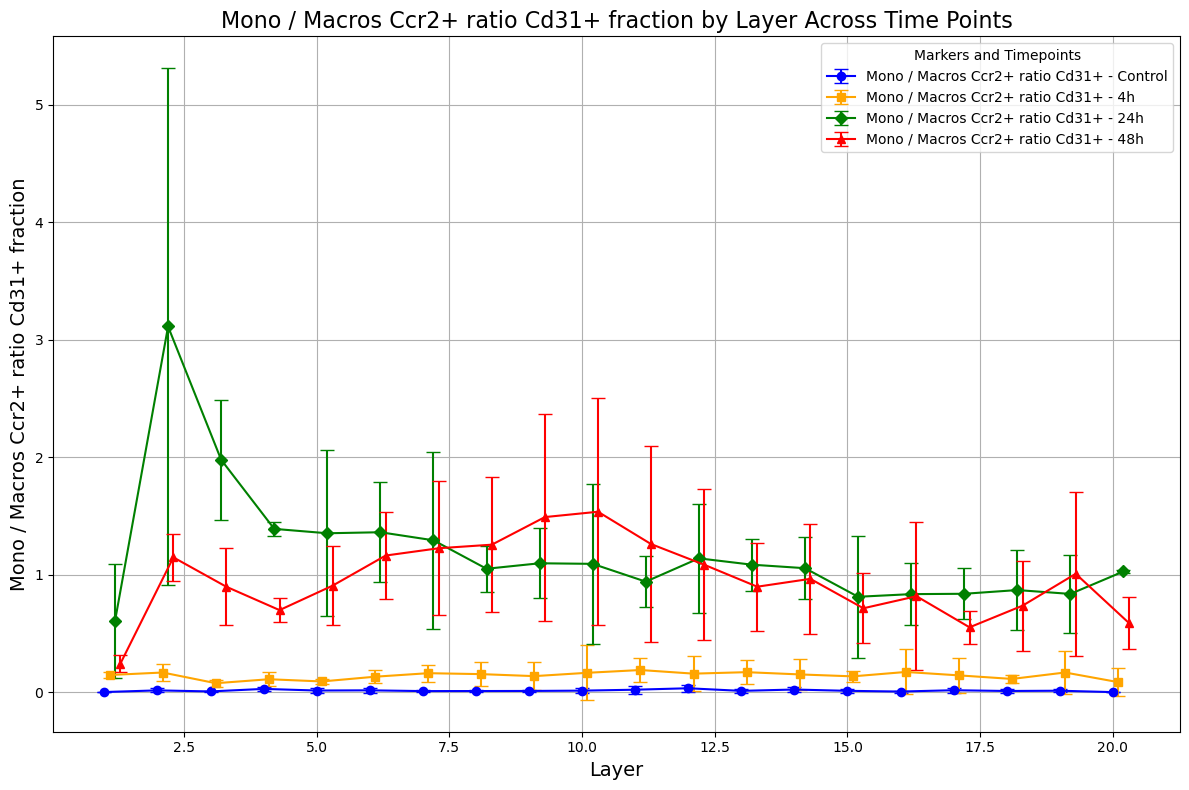

In [240]:
# Load your data (assuming it's in a DataFrame named 'combined_df')
layer_df_combined_all['Mono / Macros Ccr2+ ratio Cd31+'] = layer_df_combined_all['Mono / Macros Ccr2+']/layer_df_combined_all['Cd31+']
combined_df = layer_df_combined_all  # Assuming this is your loaded data

# Specify the marker columns you want to plot
marker_columns = ['Mono / Macros Ccr2+ ratio Cd31+']

# Call the function to plot the data
plot_with_error_bars(marker_columns, combined_df)

Let's assume the ratio of monocytes / macrophages expressing Ccr2 (percentage of cells) to Cd31 (percentage of pixels) only depends on the base infiltration rate - e.g. in a certain region, there is a base infiltration rate through the endothelial cells that can be quantified with the above ratio. At different time points, we expect a different base infiltration rate as the injury progresses. If we assume the infiltration through microvasculature to be constant, by approximating the base infiltration in regions the infiltration is known to happen - infarct region (CHECK BORDER ZONE perhaps!!) - we can check for increases indicating additional infiltration .

In [242]:

layer_df_combined_all[layer_df_combined_all['sample'] == 'Control_12']

layer_value   Ankrd1+      Mpo+     aSMA+   Pdgfra+     Cd45+  \
0             1  0.022669  0.001431  0.000000  0.081417  0.000009   
1             2  0.038490  0.008721  0.000000  0.049155  0.000030   
2             3  0.038294  0.010992  0.000068  0.028865  0.000169   
3             4  0.036831  0.011031  0.000142  0.030942  0.000032   
4             5  0.031296  0.011914  0.000192  0.026156  0.000000   
5             6  0.030838  0.010536  0.000080  0.023696  0.000318   
6             7  0.035371  0.012562  0.000439  0.022290  0.000221   
7             8  0.032386  0.012903  0.000958  0.020693  0.000000   
8             9  0.031911  0.010799  0.001404  0.016979  0.000209   
9            10  0.027872  0.011581  0.001763  0.017479  0.000199   
10           11  0.030981  0.012281  0.001661  0.021694  0.000022   
11           12  0.031370  0.012028  0.000982  0.017441  0.000030   
12           13  0.028295  0.009489  0.001083  0.018598  0.000000   
13           14  0.030059  0.012294  0.000150  0.020237  0.000000   
14           15  0.030934  0.010208  0.001120  0.019192  0.000000   
15           16  0.026700  0.011645  0.002182  0.021519  0.000000   
16           17  0.027997  0.012257  0.001582  0.021078  0.000024   
17           18  0.028819  0.010185  0.004114  0.019696  0.000089   
18           19  0.026619  0.010305  0.003696  0.019002  0.000056   
19           20  0.028034  0.009092  0.004413  0.016174  0.000031   

           Ccr2+    Trem2+     Cd31+    Tnnt2+  ...  Fibroblasts  \
0   6.223991e-07  0.000000  0.456029  0.367967  ...     0.111347   
1   7.459558e-05  0.000017  0.096635  0.792337  ...     0.105263   
2   1.465007e-05  0.000001  0.105027  0.795111  ...     0.054466   
3   9.109512e-06  0.000000  0.103422  0.802516  ...     0.072448   
4   4.352119e-05  0.000000  0.112886  0.808375  ...     0.055620   
5   4.907617e-05  0.000000  0.114947  0.810216  ...     0.061590   
6   4.452679e-05  0.000000  0.117835  0.803773  ...     0.057013   
7   1.229023e-05  0.000000  0.111738  0.814178  ...     0.048555   
8   3.702307e-05  0.000000  0.110015  0.821720  ...     0.042821   
9   1.163181e-05  0.000000  0.110157  0.822825  ...     0.052342   
10  1.191226e-05  0.000000  0.113690  0.809940  ...     0.054393   
11  6.021691e-05  0.000000  0.105895  0.827685  ...     0.037209   
12  2.523358e-05  0.000000  0.099523  0.839277  ...     0.058085   
13  2.624274e-04  0.000000  0.113603  0.818242  ...     0.051005   
14  2.939108e-05  0.000000  0.106816  0.827015  ...     0.052724   
15  1.662384e-05  0.000000  0.112286  0.818818  ...     0.062500   
16  5.312645e-06  0.000000  0.118555  0.809764  ...     0.055105   
17  4.532333e-06  0.000000  0.116850  0.808052  ...     0.035235   
18  1.316015e-05  0.000000  0.118902  0.803684  ...     0.038270   
19  3.321999e-05  0.000000  0.122967  0.806207  ...     0.037801   

    Macrophages Trem2+  Macrophages Trem2-  Mono / Macros Ccr2+  Neutrophils  \
0             0.000000                 0.0             0.000000     0.000000   
1             0.000957                 0.0             0.000957     0.000957   
2             0.000000                 0.0             0.001089     0.000000   
3             0.000000                 0.0             0.001098     0.000000   
4             0.001159                 0.0             0.000000     0.001159   
5             0.000000                 0.0             0.004479     0.000000   
6             0.000000                 0.0             0.002281     0.000000   
7             0.001156                 0.0             0.002312     0.001156   
8             0.000000                 0.0             0.002519     0.000000   
9             0.000000                 0.0             0.004132     0.000000   
10            0.000000                 0.0             0.006974     0.000000   
11            0.000000                 0.0             0.006202     0.000000   
12            0.000000                 0.0             0.003140     0.000000   
13   

# BORDER ZONE QUANTIFICATIONS

Border zone is 5, Epicardium is 7 in region masks

In [243]:
population_pixel_mask = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/pixel_masks/population_pixel_mask.csv')

def calculate_pixel_percentage_per_layer(layer, layers_input_mask, pixel_population_csv, pixel_mask):
    layer_mask = layers_input_mask == layer
    out_list = []
    for region_id in pixel_population_csv.region_id.unique():
        px_region_mask = pixel_mask == region_id
        out_list.append(np.sum(np.logical_and(layer_mask, px_region_mask))/np.sum(layer_mask))
    return out_list

In [251]:
for sample in sample_list:
    sample_final_name = sample_list_final[sample_list.index(sample)]

    pixel_map_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/pixel_masks/{sample_final_name}.pixel_mask.tiff'
    region_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_regions.tif'
    endocardium_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_endocardium.tif'
    lumen_layer_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/lumen_expanded_masks/{sample}_lumen_layers.tif'
    injury_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_injury.tif'

    # prepare a dataframe, each row will be a layer, each column will be a region_id
    layer_regions = pd.DataFrame(columns=population_pixel_mask.region_id.unique())

    pixel_map = tifffile.imread(pixel_map_path)
    region_mask = tifffile.imread(region_mask_path)
    
    target_list = [5, 7] # border zone and epicardium
    if "Control" in sample:
        target_list = [9, 7] # myocardium zone and epicardium

    for i, layer in enumerate(target_list):
        layer_regions.loc[i] = 0.0
        layer_regions.loc[i, :] = calculate_pixel_percentage_per_layer(layer, region_mask, population_pixel_mask, pixel_map)
    layer_regions.columns = population_pixel_mask.set_index('region_id').region_name

    layer_regions.to_csv(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/{sample}_other_regions.csv', index=False)

In [264]:
regions_df_combined = pd.DataFrame()
for sample in sample_list:
    region_df = pd.read_csv(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/{sample}_other_regions.csv')
    region_df['sample'] = sample
    region_df['timepoint'] = sample.split('_')[0]
    # layer value is 'BZ' if 0, 'epicardium' if 1
    region_df['layer_value'] = ['BZ', 'Epicardium']
    regions_df_combined = pd.concat([regions_df_combined, region_df])
regions_df_combined.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/regions_df_combined.csv', index=False)

In [344]:
region_cells = pd.DataFrame()
cell_type_list = cell_data.cell_meta_cluster.unique()
for sample in sample_list:

    sample_final_name = sample_list_final[sample_list.index(sample)]

    pixel_map_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/pixel_masks/{sample_final_name}.pixel_mask.tiff'
    region_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_regions.tif'
    endocardium_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_endocardium.tif'
    lumen_layer_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/lumen_expanded_masks/{sample}_lumen_layers.tif'
    injury_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_injury.tif'

    cell_data_subset = cell_data[cell_data['fov'] == sample]
    region_mask = tifffile.imread(region_mask_path)

    # prepare a dataframe, each row will be a layer, each column will be a region_id
    region_df = pd.DataFrame(columns=cell_type_list)

    unique_values_in_cell_data = cell_data_subset.cell_meta_cluster.unique()

    def calculate_region_value(x, y, region_mask):
        return region_mask[y, x]

    cell_data_subset['layer_value'] = cell_data_subset.apply(lambda x: calculate_region_value(x=np.rint(x['X_centroid']).astype(int), y=np.rint(x['Y_centroid']).astype(int), region_mask=region_mask), axis=1)
    cell_data_subset = cell_data_subset[cell_data_subset['layer_value'].isin([5, 7, 9])]
    # layer value as type str
    cell_data_subset['layer_value'] = cell_data_subset['layer_value'].astype(str)
    cell_data_subset.loc[cell_data_subset['layer_value'] == '9', 'layer_value'] = 'BZ'
    cell_data_subset.loc[cell_data_subset['layer_value'] == '7', 'layer_value'] = 'Epicardium'
    cell_data_subset.loc[cell_data_subset['layer_value'] == '5', 'layer_value'] = 'BZ'

    cell_df = cell_data_subset.groupby('layer_value')['cell_meta_cluster'].value_counts().unstack()

    cell_df = cell_df.fillna(0)
    cell_df = cell_df.astype(int)
    cell_df = cell_df.div(cell_data_subset.layer_value.value_counts(), axis=0)
    cell_df['sample'] = sample
    cell_df.columns = cell_df.columns.values
    cell_df['layer_value'] = cell_df.index
    cell_df.reset_index(drop=True, inplace=True)
    region_cells = pd.concat([region_cells, cell_df])

region_cells = region_cells.fillna(0)

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/156843082.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['layer_value'] = cell_data_subset.apply(lambda x: calculate_region_value(np.rint(x['X_centroid']).astype(int), np.rint(x['Y_centroid']).astype(int), region_mask), axis=1)
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/156843082.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['layer_value'] = cell_data_subset.apply(lambda x: c

In [338]:
region_cells.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/region_cells_BZ_Epicardium.csv', index=False)

In [346]:
regions_df_combined_all = pd.merge(regions_df_combined, region_cells, on=['layer_value', 'sample'], how='left')
regions_df_combined_all.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/regions_df_combined_all.csv', index=False)

In [349]:
combined_df

Ankrd1+      Mpo+     aSMA+   Pdgfra+     Cd45+     Ccr2+    Trem2+  \
0   0.034858  0.011797  0.000472  0.013810  0.000084  0.000115  0.000000   
1   0.050014  0.014354  0.000963  0.034215  0.000511  0.000555  0.001079   
2   0.003741  0.000340  0.005993  0.046078  0.000112  0.001183  0.000052   
3   0.021429  0.002507  0.009047  0.061358  0.000768  0.001658  0.001221   
4   0.000492  0.000205  0.015366  0.013603  0.000028  0.000103  0.000003   
5   0.002673  0.000387  0.009403  0.042891  0.000174  0.000556  0.004426   
6   0.068072  0.012561  0.003873  0.009570  0.001618  0.000290  0.000000   
7   0.188085  0.025678  0.000982  0.032361  0.003131  0.002246  0.000143   
8   0.013948  0.003403  0.003761  0.013059  0.001003  0.000735  0.000139   
9   0.048840  0.016683  0.005971  0.023629  0.001305  0.001958  0.000250   
10  0.023466  0.009312  0.006527  0.041571  0.000791  0.019718  0.000762   
11  0.040238  0.049166  0.015973  0.034854  0.001712  0.020842  0.000577   
12  0.019074  0.003597  0.001549  0.016622  0.000227  0.003881  0.000004   
13  0.040420  0.051270  0.006262  0.021529  0.000362  0.017814  0.000924   
14  0.018281  0.005553  0.010780  0.042065  0.001843  0.011381  0.006401   
15  0.053623  0.056580  0.002818  0.051087  0.006456  0.056743  0.012836   
16  0.020453  0.003736  0.008196  0.082402  0.003601  0.013779  0.009454   
17  0.177370  0.039299  0.007066  0.114193  0.010202  0.035679  0.008528   

       Cd31+    Tnnt2+     Cd68+  ...  Fibroblasts  Macrophages Trem2+  \
0   0.177395  0.745977  0.000124  ...     0.031992            0.000000   
1   0.088337  0.746582  0.000839  ...     0.058088            0.001614   
2   0.150187  0.788012  0.000941  ...     0.079703            0.000990   
3   0.158872  0.682604  0.001465  ...     0.079839            0.004017   
4   0.061675  0.903499  0.001646  ...     0.035938            0.001141   
5   0.053723  0.855576  0.001501  ...     0.085550            0.006470   
6   0.058337  0.831049  0.000647  ...     0.031562            0.000799   
7   0.084592  0.635721  0.002497  ...     0.039411            0.004764   
8   0.085732  0.874844  0.000702  ...     0.035331            0.001342   
9   0.079164  0.802995  0.001261  ...     0.036328            0.001172   
10  0.093032  0.786904  0.002465  ...     0.083593            0.004154   
11  0.116071  0.571986  0.002018  ...     0.051399            0.002545   
12  0.058189  0.893807  0.000472  ...     0.052767            0.000000   
13  0.088315  0.759531  0.001458  ...     0.033701            0.003889   
14  0.105768  0.744847  0.008641  ...     0.064682            0.027721   
15  0.107420  0.562531  0.021823  ...     0.071786            0.040067   
16  0.205332  0.621815  0.005440  ...     0.121342            0.028194   
17  0.190698  0.343564  0.009293  ...     0.117711            0.022678   

   Mono / Macros Ccr2+ Neutrophils Other Leukocytes  Smooth muscle cells  \
0             0.006708    0.000000         0.000000             0.001548   
1             0.006454    0.001614         0.001614             0.000000   
2             0.001980    0.000495         0.000000             0.017327   
3             0.003515    0.000000         0.003013             0.017826   
4             0.000285    0.000000         0.000000             0.036794   
5             0.001438    0.000000         0.000719             0.019410   
6             0.003596    0.005993         0.005593             0.014383   
7             0.014292    0.025552         0.006929             0.001299   
8             0.005814    0.005367         0.003578             0.012075   
9             0.015625    0.021484         0.003906             0.013672   
10            0.079439    0.011423         0.002596             0.023884   
11            0.075827    0.058524         0.004071             0.024936   
12            0.019949    0.001287         0.000000             0.005148   
13            0.056384    0.062865         0.000648             0.010369   
14           

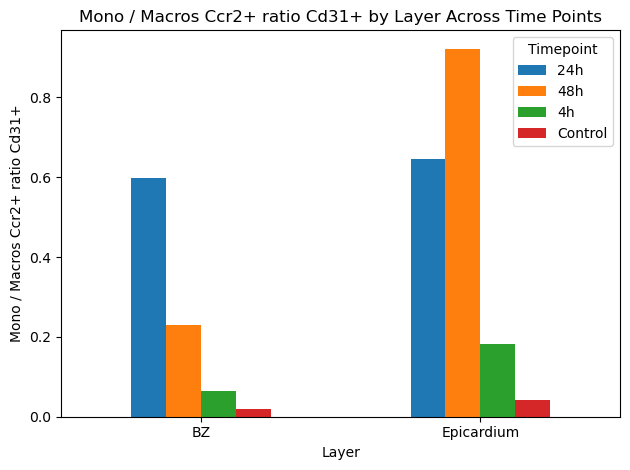

In [391]:
# Load your data (assuming it's in a DataFrame named 'combined_df')
regions_df_combined_all['Mono / Macros Ccr2+ ratio Cd31+'] = regions_df_combined_all['Mono / Macros Ccr2+']/regions_df_combined_all['Cd31+']
combined_df = regions_df_combined_all  # Assuming this is your loaded data

# Specify the marker columns you want to plot
marker_columns = ['Mono / Macros Ccr2+ ratio Cd31+']

# make a barplot of combined_df for marker_column - group by layer_value and timepoint
plot_data = combined_df.groupby(['layer_value', 'timepoint'])['Mono / Macros Ccr2+ ratio Cd31+'].mean().unstack()
plot_data.plot(kind='bar', yerr=combined_df.groupby(['layer_value', 'timepoint'])['Mono / Macros Ccr2+ ratio Cd31+'].std())
plt.xlabel('Layer')
plt.ylabel('Mono / Macros Ccr2+ ratio Cd31+')
plt.title('Mono / Macros Ccr2+ ratio Cd31+ by Layer Across Time Points')
plt.legend(title='Timepoint')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# add error bars




In [395]:
plot_data.loc['BZ', 'Control']

0.018541087323989108

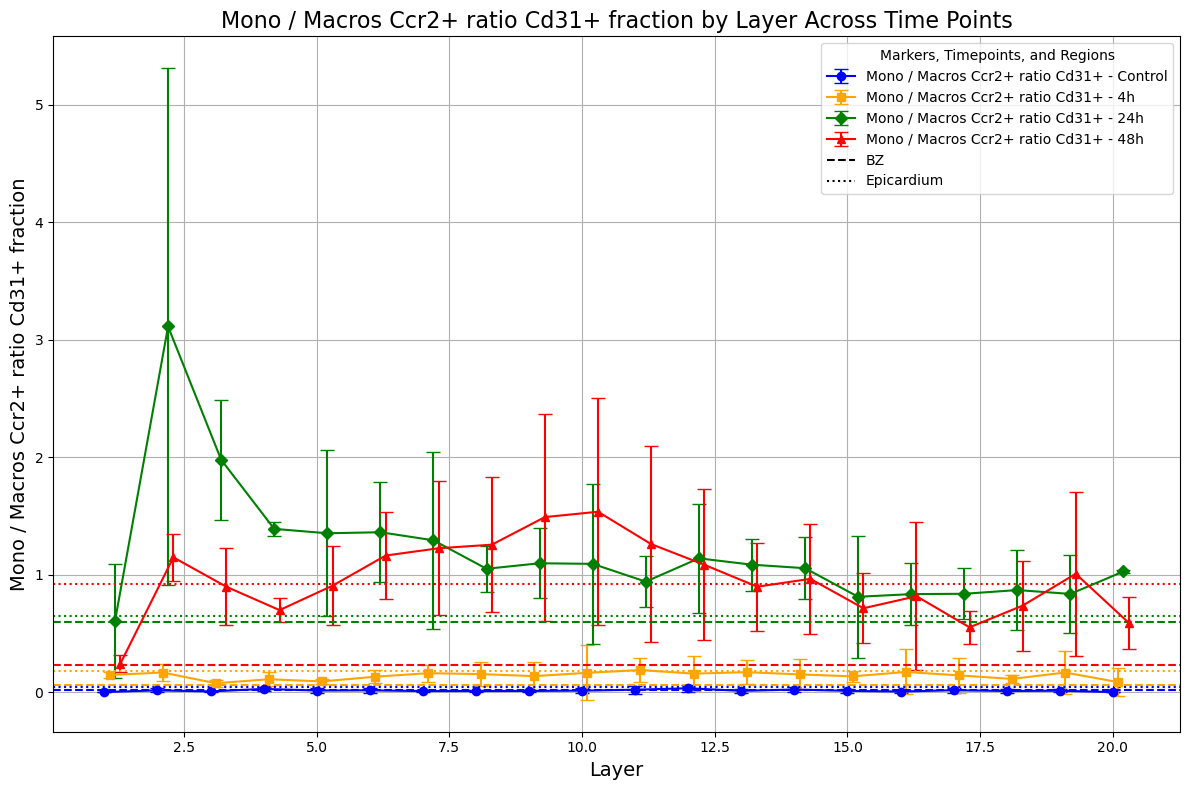

In [416]:
# Load your data (assuming it's in a DataFrame named 'combined_df')
layer_df_combined_all['Mono / Macros Ccr2+ ratio Cd31+'] = layer_df_combined_all['Mono / Macros Ccr2+']/layer_df_combined_all['Cd31+']
combined_df = layer_df_combined_all  # Assuming this is your loaded data

# Specify the marker columns you want to plot
marker_columns = ['Mono / Macros Ccr2+ ratio Cd31+']

# Call the function to plot the data
plot_with_error_bars(marker_columns, combined_df, plot_data)

## Get CCR2 numbers / Cd31+ area

In [424]:
regions_df_combined_all = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/regions_df_combined_all.csv')

In [502]:
cell_data_in_mask = cell_data[cell_data.cell_meta_cluster != 'out_of_mask']
cell_type_list = cell_data_in_mask.cell_meta_cluster.unique()
pixel_size = 0.23
layer_df_combined_cells = pd.DataFrame()
for sample in sample_list:
    sample_final_name = sample_list_final[sample_list.index(sample)]

    pixel_map_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/pixel_masks/{sample_final_name}.pixel_mask.tiff'
    region_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_regions.tif'
    endocardium_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_endocardium.tif'
    lumen_layer_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/lumen_expanded_masks/{sample}_lumen_layers.tif'
    injury_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_injury.tif'

    cell_data_subset = cell_data_in_mask[cell_data_in_mask['fov'] == sample]
    layers = tifffile.imread(lumen_layer_path)

    unique_values_in_layers = np.unique(layers)
    unique_values_in_cell_data = cell_data_subset.cell_meta_cluster.unique()

    pixel_map = tifffile.imread(pixel_map_path)
    region_mask = tifffile.imread(region_mask_path)
    epicardium_cd31 = np.sum(np.logical_and(region_mask == 7, pixel_map == 18))

    if 'Control' not in sample:
        CM_mask = tifffile.imread(injury_mask_path)
        # CM_mask has value 2 for infarct core which should be included in this analysis.
        # region mask has the Endocardium annotated as 2, which should be included in this analysis
        binary_target_mask = np.logical_or(region_mask == 2, CM_mask == 2)
        border_zone_area = np.sum(region_mask==5)
        layers = layers * binary_target_mask
        border_zone_cd31 = np.sum(np.logical_and(region_mask == 5, pixel_map == 18))
    else:
        border_zone_area = np.sum(region_mask==9)
        border_zone_cd31 = np.sum(np.logical_and(region_mask == 9, pixel_map == 18))
    epicardium_area = np.sum(region_mask==7)
    epicardium_cd31 = np.sum(np.logical_and(region_mask == 7, pixel_map == 18))


    def calculate_layer_value(x, y, layers_mask):
        return layers_mask[y, x]

    cell_data_subset['region_value'] = cell_data_subset.apply(lambda x: calculate_layer_value(np.rint(x['X_centroid']).astype(int), np.rint(x['Y_centroid']).astype(int), region_mask), axis=1)
    cell_data_subset['layer_value'] = cell_data_subset.apply(lambda x: calculate_layer_value(np.rint(x['X_centroid']).astype(int), np.rint(x['Y_centroid']).astype(int), layers), axis=1)

    # region value 9 should be BZ, region value 7 should be epicardium
    cell_data_subset.loc[cell_data_subset['region_value'] == 9, 'region_value'] = 'BZ'
    cell_data_subset.loc[cell_data_subset['region_value'] == 7, 'region_value'] = 'Epicardium'
    cell_data_subset.loc[cell_data_subset['region_value'] == 5, 'region_value'] = 'BZ'

    layer_values = cell_data_subset.layer_value.unique()
    layer_values.sort()

    layer_df = pd.DataFrame(columns=['layer_values', 'sample', 'cell_count', 'area_px', 'area_um2', 'ccr2_cell_count', 'ccr2_cell_percentage', 'Cd31+area', 'Cd31+area_um2', 'Cd31+area_percentage'])
    for layer_value in layer_values:
        area = np.sum(layers == layer_value)
        area_um2 = area * pixel_size**2
        cell_count = cell_data_subset[cell_data_subset['layer_value'] == layer_value].shape[0]
        ccr2_cell_count = cell_data_subset[(cell_data_subset['layer_value'] == layer_value) & (cell_data_subset['cell_meta_cluster'] == 'Mono / Macros Ccr2+')].shape[0]
        cd31_area = np.sum(np.logical_and(layers == layer_value, pixel_map == 18))
        cd31_area_um2 = cd31_area * pixel_size**2
        layer_df = pd.concat([layer_df, 
                            pd.DataFrame({'layer_values': layer_value, 
                                            'sample': sample, 
                                            'cell_count': cell_count,
                                            'area_px': area,
                                            'area_um2': area_um2,
                                            'ccr2_cell_count': ccr2_cell_count,
                                            'ccr2_cell_percentage': ccr2_cell_count/cell_count,
                                            'Cd31+area': cd31_area,
                                            'Cd31+area_um2': cd31_area_um2,
                                            'Cd31+area_percentage': cd31_area/area,
                                            'Ccr2 infiltration rate': ccr2_cell_count/cd31_area_um2
                                            }, 
                                        index=[0])])
    layer_df = pd.concat([layer_df, 
                        pd.DataFrame({'layer_values': 'BZ', 
                                        'sample': sample, 
                                        'cell_count': cell_data_subset[cell_data_subset['region_value'] == 'BZ'].shape[0],
                                        'area_px': border_zone_area,
                                        'area_um2': border_zone_area*pixel_size**2,
                                        'ccr2_cell_count': cell_data_subset[(cell_data_subset['region_value'] == 'BZ') & (cell_data_subset['cell_meta_cluster'] == 'Mono / Macros Ccr2+')].shape[0],
                                        'ccr2_cell_percentage': cell_data_subset[(cell_data_subset['region_value'] == 'BZ') & (cell_data_subset['cell_meta_cluster'] == 'Mono / Macros Ccr2+')].shape[0] / cell_data_subset[cell_data_subset['region_value'] == 'BZ'].shape[0],
                                        'Cd31+area': border_zone_cd31,
                                        'Cd31+area_um2': border_zone_cd31 * pixel_size**2,
                                        'Cd31+area_percentage': border_zone_cd31 / border_zone_area,
                                        'Ccr2 infiltration rate': cell_data_subset[(cell_data_subset['region_value'] == 'BZ') & (cell_data_subset['cell_meta_cluster'] == 'Mono / Macros Ccr2+')].shape[0] / (border_zone_cd31 * pixel_size**2),
                                        },
                                    index=[0])])
    layer_df = pd.concat([layer_df, 
                        pd.DataFrame({'layer_values': 'Epicardium', 
                                        'sample': sample, 
                                        'cell_count': cell_data_subset[cell_data_subset['region_value'] == 'Epicardium'].shape[0],
                                        'area_px': epicardium_area,
                                        'area_um2': epicardium_area*pixel_size**2,
                                        'ccr2_cell_count': cell_data_subset[(cell_data_subset['region_value'] == 'Epicardium') & (cell_data_subset['cell_meta_cluster'] == 'Mono / Macros Ccr2+')].shape[0],
                                        'ccr2_cell_percentage': cell_data_subset[(cell_data_subset['region_value'] == 'Epicardium') & (cell_data_subset['cell_meta_cluster'] == 'Mono / Macros Ccr2+')].shape[0] / cell_data_subset[cell_data_subset['region_value'] == 'Epicardium'].shape[0],
                                        'Cd31+area': epicardium_cd31,
                                        'Cd31+area_um2': epicardium_cd31 * pixel_size**2,
                                        'Cd31+area_percentage': epicardium_cd31 / epicardium_area,
                                        'Ccr2 infiltration rate': cell_data_subset[(cell_data_subset['region_value'] == 'Epicardium') & (cell_data_subset['cell_meta_cluster'] == 'Mono / Macros Ccr2+')].shape[0] / (epicardium_cd31 * pixel_size**2),
                                        },
                                    index=[0])])
    layer_df_combined_cells = pd.concat([layer_df_combined_cells, layer_df])
layer_df_combined_cells['timepoint'] = layer_df_combined_cells['sample'].str.split('_').str[0]
layer_df_combined_cells.reset_index(drop=True, inplace=True)

layer_df_combined_cells.loc[layer_df_combined_cells['layer_values'] == 'BZ', 'layer_values'] = 100
layer_df_combined_cells.loc[layer_df_combined_cells['layer_values'] == 'Epicardium', 'layer_values'] = 101
layer_df_combined_cells['layer_values'] = layer_df_combined_cells['layer_values'].astype(int)

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/438403178.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['region_value'] = cell_data_subset.apply(lambda x: calculate_layer_value(np.rint(x['X_centroid']).astype(int), np.rint(x['Y_centroid']).astype(int), region_mask), axis=1)
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/438403178.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['layer_value'] = cell_data_subset.apply(lambda x: c

In [648]:
def plot_all_with_error_bars(marker_columns, combined_df, plot_df=None, y_label=marker_columns[0], title=None):
    # Set up the figure
    plt.figure(figsize=(12, 8))
    
    # Define colors and markers for different time points
    timepoints = ['Control', '4h', '24h', '48h']
    colors = ['blue', 'orange', 'green', 'red']
    markers = ['o', 's', 'D', '^']
    
    # Define an offset step
    offset_step = 0.1
    
    # Initialize lists to store plot elements for the legend
    legend_elements = []
    
    for marker_column in marker_columns:
        for i, timepoint in enumerate(timepoints):
            # Filter the data for the current time point
            timepoint_data = combined_df[combined_df['timepoint'] == timepoint]
            
            # Calculate mean and std for each layer
            means = timepoint_data.groupby('layer_values')[marker_column].mean()
            stds = timepoint_data.groupby('layer_values')[marker_column].std()
            ses = stds/np.sqrt(timepoint_data.groupby('layer_values')[marker_column].count())
            
            # Apply an offset to the x positions
            x_positions = means.index + (i * offset_step)
            
            # Plot the data with error bars
            line = plt.errorbar(x_positions, means, yerr=ses, label=f'{marker_column} - {timepoint}',
                                    color=colors[i], marker=markers[i], linestyle='-', capsize=5)
            # Store the line for the legend
            legend_elements.append(line)
    
    # Customize the plot
    plt.xlabel('Layer', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.title(title, fontsize=16)
    
    plt.grid(True)  # Add grid for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap

    # Add dashed and dotted lines for BZ and Epicardium if plot_df is provided
    if plot_df is not None:
        plt.axhline(y=plot_df.loc['BZ', 'Control'], color=colors[0], linestyle='--')
        plt.axhline(y=plot_df.loc['BZ', '4h'], color=colors[1],linestyle='--')
        plt.axhline(y=plot_df.loc['BZ', '24h'], color=colors[2], linestyle='--')
        plt.axhline(y=plot_df.loc['BZ', '48h'], color=colors[3], linestyle='--')
        #plt.axhline(y=plot_df.loc['Epicardium', 'Control'], color=colors[0], linestyle=':')
        #plt.axhline(y=plot_df.loc['Epicardium', '4h'], color=colors[1], linestyle=':')
        #plt.axhline(y=plot_df.loc['Epicardium', '24h'], color=colors[2], linestyle=':')
        #plt.axhline(y=plot_df.loc['Epicardium', '48h'], color=colors[3], linestyle=':')

        # Add BZ and Epicardium lines to the legend
        legend_elements.append(plt.Line2D([0], [0], color='black', linestyle='--', label='BZ'))
        #legend_elements.append(plt.Line2D([0], [0], color='black', linestyle=':', label='Epicardium'))
    
    # Add the legend with all the elements
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10, title='Markers, Timepoints, and Regions')

    # Show the plot
    plt.show()

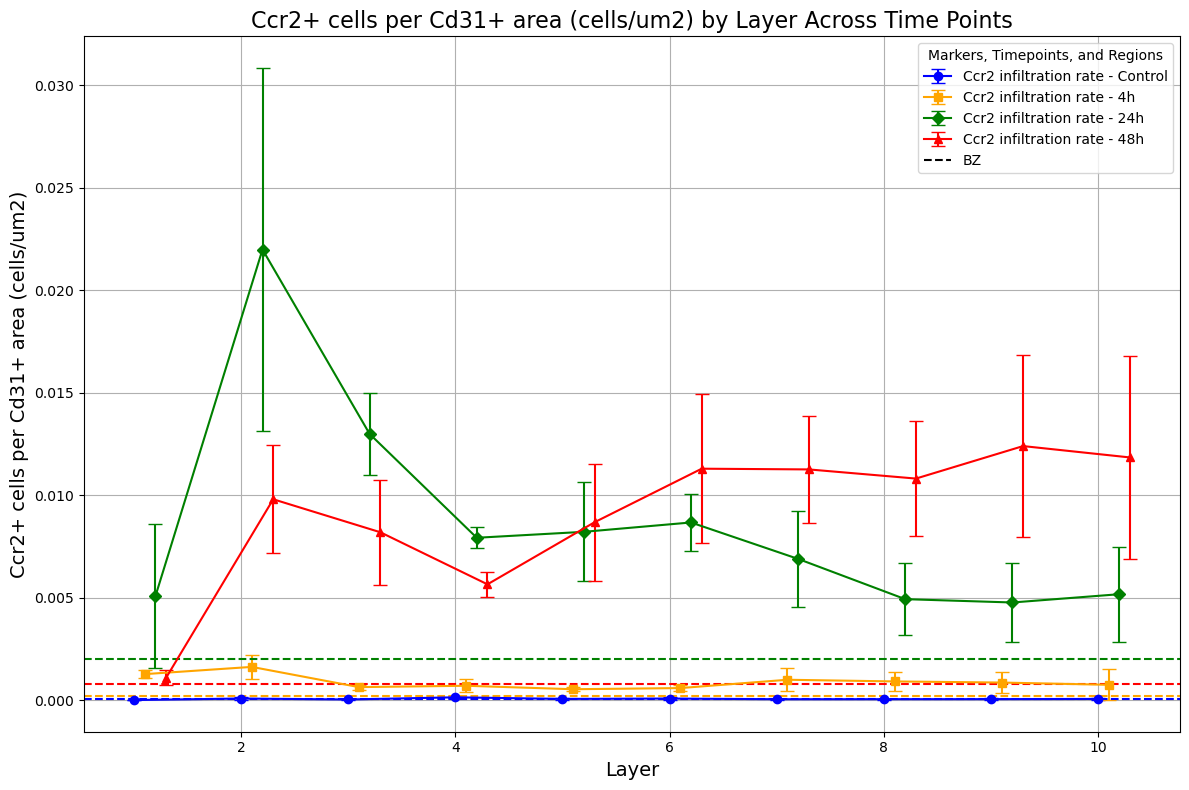

In [649]:
marker_column = 'Ccr2 infiltration rate'
plot_data = layer_df_combined_cells[layer_df_combined_cells['layer_values'].isin([100, 101])].groupby(['layer_values', 'timepoint'])[marker_column].mean().unstack()
plot_data.index = ['BZ', 'Epicardium']
# Call the function to plot the data
plot_all_with_error_bars([marker_column], 
                         layer_df_combined_cells[np.logical_and(layer_df_combined_cells['layer_values'] > 0, layer_df_combined_cells['layer_values'] <= 10)], 
                         plot_data,
                         y_label = 'Ccr2+ cells per Cd31+ area (cells/um2)',
                         title = 'Ccr2+ cells per Cd31+ area (cells/um2) by Layer Across Time Points')

In [578]:
layer_df_combined_cells.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/all_only_useful_ccr2_cd31.csv', index=False)

In [5]:
layer_df_combined_cells = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/layer_quantifications/all_only_useful_ccr2_cd31.csv')
border_zone_denominators = [item for sublist in [[layer_df_combined_cells[layer_df_combined_cells['layer_values'] == 100]['Ccr2 infiltration rate'].iloc[i]]*23 for i in range(len(layer_df_combined_cells[layer_df_combined_cells['layer_values'] == 100]))] for item in sublist]
layer_df_combined_cells['Ccr2 infiltration rate normalized'] = layer_df_combined_cells['Ccr2 infiltration rate'] / border_zone_denominators

In [9]:
def plot_all_with_bz_ratio(marker_columns, combined_df, plot_df=None, y_label=None, title=None):
    # Set up the figure
    plt.figure(figsize=(12, 8))
    
    # Define colors and markers for different time points
    timepoints = ['4h', '24h', '48h'] # 'Control'
    colors = ['orange', 'green', 'red'] # 'blue', 
    markers = ['o', 's', 'D', '^']
    
    # Define an offset step
    offset_step = 0.1
    
    # Initialize lists to store plot elements for the legend
    legend_elements = []
    
    for marker_column in marker_columns:
        for i, timepoint in enumerate(timepoints):
            # Filter the data for the current time point
            timepoint_data = combined_df[combined_df['timepoint'] == timepoint]
            
            # Calculate mean and std for each layer
            means = timepoint_data.groupby('layer_values')[marker_column].mean()
            stds = timepoint_data.groupby('layer_values')[marker_column].std()
            
            # Apply an offset to the x positions
            x_positions = means.index + (i * offset_step)
            
            # Plot the data with error bars
            line = plt.errorbar(x_positions, means, label=f'{marker_column} - {timepoint}',
                                    color=colors[i], marker=markers[i], linestyle='-', capsize=5)
            # Store the line for the legend
            legend_elements.append(line)
    
    # Customize the plot
    plt.xlabel('Distance from lumen (um)', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(ticks=timepoint_data.layer_values+0.3, labels=[f'{np.round((i-1)*iteration_width_um,1)} - {np.round(i*iteration_width_um, 1)}' for i in timepoint_data.layer_values])
    plt.grid(True)  # Add grid for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap
    
    # Add the legend with all the elements
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10, title='Markers, Timepoints, and Regions')

    # Show the plot
    plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_with_bz_ratio_bar(marker_columns, combined_df, plot_df=None, y_label=None, title=None, iteration_width_um=80*0.23):
    # Set up the figure
    plt.figure(figsize=(12, 8))
    
    # Define colors and patterns for different time points
    timepoints = ['4h', '24h', '48h']  # Specify the timepoints to plot
    colors = ['orange', 'green', 'red']  # Specify the colors for each timepoint
    
    # Define an offset step for bar positions
    offset_step = 0.2
    
    # Initialize lists to store plot elements for the legend
    legend_elements = []
    
    for marker_column in marker_columns:
        for i, timepoint in enumerate(timepoints):
            # Filter the data for the current time point
            timepoint_data = combined_df[combined_df['timepoint'] == timepoint]

            # for control, exclude layers and samples with Ccr2 cell count below 3

            
            # Calculate mean and std for each layer
            means = timepoint_data.groupby('layer_values')[marker_column].mean()
            stds = timepoint_data.groupby('layer_values')[marker_column].std()
            ses = stds / np.sqrt(timepoint_data.groupby('layer_values')[marker_column].count()) 

            # Apply an offset to the x positions for bar placement
            x_positions = np.arange(len(means)) + (i * offset_step)
            
            # Plot the data as bars with error bars
            bars = plt.bar(x_positions, means, yerr=ses, label=f'{marker_column} - {timepoint}',
                           color=colors[i], capsize=5, width=0.2, align='center')
            
            # Store the bars for the legend
            legend_elements.append(bars)
    
    # Customize the plot
    plt.xlabel('Distance from lumen (um)', fontsize=14)
    plt.ylabel(y_label if y_label else marker_columns[0], fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(ticks=np.arange(len(means)) + 0.3, 
               labels=[f'{np.round((i-1)*iteration_width_um,1)} - {np.round(i*iteration_width_um, 1)}' 
                       for i in timepoint_data['layer_values'].unique()])
    plt.grid(True)  # Add grid for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap
    # add a horizontal line at 1.0
    plt.axhline(y=1.0, color='black', linestyle='--')
    
    # Add the legend with all the elements
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10, title='Markers, Timepoints, and Regions')

    # Show the plot
    plt.show()

In [665]:
layer_df_combined_cells[layer_df_combined_cells['timepoint'] == 'Control'][np.logical_or(layer_df_combined_cells['layer_values'] == 100, layer_df_combined_cells['layer_values'] == 4)]

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_35872/1635133057.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  layer_df_combined_cells[layer_df_combined_cells['timepoint'] == 'Control'][np.logical_or(layer_df_combined_cells['layer_values'] == 100, layer_df_combined_cells['layer_values'] == 4)]


layer_values      sample cell_count   area_px      area_um2  \
4              4  Control_12        911   3293261  1.742135e+05   
21           100  Control_12       1938  11378723  6.019344e+05   
27             4  Control_13        918   3164104  1.673811e+05   
44           100  Control_13       2020  12505957  6.615651e+05   
50             4  Control_14        541   2266969  1.199227e+05   
67           100  Control_14       3506  22883944  1.210561e+06   

   ccr2_cell_count  ccr2_cell_percentage Cd31+area  Cd31+area_um2  \
4                1              0.001098    340594     18017.4226   
21              13              0.006708   2018524    106779.9196   
27               5              0.005447    531440     28113.1760   
44               4              0.001980   1878227     99358.2083   
50               1              0.001848    107313      5676.8577   
67               1              0.000285   1411370     74661.4730   

    Cd31+area_percentage  Ccr2 infiltration rate timepoint  \
4               0.103422                0.000056   Control   
21              0.177395                0.000122   Control   
27              0.167959                0.000178   Control   
44              0.150187                0.000040   Control   
50              0.047338                0.000176   Control   
67              0.061675                0.000013   Control   

    Ccr2 infiltration rate normalized  
4                            0.455883  
21                           1.000000  
27                           4.417778  
44                           1.000000  
50                          13.151901  
67                           1.000000

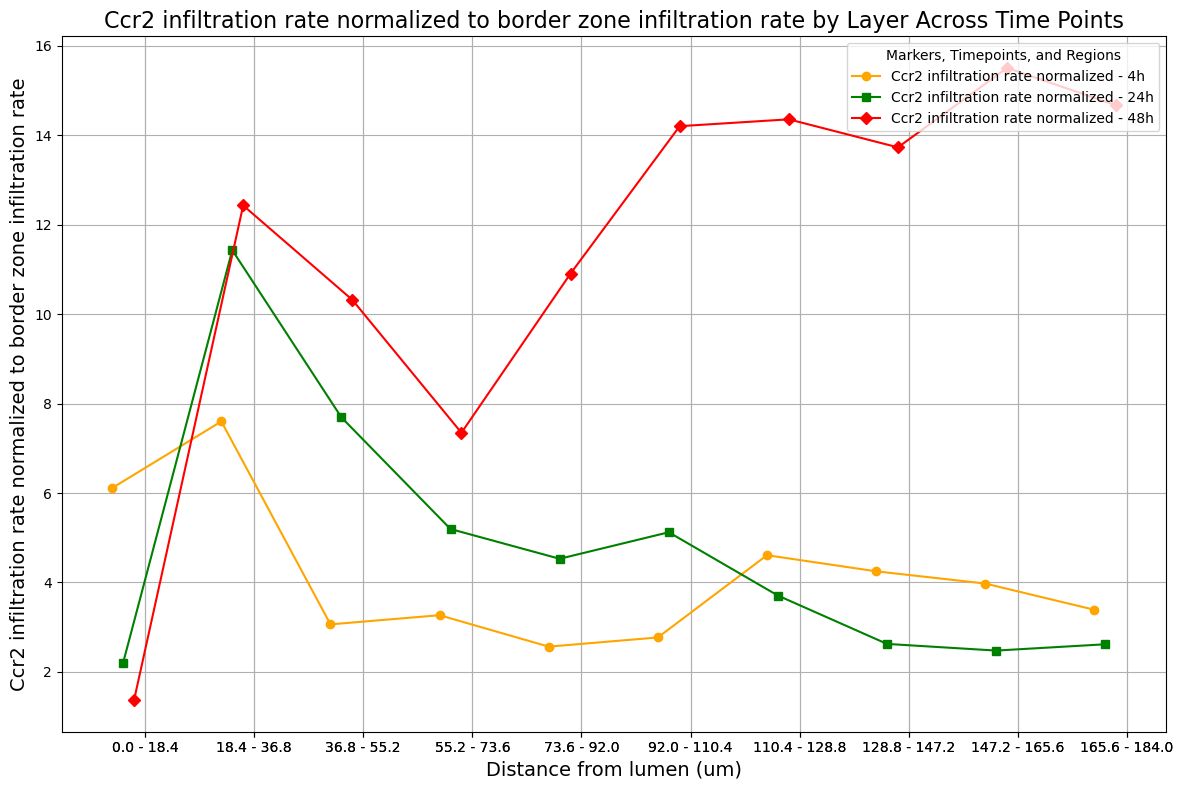

In [641]:
marker_column = 'Ccr2 infiltration rate normalized'
plot_all_with_bz_ratio([marker_column], 
                         layer_df_combined_cells[np.logical_and(layer_df_combined_cells['layer_values'] > 0, layer_df_combined_cells['layer_values'] <= 10)], 
                         y_label = 'Ccr2 infiltration rate normalized to border zone infiltration rate',
                         title = 'Ccr2 infiltration rate normalized to border zone infiltration rate by Layer Across Time Points')

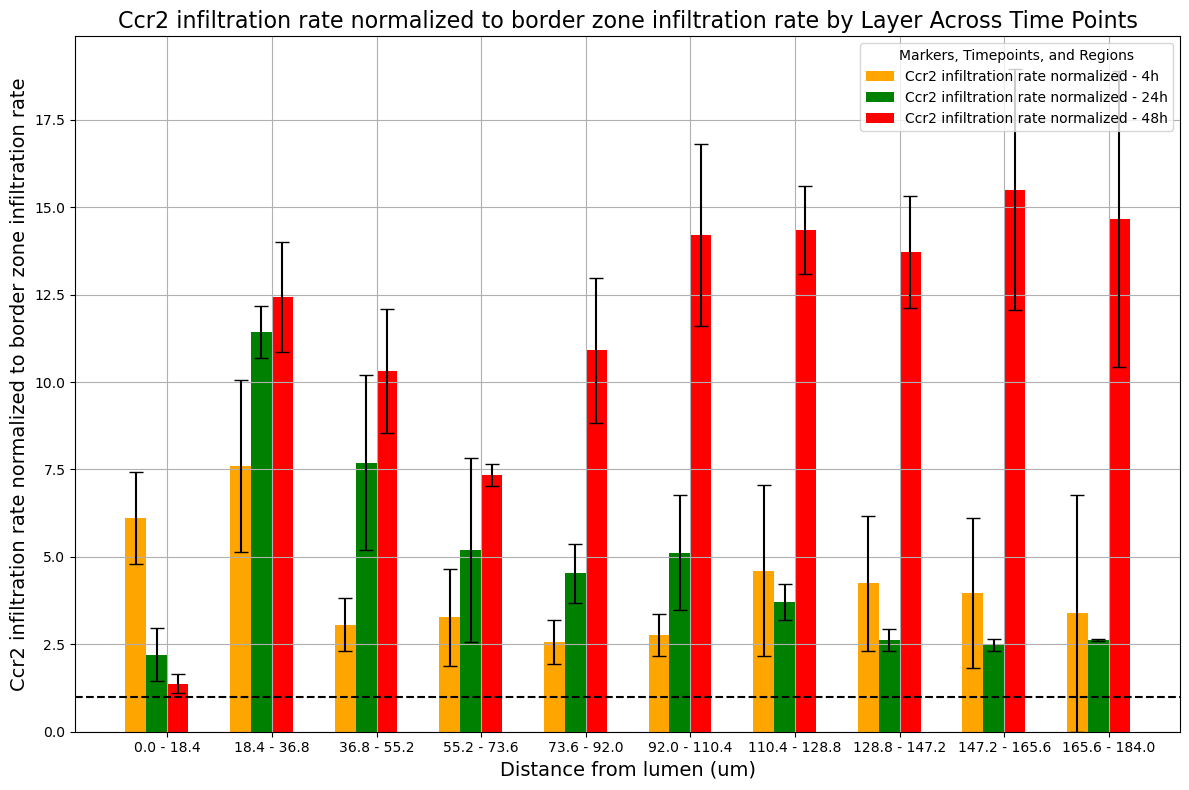

In [10]:
marker_column = 'Ccr2 infiltration rate normalized'
plot_all_with_bz_ratio_bar([marker_column], 
                         layer_df_combined_cells[np.logical_and(layer_df_combined_cells['layer_values'] > 0, layer_df_combined_cells['layer_values'] <= 10)], 
                         y_label = 'Ccr2 infiltration rate normalized to border zone infiltration rate',
                         title = 'Ccr2 infiltration rate normalized to border zone infiltration rate by Layer Across Time Points')

In [670]:
layer_df_combined_cells['log2 FC infiltration rate ratio'] = np.log2(layer_df_combined_cells['Ccr2 infiltration rate normalized'])

/Users/kbestak/miniconda3/envs/artecorr/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
layer_df_combined_cells

NameError: name 'layer_df_combined_cells' is not defined

## Distance from lumen - distance transform approach

In [7]:
sample_list = ["Control_12", "Control_13", "Control_14", "4h_96", "4h_97", "24h_83", "24h_86", "48h_76", "48h_79"]

sample_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/sample_name_matching.csv')
sample_list_final = [sample_matching.loc[sample_matching['sample_kb'] == sample, 'sample_final'].values[0] for sample in sample_list]
image_path_list = [sample_matching.loc[sample_matching['sample_kb'] == sample, 'image_path'].values[0] for sample in sample_list]
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest.csv')

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_70041/2823032382.py:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest.csv')


In [3]:
sample='24h_83'
sample_final_name = sample_list_final[sample_list.index(sample)]
image_path = image_path_list[sample_list.index(sample)]

valid_segmentation_methods = ['cellpose_lunaphore','cellpose_cyto','mesmer_wholecell','mesmer_nuclei']
segmentation_method = "cellpose_lunaphore" 
if segmentation_method not in valid_segmentation_methods:
    raise ValueError(f"Invalid segmentation method: {segmentation_method}. Valid segmentation methods are: {valid_segmentation_methods}")

segmentation_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/segmentation/{segmentation_method}/{sample}_clahe.ome_cp_masks.tif'
pixel_map_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/pixel_masks/{sample_final_name}.pixel_mask.tiff'
region_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_regions.tif'
endocardium_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_endocardium.tif'
lumen_layer_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/lumen_expanded_masks/{sample}_lumen_layers.tif'
injury_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_injury.tif'
reannotated_regions_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_regions.tif'

markers_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/marker_files/AF_corrected/{sample}_markers.csv'
markers = pd.read_csv(markers_path)

In [6]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest.csv')
cell_data["distance_from_lumen"] = 20000.0
from scipy.ndimage import distance_transform_edt

for sample in sample_list:
    sample_final_name = sample_list_final[sample_list.index(sample)]
    reannotated_regions_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_regions.tif'
    reannotated_regions = tifffile.imread(reannotated_regions_path)
    distance_from_lumen = distance_transform_edt(reannotated_regions != 1)
    cell_data.loc[cell_data['fov'] == sample, 'distance_from_lumen'] = distance_from_lumen[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_94638/2231413257.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest.csv')


In [15]:
for sample in sample_list:
    sample_final_name = sample_list_final[sample_list.index(sample)]
    reannotated_regions_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_regions.tif'
    reannotated_regions = tifffile.imread(reannotated_regions_path)
    print(np.unique(reannotated_regions))
    cell_data.loc[cell_data['fov'] == sample, 'region'] = reannotated_regions[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]

[ 0  1  2  4  5  7  8 10]
[ 0  1  2  4  5  7  8 10]
[ 0  1  2  4  5  7  8 10]
[ 0  1  2  3  4  5  7  8 10]
[ 0  1  2  3  4  5  7  8 10]
[ 0  1  2  3  4  5  7  8 10]
[ 0  1  2  3  4  5  7  8 10]
[ 0  1  2  3  4  5  7  8 10]
[ 0  1  2  3  4  5  7  8 10]


In [18]:
cell_data.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen.csv', index=False)

In [23]:
# print smallest 100 distances to lumen for all "Mono / Macros Ccr2+"
cell_data_ccr2 = cell_data[cell_data['cell_meta_cluster'] == 'Mono / Macros Ccr2+']
cell_data_ccr2.sort_values(by='distance_from_lumen', ascending=True).head(100)


fov  label  cell_size    X_centroid    Y_centroid  Eccentricity  \
99128   24h_83  28754       1681  16548.995836  14365.493754      0.723084   
415801  48h_79  20601        983  18465.678535  10179.306205      0.664232   
415817  48h_79  20617       1027  17976.530672  10188.146056      0.604364   
43744   24h_86  43830       1436  21992.852368  17360.398329      0.806144   
44157   24h_86  44249       1837  22024.228634  17490.667937      0.798403   
...        ...    ...        ...           ...           ...           ...   
47643   24h_86  47775        590  21045.786441  18571.357627      0.802741   
481994  48h_76  15265        998  12813.589178   5555.745491      0.596492   
482266  48h_76  15538        805  12851.357764   5614.304348      0.528609   
46642   24h_86  46746       1784  22396.876121  18285.783632      0.289453   
46784   24h_86  46894       1520  20837.889474  18336.566447      0.686923   

        Solidity    Extent  Orientation    cell_meta_cluster  \
99128   0.974493  0.723945    -1.248442  Mono / Macros Ccr2+   
415801  0.952519  0.633785    -1.561839  Mono / Macros Ccr2+   
415817  0.942202  0.695799    -1.560689  Mono / Macros Ccr2+   
43744   0.967003  0.648600     0.554094  Mono / Macros Ccr2+   
44157   0.943018  0.588782     0.799883  Mono / Macros Ccr2+   
...          ...       ...          ...                  ...   
47643   0.945513  0.705742    -0.179844  Mono / Macros Ccr2+   
481994  0.967054  0.750376    -0.307337  Mono / Macros Ccr2+   
482266  0.957194  0.741935    -0.531614  Mono / Macros Ccr2+   
46642   0.967987  0.685890    -0.549850  Mono / Macros Ccr2+   
46784   0.959596  0.639731     0.469987  Mono / Macros Ccr2+   

          refined_cell_type  lumen_layer  background_layer  region  \
99128   Mono / Macros Ccr2+            1                 1       1   
415801  Mono / Macros Ccr2+            4                 4       1   
415817  Mono / Macros Ccr2+            1                 1       1   
43744   Mono / Macros Ccr2+            2                 2       1   
44157   Mono / Macros Ccr2+            2                 2       1   
...                     ...          ...               ...     ...   
47643   Mono / Macros Ccr2+            2                 2       1   
481994  Mono / Macros Ccr2+            2                 2       1   
482266  Mono / Macros Ccr2+            2                 2       1   
46642   Mono / Macros Ccr2+            2                 2       1   
46784   Mono / Macros Ccr2+            1                 1       1   

       region_name      closest_type  min_endothelial_distance  \
99128            0  Endocardial cell                101.740714   
415801           0  Endothelial cell                 58.719112   
415817           0  Endothelial cell                 33.804250   
43744            0  Endothelial cell                 67.497111   
44157            0  Endothelial cell                 50.020918   
...            ...               ...                       ...   
47643            0               NaN                 -1.000000   
481994           0  Endothelial cell                 43.347724   
482266           0  Endothelial cell                 34.976339   
46642            0  Endothelial cell                 68.501202   
46784            0  Endothelial cell                 31.143907   

        min_endocardial_distance timepoint  distance_from_lumen  
99128                  68.636036       24h                  0.0  
415801                 -1.000000       48h                  0.0  
415817                 -1.000000       48h                  0.0  
43744                  -1.000000       24h                  0.0  
44157                  -1.000000       24h                  0.0  
...                          ...       ...                  ...  
47643                  -1.000000       24h                  0.0  
481994                 -1.000000       48h                  0.0  
482266                 -1.000000       48h                  0.0  
46642      

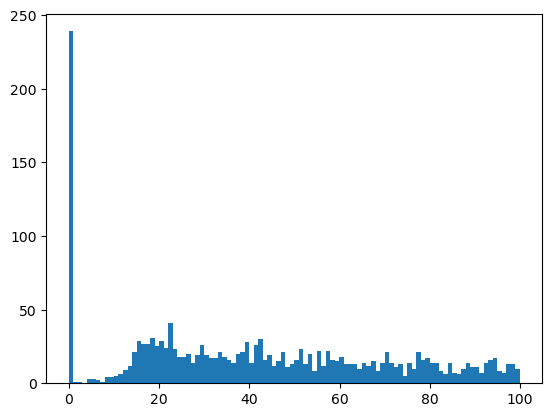

In [22]:
# for all "Mono / Macros Ccr2+" with distance to lumen below 435, plot a histogram of distance to lumen
cell_data_ccr2 = cell_data[cell_data['cell_meta_cluster'] == 'Mono / Macros Ccr2+']
cell_data_ccr2_below_435 = cell_data_ccr2[cell_data_ccr2['distance_from_lumen'] < 100]
plt.hist(cell_data_ccr2_below_435['distance_from_lumen'], bins=100)
plt.show()



In [7]:
# read in reannotated_regions_path
reannotated_regions = tifffile.imread(reannotated_regions_path)

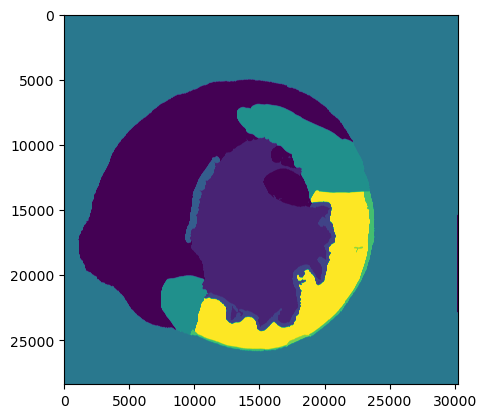

In [8]:
import matplotlib.pyplot as plt
plt.imshow(reannotated_regions)
plt.show()

In [11]:
from scipy.ndimage import distance_transform_edt

distance_from_lumen = distance_transform_edt(reannotated_regions != 1)

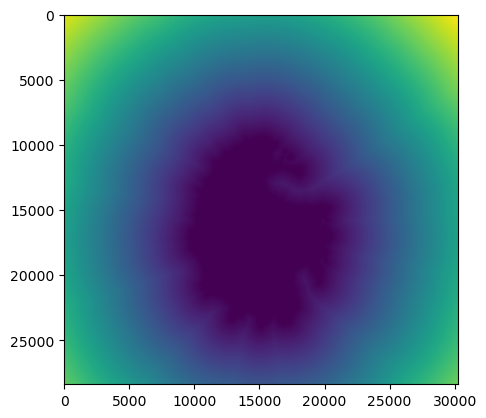

In [12]:
plt.imshow(distance_from_lumen)
plt.show()

In [13]:
distance_from_lumen

array([[16200.31635494, 16199.60372972, 16198.89113489, ...,
        16863.59540549, 16864.30802019, 16865.02066408],
       [16199.6148411 , 16198.90218502, 16198.18955933, ...,
        16862.89385011, 16863.60649446, 16864.31916799],
       [16198.91335862, 16198.20067168, 16197.48801512, ...,
        16862.19232484, 16862.90499884, 16863.61770202],
       ...,
       [12832.97334993, 12832.12499939, 12831.2766707 , ...,
        13154.44335576, 13155.24826828, 13156.05320755],
       [12833.50279542, 12832.65447988, 12831.80618619, ...,
        13155.03679204, 13155.84166825, 13156.64657122],
       [12834.03229698, 12833.18401645, 12832.33575776, ...,
        13155.63027757, 13156.43511746, 13157.23998413]])

In [2]:
import pandas as pd
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen.csv')


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_54065/2164747282.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen.csv')


In [8]:
cell_data.region.unique()

array([ 0,  4,  5,  3, 10,  1,  2,  7,  8])

In [8]:
# create a table matching the regions indices to the region names
region_matching = pd.DataFrame(columns=['region_id', 'region_name'])
region_matching.loc[0] = [1, 'lumen']
region_matching.loc[1] = [2, 'endocardial_region']
region_matching.loc[2] = [3, 'remote_endocardial_region']
region_matching.loc[3] = [4, 'background']
region_matching.loc[4] = [5, 'border_zone']
region_matching.loc[5] = [7, 'epicardial_region']
region_matching.loc[6] = [8, 'ignore']
region_matching.loc[7] = [10, 'infarct_core']
region_matching.loc[8] = [0, 'other_cardiac_tissue']

# apply the region matching to the region column in cell_data
cell_data["region_name"] = cell_data["region"].map(region_matching.set_index('region_id')['region_name'])

In [10]:
cell_data.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions.csv', index=False)

In [23]:

min_area = 72
max_area = 72000
# filter cells by cell_size to be between min and max area
cell_data_filtered = cell_data[np.logical_and(cell_data['cell_size'] > min_area, cell_data['cell_size'] < max_area)]

In [25]:
cell_data_filtered.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered.csv', index=False)

In [3]:
cell_data_filtered = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered.csv')

In [5]:
# subset cell_data_filtered to exclude cells in background, lumen, ignore
#cell_data_filtered_subset = cell_data_filtered[~cell_data_filtered.region_name.isin(['background', 'lumen', 'ignore'])]

In [10]:
exclude_cells = cell_data_filtered[(cell_data_filtered['Eccentricity'] > 0.9) & (cell_data_filtered['Solidity'] < 0.9) & (cell_data_filtered['cell_size'] < 500)].index
exclude_cells = np.concatenate((exclude_cells, cell_data_filtered[(cell_data_filtered['cell_size'] < 72) | (cell_data_filtered['Solidity'] < 0.1) | (cell_data_filtered['cell_size'] > 72000) ].index))
exclude_cells = np.unique(exclude_cells)

cell_data_filtered_exclude_cells = cell_data_filtered.drop(exclude_cells)

In [12]:
cell_data_filtered_exclude_cells.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered_exclude_cells.csv', index=False)

In [4]:
cell_data_filtered_exclude_cells = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered_exclude_cells.csv')

In [53]:
max_distance = cell_data_filtered_exclude_cells['distance_from_lumen'].max()
next_multiple_of_80 = (np.ceil(max_distance / 80) * 80)
bin_edges = np.arange(0, next_multiple_of_80 + 80, 80)
cell_data_filtered_exclude_cells['lumen_bin'] = pd.cut(cell_data_filtered_exclude_cells['distance_from_lumen'], bins=bin_edges, labels=range(1, len(bin_edges)))
cell_data_filtered_exclude_cells.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered_exclude_cells_lumen_bin.csv', index=False)

In [88]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered_exclude_cells_lumen_bin.csv')
# read endocardial layer annotation
sample = '24h_86'
endocardium_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_endocardium.tif'
endocardium_image = tifffile.imread(endocardium_path)

# get boolean list endocardium_image (at positions given with X and Y_centroid) is >0 for subset of cell_data with sample == sample
def get_endocardium_value(x, y, endocardium_image):
    return endocardium_image[y, x]

cell_data_subset = cell_data[cell_data['fov'] == sample]
endocardial_layer_bool = cell_data_subset.apply(lambda x: get_endocardium_value(x=np.rint(x['X_centroid']).astype(int), y=np.rint(x['Y_centroid']).astype(int), endocardium_image=endocardium_image), axis=1) > 0

# if both endocardial_layer_bool and refined cell_type == "Endothelial cells", set cell_type to "Endocardial cells"
cell_data_subset.loc[endocardial_layer_bool & (cell_data_subset['cell_meta_cluster'] == 'Endothelial cells'), 'cell_meta_cluster'] = 'Endocardial cells'
reannotated_regions_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_regions.tif'
reannotated_regions = tifffile.imread(reannotated_regions_path)
# load region_mask 
from scipy.ndimage import distance_transform_edt
distance_from_lumen = distance_transform_edt(reannotated_regions != 1)
cell_data_subset['distance_from_lumen'] = distance_from_lumen[cell_data_subset['Y_centroid'].astype(int), cell_data_subset['X_centroid'].astype(int)]
cell_data.loc[cell_data['fov'] == sample] = cell_data_subset
cell_data.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered_exclude_cells_lumen_bin_endofix.csv', index=False)

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_4644/947779439.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_subset['distance_from_lumen'] = distance_from_lumen[cell_data_subset['Y_centroid'].astype(int), cell_data_subset['X_centroid'].astype(int)]


In [ ]:
# plot scatter plot of X_centroid, Y_centroid positions for rows with distance_from_lumen below 100
cell_data_subset_below_100 = cell_data_subset[cell_data_subset['distance_from_lumen'] < 100]
plt.scatter(cell_data_subset_below_100['X_centroid'], cell_data_subset_below_100['Y_centroid'])
plt.show()


In [51]:
# only look at Control_12 sample
cell_subset = cell_data_filtered_exclude_cells.loc[cell_data_filtered_exclude_cells.fov == 'Control_12']
mono_subset = cell_subset.loc[cell_subset.refined_cell_type == 'Mono / Macros Ccr2+']
endothelial_subset = cell_subset.loc[cell_subset.refined_cell_type == 'Endothelial cells']
endocardial_subset = cell_subset.loc[cell_subset.refined_cell_type == 'Endocardial cells']

In [52]:
cell_subset.lumen_bin.value_counts()

lumen_bin
1      1227
2      1195
3      1105
5      1060
4      1057
       ... 
127       0
128       0
129       0
130       0
131       0
Name: count, Length: 131, dtype: int64

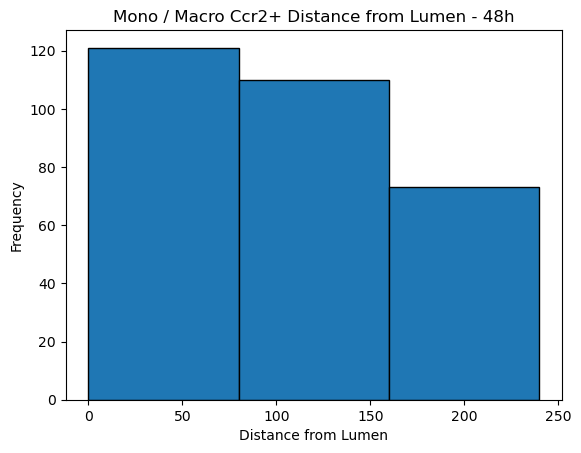

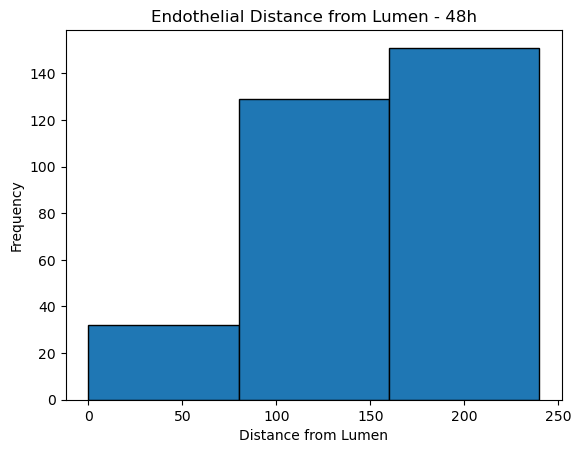

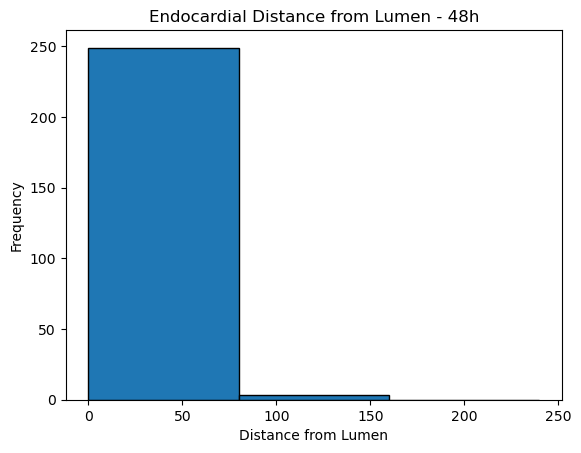

In [41]:
timepoint = "48h"
cell_subset2 = cell_data_filtered_exclude_cells.loc[cell_data_filtered_exclude_cells.timepoint == timepoint]
region_name = 'endocardial_region'
cell_subset = cell_subset2.loc[cell_subset2.region_name == region_name]

bin_width = 80
max_value = 3 * bin_width

# Create bin edges starting from 0 with a step of bin_width

mono_subset = cell_subset.loc[cell_subset.refined_cell_type == 'Mono / Macros Ccr2+']
#max_value = mono_subset['distance_from_lumen'].max()
bin_edges = np.arange(0, max_value + bin_width, bin_width)
plt.hist(mono_subset['distance_from_lumen'], bins=bin_edges, edgecolor='black')
plt.title(f'Mono / Macro Ccr2+ Distance from Lumen - {timepoint}')
plt.xlabel('Distance from Lumen')
plt.ylabel('Frequency')
plt.show()

endothelial_subset = cell_subset.loc[cell_subset.refined_cell_type == 'Endothelial cells']
#max_value = endothelial_subset['distance_from_lumen'].max()
bin_edges = np.arange(0, max_value + bin_width, bin_width)
plt.hist(endothelial_subset['distance_from_lumen'], bins=bin_edges, edgecolor='black')
plt.title(f'Endothelial Distance from Lumen - {timepoint}')
plt.xlabel('Distance from Lumen')
plt.ylabel('Frequency')
plt.show()

endocardial_subset = cell_subset.loc[cell_subset.refined_cell_type == 'Endocardial cells']
#max_value = endocardial_subset['distance_from_lumen'].max()
bin_edges = np.arange(0, max_value + bin_width, bin_width)
plt.hist(endocardial_subset['distance_from_lumen'], bins=bin_edges, edgecolor='black')
plt.title(f'Endocardial Distance from Lumen - {timepoint}')
plt.xlabel('Distance from Lumen')
plt.ylabel('Frequency')
plt.show()

### Use re-reannotated 24h_83 and 4h_96

In [6]:
sample = '24h_83'

In [3]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered_exclude_cells_lumen_bin_endofix.csv')

In [4]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered_exclude_cells_lumen_bin_endofix.csv')

from scipy.ndimage import distance_transform_edt

for sample in sample_list:
    sample_final_name = sample_list_final[sample_list.index(sample)]
    reannotated_regions_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_regions.tif'
    reannotated_regions = tifffile.imread(reannotated_regions_path)
    distance_from_lumen = distance_transform_edt(reannotated_regions != 1)
    cell_data.loc[cell_data['fov'] == sample, 'distance_from_lumen'] = distance_from_lumen[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]

fov  label  cell_size    X_centroid    Y_centroid  \
0           24h_86      8       1433  13794.937195   4311.645499   
1           24h_86      9       1516  14441.179420   4319.424142   
2           24h_86     11       6035  14374.174979   4344.383099   
3           24h_86     12       5298  14523.473575   4335.610608   
4           24h_86     14       1163  14597.668100   4324.958727   
...            ...    ...        ...           ...           ...   
572989  Control_14  82106       1080  13974.990741  24152.720370   
572990  Control_14  82107       3235  12336.925502  24169.496754   
572991  Control_14  82108      10610  12189.037606  24193.085862   
572992  Control_14  82109       2077  12287.895041  24183.298507   
572993  Control_14  82110       1574  12391.485388  24184.196315   

        Eccentricity  Solidity    Extent  Orientation    cell_meta_cluster  \
0           0.688445  0.967589  0.765491    -1.181936          Fibroblasts   
1           0.784424  0.971795  0.697653    -1.035882  Mono / Macros Ccr2+   
2           0.568614  0.960987  0.779414    -0.738112       Cardiomyocytes   
3           0.694712  0.955283  0.672506    -1.338075       Cardiomyocytes   
4           0.689784  0.946298  0.615344     0.869137  Mono / Macros Ccr2+   
...              ...       ...       ...          ...                  ...   
572989      0.776084  0.952381  0.725806    -1.352395          Fibroblasts   
572990      0.644124  0.906925  0.660609     1.134052          Fibroblasts   
572991      0.866968  0.951911  0.664787    -1.300009       Cardiomyocytes   
572992      0.510616  0.971014  0.714482    -1.363983       Cardiomyocytes   
572993      0.311718  0.968615  0.745265    -1.159081          Fibroblasts   

        ... lumen_layer  background_layer  region           region_name  \
0       ...           0                 0       0  other_cardiac_tissue   
1       ...           0                 0       0  other_cardiac_tissue   
2       ...           0                 0       0  other_cardiac_tissue   
3       ...           0                 0       0  other_cardiac_tissue   
4       ...           0                 0       0  other_cardiac_tissue   
...     ...         ...               ...     ...                   ...   
572989  ...           0                 0       0  other_cardiac_tissue   
572990  ...           0                 0       0  other_cardiac_tissue   
572991  ...           0                 0       0  other_cardiac_tissue   
572992  ...           0                 0       0  other_cardiac_tissue   
572993  ...           0                 0       0  other_cardiac_tissue   

       closest_type min_endothelial_distance  min_endocardial_distance  \
0               NaN                     -1.0                      -1.0   
1               NaN                     -1.0                      -1.0   
2               NaN                     -1.0                      -1.0   
3               NaN                     -1.0                      -1.0   
4               NaN                     -1.0                      -1.0   
...             ...                      ...                       ...   
572989          NaN                     -1.0                      -1.0   
572990          NaN                     -1.0                      -1.0   
572991          NaN                     -1.0                      -1.0   
572992          NaN                     -1.0                      -1.0   
572993          NaN                     -1.0                      -1.0   

        timepoint distance_from_lumen  lumen_bin  
0             24h         5860.815814       74.0  
1             24h         5554.992799       70.0  
2             24h         5560.604014       70.0  
3             24h         5506.734513       69.0  
4             24h         5487.299153       69.0  
...           ...                 ...        ...  
572989    Control         9135.596806      115.0  
572990    Control         8896.518982      112.0  
572991    Co

In [10]:
reannotated_regions_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_regions.tif'
reannotated_regions = tifffile.imread(reannotated_regions_path)

In [11]:
np.unique(reannotated_regions)

array([ 0,  1,  2,  3,  4,  5,  7,  8, 10], dtype=uint8)

In [33]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered_exclude_cells_lumen_bin_endofix.csv')
# read endocardial layer annotation
sample = '24h_83'
endocardium_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_endocardium.tif'
endocardium_image = tifffile.imread(endocardium_path)

# get boolean list endocardium_image (at positions given with X and Y_centroid) is >0 for subset of cell_data with sample == sample
def get_endocardium_value(x, y, endocardium_image):
    return endocardium_image[y, x]

cell_data_subset = cell_data[cell_data['fov'] == sample]
endocardial_layer_bool = cell_data_subset.apply(lambda x: get_endocardium_value(x=np.rint(x['X_centroid']).astype(int), y=np.rint(x['Y_centroid']).astype(int), endocardium_image=endocardium_image), axis=1) > 0

In [35]:
cell_data_subset[endocardial_layer_bool]

fov  label  cell_size    X_centroid    Y_centroid  Eccentricity  \
78393   24h_83  11252        358  15422.952514   9386.896648      0.715613   
78437   24h_83  11296       1597  15418.813400   9417.393237      0.391713   
78526   24h_83  11385        450  15087.844444   9432.586667      0.785999   
78540   24h_83  11399       1399  14505.330951   9438.205147      0.677664   
78579   24h_83  11438       2845  15445.807381   9458.235501      0.764026   
...        ...    ...        ...           ...           ...           ...   
123524  24h_83  58312       1663  15184.420325  23991.029465      0.695472   
123553  24h_83  58341        765  15047.000000  23991.443137      0.448761   
123589  24h_83  58394        282  15101.141844  24001.797872      0.811704   
123590  24h_83  58395       2119  15154.019821  24017.559226      0.502161   
123597  24h_83  58402       1078  15118.696660  24017.941558      0.687224   

        Solidity    Extent  Orientation    cell_meta_cluster  ... lumen_layer  \
78393   0.920308  0.697856    -1.358852    Endothelial cells  ...           1   
78437   0.933372  0.652369    -1.529985    Endothelial cells  ...           1   
78526   0.939457  0.601604    -0.024360    Endothelial cells  ...           1   
78540   0.971528  0.760326     0.550655    Endothelial cells  ...           2   
78579   0.881624  0.595936    -0.239719    Endothelial cells  ...           1   
...          ...       ...          ...                  ...  ...         ...   
123524  0.936901  0.592659     1.372948  Mono / Macros Ccr2+  ...           1   
123553  0.901060  0.662338     0.926081  Mono / Macros Ccr2+  ...           1   
123589  0.889590  0.537143    -0.654828    Endothelial cells  ...           1   
123590  0.923312  0.644857     0.982468  Mono / Macros Ccr2+  ...           1   
123597  0.967684  0.700000     0.382692    Endothelial cells  ...           1   

        background_layer  region           region_name      closest_type  \
78393                  1       5           border_zone               NaN   
78437                  1       5           border_zone               NaN   
78526                  1       5           border_zone               NaN   
78540                  2       0  other_cardiac_tissue               NaN   
78579                  1       5           border_zone               NaN   
...                  ...     ...                   ...               ...   
123524                 1       2    endocardial_region  Endocardial cell   
123553                 1       2    endocardial_region  Endocardial cell   
123589                 1       2    endocardial_region               NaN   
123590                 1       2    endocardial_region  Endocardial cell   
123597                 1       2    endocardial_region               NaN   

       min_endothelial_distance  min_endocardial_distance  timepoint  \
78393                 -1.000000                 -1.000000        24h   
78437                 -1.000000                 -1.000000        24h   
78526                 -1.000000                 -1.000000        24h   
78540                 -1.000000                 -1.000000        24h   
78579                 -1.000000                 -1.000000        24h   
...                         ...                       ...        ...   
123524               142.293463                 71.020144        24h   
123553                -1.000000                 55.123133        24h   
123589                -1.000000                 -1.000000        24h   
123590               115.780869                 35.325229        24h   
123597                -1.000000                 -1.000000        24h   

       distance_from_lumen  lumen_bin  
78393            52.611786        1.0  
78437            21.377558        1.0  
78526            72.062473        1.0  
78540           136.623570        2.0  
78579            24.596748        1.0  
...                    ...        ...  
123524           34.000000        1.0  
123

In [37]:
sum(endocardial_layer_bool & (cell_data_subset['cell_meta_cluster'] == 'Endothelial cells'))

627

In [38]:
sum(cell_data_subset['refined_cell_type'] == 'Endocardial cells')

627

In [ ]:
# if both endocardial_layer_bool and refined cell_type == "Endothelial cells", set cell_type to "Endocardial cells"
cell_data_subset.loc[endocardial_layer_bool & (cell_data_subset['cell_meta_cluster'] == 'Endothelial cells'), 'refined_cell_type'] = 'Endocardial cells'
reannotated_regions_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_regions.tif'
reannotated_regions = tifffile.imread(reannotated_regions_path)

cell_data_subset['region'] = reannotated_regions[np.rint(cell_data_subset['Y_centroid']).astype(int), np.rint(cell_data_subset['X_centroid']).astype(int)]
# new column region_name - 1 (lumen), 2 (endocardium_near_infarct), 3 (endocardium_remote), 4 (background), 5 (border_zone), 6 (papillary_muscle), 7 (epicardium), 8 (ignore), 9 (myocardium)
cell_data_subset['region_name'] = cell_data_subset['region'].astype(str)

region_matching = pd.DataFrame(columns=['region_id', 'region_name'])
region_matching.loc[0] = [1, 'lumen']
region_matching.loc[1] = [2, 'endocardial_region']
region_matching.loc[2] = [3, 'remote_endocardial_region']
region_matching.loc[3] = [4, 'background']
region_matching.loc[4] = [5, 'border_zone']
region_matching.loc[5] = [7, 'epicardial_region']
region_matching.loc[6] = [8, 'ignore']
region_matching.loc[7] = [10, 'infarct_core']
region_matching.loc[8] = [0, 'other_cardiac_tissue']

cell_data_subset["region_name"] = cell_data_subset["region"].map(region_matching.set_index('region_id')['region_name'])

In [32]:
cell_data_subset[cell_data_subset['label'] == 56317].cell_meta_cluster

121597    Endothelial cells
Name: cell_meta_cluster, dtype: object

In [25]:
sum(cell_data_subset.refined_cell_type  == cell_data[cell_data['fov'] == sample].refined_cell_type) - len(cell_data_subset)

0

In [26]:
sum(cell_data[cell_data['fov'] == sample].region == cell_data_subset.region) - len(cell_data[cell_data['fov'] == sample])

-18

In [ ]:

# load region_mask 
from scipy.ndimage import distance_transform_edt
distance_from_lumen = distance_transform_edt(reannotated_regions != 1)
cell_data_subset['distance_from_lumen'] = distance_from_lumen[cell_data_subset['Y_centroid'].astype(int), cell_data_subset['X_centroid'].astype(int)]
cell_data.loc[cell_data['fov'] == sample] = cell_data_subset
cell_data.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels_refined_layers_closest_distance_from_lumen_regions_filtered_exclude_cells_lumen_bin_endofix_24h83fix.csv', index=False)

In [40]:
cell_data_target = cell_data.copy()

# Reproducible processing from cell_table_size_normalized_cell_labels.csv to final dataframe

In [12]:
import pandas as pd
import numpy as np
import tifffile
import dask.array as da
from dask.array.image import imread
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import copy
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt

class SamplePaths:
    def __init__(self, sample):
        self.sample = sample
        self.sample_final_name = sample_list_final[sample_list.index(sample)]
        self.image_path = image_path_list[sample_list.index(sample)]

        self.segmentation_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/segmentation/cellpose_lunaphore/{sample}_clahe.ome_cp_masks.tif'
        self.reannotated_regions_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_regions.tif'
        self.reannotated_endocardium_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_endocardium.tif'
        self.injury_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/region_masks/{sample}_injury.tif'
        self.markers_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/marker_files/AF_corrected/{sample}_markers.csv'
        self.markers = pd.read_csv(self.markers_path)

sample_list = ["Control_12", "Control_13", "Control_14", "4h_96", "4h_97", "24h_83", "24h_86", "48h_76", "48h_79"]

sample_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/sample_name_matching.csv')
sample_list_final = [sample_matching.loc[sample_matching['sample_kb'] == sample, 'sample_final'].values[0] for sample in sample_list]
image_path_list = [sample_matching.loc[sample_matching['sample_kb'] == sample, 'image_path'].values[0] for sample in sample_list]
region_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/region_matching.csv')

In [29]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_size_normalized_cell_labels.csv') # Pixie output

lumen_distance_binsize = 80
minimum_cell_size = 120 # exact value in micrometers as used in Molecular Cartography data processing 200 * 0.138 / 0.23 = 120 (200 px * 0.138 um/px (MC pixel size) / 0.23 um/px (COMET PA pixel size)= 120 um)
maximum_cell_size = 120000 # exact value in micrometers as used in Molecular Cartography data processing


In [7]:
cell_data['timepoint'] = cell_data['fov'].str.split('_').str[0] # adds timepont column

# initialize values for new columns
cell_data['region'] = -1
cell_data['region_name'] = 'unknown'

cell_data['refined_cell_type'] = 'unknown'
cell_data['final_cell_type'] = 'unknown'

cell_data['endocardial_annotation'] = False
cell_data['exclude_annotation'] = False
cell_data['artefact'] = False

cell_data['distance_from_lumen'] = -1
cell_data['lumen_bin'] = -1

cell_data['size_filter'] = False

In [8]:
for sample in sample_list:
    sample_paths = SamplePaths(sample)
    print(sample_paths.reannotated_regions_path)
    reannotated_regions = tifffile.imread(sample_paths.reannotated_regions_path)
    cell_data.loc[cell_data['fov'] == sample, 'region'] = reannotated_regions[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]

    distance_from_lumen = distance_transform_edt(reannotated_regions != 1)
    cell_data.loc[cell_data['fov'] == sample, 'distance_from_lumen'] = distance_from_lumen[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]

    reannotated_endocardium = tifffile.imread(sample_paths.reannotated_endocardium_path)
    cell_data.loc[cell_data['fov'] == sample, 'endocardial_annotation'] = reannotated_endocardium[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]

/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_12_regions.tif


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_6141/2575622954.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9483.96842045 9469.18581505 9445.49082896 ... 6333.97521309 6341.02554797
 6359.60887162]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cell_data.loc[cell_data['fov'] == sample, 'distance_from_lumen'] = distance_from_lumen[cell_data.loc[cell_data['fov'] == sample, 'Y_centroid'].astype(int), cell_data.loc[cell_data['fov'] == sample, 'X_centroid'].astype(int)]
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_6141/2575622954.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  cell_data.loc[cell_data['fov'] == sample, 'endocardial_annotation'] = reannotated_endoca

/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_13_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_14_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/4h_96_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/4h_97_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/24h_83_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/24h_86_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/48h_76_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/48h_79_regions.tif


In [120]:
cell_data['region_name'] = cell_data['region'].map(region_matching.set_index('region_id')['region_name']) # match region names to region ids

cell_data['refined_cell_type'] = cell_data['cell_meta_cluster']
cell_data.loc[(cell_data['endocardial_annotation']>0) & (cell_data['cell_meta_cluster'] == 'Endothelial cells'), 'refined_cell_type'] = 'Endocardial cells' # all cells is in the endocardial annotation and classified as "Endothelial cells", are renamed to "Endocardial cells" in the "refined_cell_type" column

max_distance = cell_data['distance_from_lumen'].max()
next_multiple_of_80 = (np.ceil(max_distance / lumen_distance_binsize) * lumen_distance_binsize) # get maximum lumen bin value possible
bin_edges = np.arange(0, next_multiple_of_80 + lumen_distance_binsize, lumen_distance_binsize)
cell_data['lumen_bin'] = pd.cut(cell_data['distance_from_lumen'], bins=bin_edges, labels=range(1, len(bin_edges))) # assign lumen bin based on lumen_distance_binsize

cell_data.loc[cell_data.region_name.isin(['background', 'lumen', 'ignore']), 'exclude_annotation'] = True # if region_name is background, lumen or ignore, cells should be excluded]
cell_data.loc[cell_data.cell_meta_cluster.isin(['out_of_mask', 'background']), 'exclude_annotation'] = True

cell_data['size_filter'] = np.logical_or(cell_data['cell_size'] < minimum_cell_size, cell_data['cell_size'] > maximum_cell_size) # exclude cells below min and above max filter

artefacts = cell_data[(cell_data['Eccentricity'] > 0.9) & (cell_data['Solidity'] < 0.9) & (cell_data['cell_size'] < 500)].index.values # exclude cells with high eccentricity, low solidity and small size
artefacts = np.concatenate((artefacts, cell_data[(cell_data['Solidity'] < 0.1)].index.values)) # additionally exclude cells with very low solidity
artefacts = np.unique(artefacts)
cell_data.loc[artefacts, 'artefact'] = True

cell_data['final_cell_type'] = cell_data['refined_cell_type']
cell_data.loc[cell_data['exclude_annotation'], 'final_cell_type'] = 'exclude'
cell_data.loc[cell_data['size_filter'], 'final_cell_type'] = 'exclude'
cell_data.loc[cell_data['artefact'], 'final_cell_type'] = 'exclude'

In [123]:
cell_data.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final.csv', index=False)

## Lumen bin labeled mask

In [62]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final.csv')

lumen_distance_binsize = 80

max_distance = cell_data['distance_from_lumen'].max()
next_multiple_of_80 = (np.ceil(max_distance / lumen_distance_binsize) * lumen_distance_binsize) # get maximum lumen bin value possible
bin_edges = np.arange(0, next_multiple_of_80 + lumen_distance_binsize, lumen_distance_binsize)

sample_list = ["Control_12", "Control_13", "Control_14", "4h_96", "4h_97", "24h_83", "24h_86", "48h_76", "48h_79"]

sample_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/sample_name_matching.csv')
sample_list_final = [sample_matching.loc[sample_matching['sample_kb'] == sample, 'sample_final'].values[0] for sample in sample_list]



for sample in sample_list:
    sample_paths = SamplePaths(sample)
    print(sample_paths.reannotated_regions_path)
    reannotated_regions = tifffile.imread(sample_paths.reannotated_regions_path)

    distance_from_lumen = distance_transform_edt(reannotated_regions != 1)
    lumen_bins = np.digitize(distance_from_lumen, bin_edges, right=True).astype(np.uint8)
    # save lumen_bins
    lumen_bins_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/lumen_expanded_masks/{sample}_lumen_layers.tif'
    tifffile.imwrite(lumen_bins_path, lumen_bins)

/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_12_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_13_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/Control_14_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/4h_96_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/4h_97_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/24h_83_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/24h_86_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/48h_76_regions.tif
/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/r

## Spatial distances plots - from lumen

In [56]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [57]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final.csv')

In [58]:
# drop columns X_centroid, Y_centroid, region, region_name, refined_cell_type, endocardial_annotation, exclude_annotation, artefact, size_filter
cell_data_subset = cell_data[cell_data['lumen_bin'].isin([1, 2, 3, 4])]
cell_data_subset = cell_data_subset.drop(columns=['X_centroid', 'Y_centroid', 'region', 'region_name', 'refined_cell_type', 'endocardial_annotation', 'exclude_annotation', 'artefact', 'size_filter', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'cell_meta_cluster'])

# in cell_data_subset, per lumen bin get number of mono macro cells
cell_data_subset_mono = cell_data_subset[cell_data_subset['final_cell_type'] == 'Mono / Macros Ccr2+']
cell_data_subset_mono = cell_data_subset_mono.groupby(['fov', 'lumen_bin']).size().reset_index(name='mono_count')
cell_data_subset_all = cell_data_subset.groupby(['fov', 'lumen_bin']).size().reset_index(name='total_count')

cell_data_subset_merged = pd.merge(cell_data_subset_all, cell_data_subset_mono, on=['fov', 'lumen_bin'], how='left')

cell_data_subset_merged['mono_percentage'] = cell_data_subset_merged['mono_count'] / cell_data_subset_merged['total_count']

cell_data_subset_merged['timepoint'] = cell_data_subset_merged['fov'].str.split('_').str[0]

cell_data_subset_merged['lumen_bin'] = cell_data_subset_merged['lumen_bin'].astype(int)

cell_data_subset_endothelial = cell_data_subset[cell_data_subset['final_cell_type'] == 'Endothelial cells']
cell_data_subset_endothelial = cell_data_subset_endothelial.groupby(['fov', 'lumen_bin']).size().reset_index(name='endothelial_count')

cell_data_subset_endocardial = cell_data_subset[cell_data_subset['final_cell_type'] == 'Endocardial cells']
cell_data_subset_endocardial = cell_data_subset_endocardial.groupby(['fov', 'lumen_bin']).size().reset_index(name='endocardial_count')

cell_data_subset_merged = pd.merge(cell_data_subset_merged, cell_data_subset_endothelial, on=['fov', 'lumen_bin'], how='left')
cell_data_subset_merged['endothelial_percentage'] = cell_data_subset_merged['endothelial_count'] / cell_data_subset_merged['total_count']

cell_data_subset_merged = pd.merge(cell_data_subset_merged, cell_data_subset_endocardial, on=['fov', 'lumen_bin'], how='left')
cell_data_subset_merged['endocardial_percentage'] = cell_data_subset_merged['endocardial_count'] / cell_data_subset_merged['total_count']

cell_data_subset_merged.fillna(0, inplace=True)

In [60]:
cell_data_subset_merged['area_px'] = -1
for sample in cell_data_subset_merged.fov.unique():
    sample_paths = SamplePaths(sample)
    lumen_layers = tifffile.imread(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/lumen_expanded_masks/{sample}_lumen_layers.tif')

    # based on region_name in region_matching, get area in pixels
    for lumen_bin in cell_data_subset_merged.lumen_bin.unique():
        cell_data_subset_merged.loc[(cell_data_subset_merged['fov'] == sample) & (cell_data_subset_merged['lumen_bin'] == lumen_bin), 'area_px'] = np.sum(lumen_layers == lumen_bin)

cell_data_subset_merged['area_um'] = cell_data_subset_merged['area_px'] * 0.23 * 0.23 # convert area from pixels to micrometers
cell_data_subset_merged['mono_per_um2'] = cell_data_subset_merged['mono_count'] / cell_data_subset_merged['area_um']
cell_data_subset_merged['mono_per_mm2'] = cell_data_subset_merged['mono_per_um2'] * 1000000

cell_data_subset_merged['endothelial_per_um2'] = cell_data_subset_merged['endothelial_count'] / cell_data_subset_merged['area_um']
cell_data_subset_merged['endothelial_per_mm2'] = cell_data_subset_merged['endothelial_per_um2'] * 1000000

cell_data_subset_merged['endocardial_per_um2'] = cell_data_subset_merged['endocardial_count'] / cell_data_subset_merged['area_um']
cell_data_subset_merged['endocardial_per_mm2'] = cell_data_subset_merged['endocardial_per_um2'] * 1000000

In [63]:
cell_data_subset_merged.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final_lumen_bins_plot.csv', index=False)

In [5]:
df = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final_lumen_bins_plot.csv')
# Calculate mean and standard deviation or standard error for each feature per lumen bin and timepoint
df_grouped = df.groupby(['lumen_bin', 'timepoint']).agg(
    endothelial_mean=('endothelial_percentage', 'mean'),
    endothelial_std=('endothelial_percentage', 'std'),
    endocardial_mean=('endocardial_percentage', 'mean'),
    endocardial_std=('endocardial_percentage', 'std'),
    mono_mean=('mono_percentage', 'mean'),
    mono_std=('mono_percentage', 'std')
).reset_index()

# Optional: If the number of samples varies, calculate standard error (std / sqrt(n))
df_grouped['endothelial_se'] = df_grouped['endothelial_std'] / np.sqrt(2)  # Assuming 2-3 FOVs, adjust if needed
df_grouped['endocardial_se'] = df_grouped['endocardial_std'] / np.sqrt(2)
df_grouped['mono_se'] = df_grouped['mono_std'] / np.sqrt(2)

In [10]:
df

fov  lumen_bin  total_count  mono_count  mono_percentage timepoint  \
0       24h_83          1         2085       543.0         0.260432       24h   
1       24h_83          2         1579       323.0         0.204560       24h   
2       24h_83          3         1429       210.0         0.146956       24h   
3       24h_83          4         1368       154.0         0.112573       24h   
4       24h_86          1         1659       221.0         0.133213       24h   
5       24h_86          2         1552       144.0         0.092784       24h   
6       24h_86          3         1464       120.0         0.081967       24h   
7       24h_86          4         1419        87.0         0.061311       24h   
8       48h_76          1         1964       202.0         0.102851       48h   
9       48h_76          2         1892       132.0         0.069767       48h   
10      48h_76          3         1741       174.0         0.099943       48h   
11      48h_76          4         1676       211.0         0.125895       48h   
12      48h_79          1         1843       189.0         0.102550       48h   
13      48h_79          2         1854       197.0         0.106257       48h   
14      48h_79          3         1653       198.0         0.119782       48h   
15      48h_79          4         1621       202.0         0.124614       48h   
16       4h_96          1         1499        70.0         0.046698        4h   
17       4h_96          2         1304         7.0         0.005368        4h   
18       4h_96          3         1172         4.0         0.003413        4h   
19       4h_96          4         1056         4.0         0.003788        4h   
20       4h_97          1         1269        42.0         0.033097        4h   
21       4h_97          2         1125        14.0         0.012444        4h   
22       4h_97          3         1097         8.0         0.007293        4h   
23       4h_97          4         1021        12.0         0.011753        4h   
24  Control_12          1         1270         0.0         0.000000   Control   
25  Control_12          2         1211         1.0         0.000826   Control   
26  Control_12          3         1107         2.0         0.001807   Control   
27  Control_12          4         1061         0.0         0.000000   Control   
28  Control_13          1         1415         1.0         0.000707   Control   
29  Control_13          2         1333         0.0         0.000000   Control   
30  Control_13          3         1135         4.0         0.003524   Control   
31  Control_13          4         1104         2.0         0.001812   Control   
32  Control_14          1         1284         2.0         0.001558   Control   
33  Control_14          2         1319         1.0         0.000758   Control   
34  Control_14          3         1264         1.0         0.000791   Control   
35  Control_14          4         1198         0.0         0.000000   Control   

    endothelial_count  endothelial_percentage  endocardial_count  \
0                  21                0.010072              663.0   
1                 143                0.090564               12.0   
2                 187                0.130861                4.0   
3                 168                0.122807                1.0   
4                  18                0.010850              621.0   
5                  87                0.056057               30.0   
6                  88                0.060109                8.0   
7                  96                0.067653                5.0   
8                  67                0.034114              568.0   
9                 230                0.121564                4.0   
10                288                0.165422                3.0   
11                245                0.146181                1.0   
12                 72                0.039067              626.0   
13                316                0.170442                

In [9]:
df_grouped

lumen_bin timepoint  endothelial_mean  endothelial_std  endocardial_mean  \
0           1       24h          0.010461         0.000550          0.346154   
1           1       48h          0.036590         0.003502          0.314435   
2           1        4h          0.012642         0.000047          0.319885   
3           1   Control          0.050667         0.035050          0.299232   
4           2       24h          0.073310         0.024400          0.013465   
5           2       48h          0.146003         0.034562          0.002675   
6           2        4h          0.081062         0.016587          0.009734   
7           2   Control          0.106691         0.079785          0.026112   
8           3       24h          0.095485         0.050029          0.004132   
9           3       48h          0.197049         0.044727          0.002071   
10          3        4h          0.110407         0.009174          0.007234   
11          3   Control          0.131723         0.099591          0.019904   
12          4       24h          0.095230         0.039000          0.002127   
13          4       48h          0.200790         0.077228          0.000607   
14          4        4h          0.116515         0.000053          0.006856   
15          4   Control          0.151273         0.102159          0.016414   

    endocardial_std  mono_mean  mono_std  endothelial_se  endocardial_se  \
0          0.039836   0.196822  0.089957        0.000389        0.028168   
1          0.035679   0.102701  0.000213        0.002476        0.025229   
2          0.045765   0.039897  0.009617        0.000033        0.032360   
3          0.035895   0.000755  0.000780        0.024784        0.025382   
4          0.008294   0.148672  0.079038        0.017253        0.005865   
5          0.000793   0.088012  0.025802        0.024439        0.000561   
6          0.005090   0.008906  0.005004        0.011729        0.003599   
7          0.008645   0.000528  0.000458        0.056416        0.006113   
8          0.001885   0.114462  0.045954        0.035376        0.001333   
9          0.000493   0.109862  0.014029        0.031626        0.000348   
10         0.007817   0.005353  0.002743        0.006487        0.005528   
11         0.008243   0.002041  0.001381        0.070421        0.005829   
12         0.001975   0.086942  0.036248        0.027577        0.001396   
13         0.000014   0.125255  0.000905        0.054608        0.000010   
14         0.009696   0.007771  0.005632        0.000038        0.006856   
15         0.005410   0.000604  0.001046        0.072237        0.003825   

     mono_se  
0   0.063609  
1   0.000151  
2   0.006800  
3   0.000551  
4   0.055888  
5   0.018245  
6   0.003538  
7   0.000324  
8   0.032494  
9   0.009920  
10  0.001940  
11  0.000977  
12  0.025631  
13  0.000640  
14  0.003983  
15  0.000740

In [8]:
df_grouped.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final_lumen_bins_plot_grouped.csv')

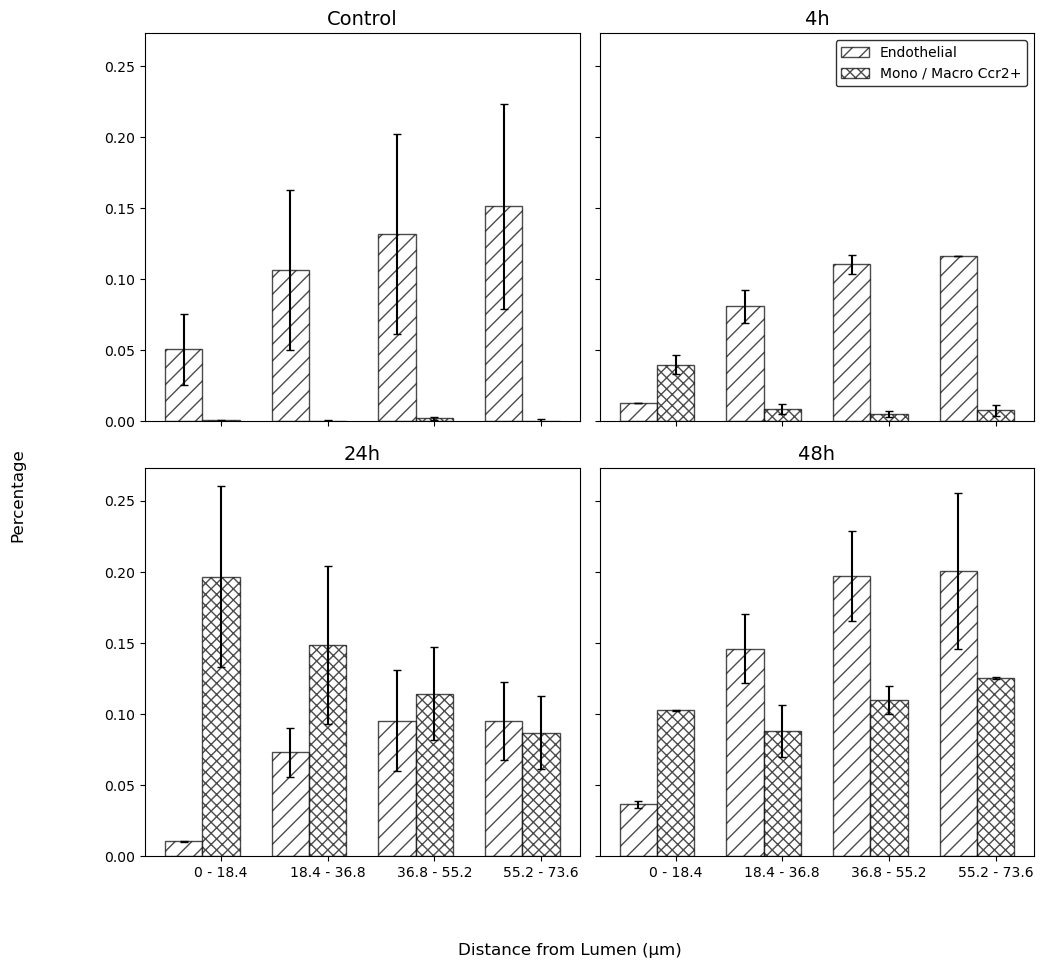

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Number of unique lumen bins
n_bins = len(df_grouped['lumen_bin'].unique())

# Set width of bars
bar_width = 0.35  # Adjust width to better fit the hatching

# Create subplots in a 2x2 grid with a white background
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True, facecolor='white')

# Flatten axes for easier indexing
axes = axes.flatten()

# List of features and corresponding hatches
features = ['endothelial_mean', 'mono_mean']
errors = ['endothelial_se', 'mono_se']
hatches = ['//', 'xxx']  # Denser hatch for Mono
labels = ['Endothelial', 'Mono / Macro Ccr2+']

# Timepoints in specified order
timepoints_order = ['Control', '4h', '24h', '48h']

# Loop over the timepoints and create subplots
for i, timepoint in enumerate(timepoints_order):
    # Filter the data for the current timepoint
    df_timepoint = df_grouped[df_grouped['timepoint'] == timepoint]
    
    # Loop over the features
    for j, feature in enumerate(features):
        # Shift positions for each feature
        offset = (j - 1) * bar_width  # Shift each feature by its index
        
        # Plot the bars with error bars
        axes[i].bar(np.arange(n_bins) + offset, 
                     df_timepoint[feature], 
                     bar_width, 
                     yerr=df_timepoint[errors[j]], 
                     capsize=3, 
                     hatch=hatches[j],  # Apply hatch pattern
                     alpha=0.7, 
                     color='white',  # Set bar color to white
                     edgecolor='black')  # Set edge color to distinguish bars

    # Set titles for each subplot
    axes[i].set_title(f'{timepoint}', fontsize=14)

# Set x-axis tick labels for all subplots
distance_labels = ['0 - 18.4', '18.4 - 36.8', '36.8 - 55.2', '55.2 - 73.6']
for ax in axes:
    ax.set_xticks(np.arange(n_bins))
    ax.set_xticklabels(distance_labels, rotation=0)

# Set same y-axis limits based on the data
y_min = 0  # Set a minimum y limit
y_max = df_grouped[features].max().max() + df_grouped[errors].max().max()  # Set a max limit based on your data
for ax in axes:
    ax.set_ylim(y_min, y_max)

# Create a global legend for the upper right subplot including both features
handles = [
    plt.Rectangle((0, 0), 1, 1, hatch=hatches[0], alpha=0.7, edgecolor='black', facecolor='none'),  # Endothelial
    plt.Rectangle((0, 0), 1, 1, hatch=hatches[1], alpha=0.7, edgecolor='black', facecolor='none')   # Mono
]
legend = axes[1].legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), frameon=True, edgecolor='black')

# Set white background for the legend
legend.get_frame().set_facecolor('white')

# Create a global y-axis title
fig.text(0.04, 0.5, 'Percentage', ha='center', va='center', rotation='vertical', fontsize=12)

# Create a global x-axis title
fig.text(0.5, 0.04, 'Distance from Lumen (µm)', ha='center', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0.1, 0.1, 0.9, 1])  # Make room for the legends and titles
# save plot as svg
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/distance_from_lumen.svg', format='svg')
plt.show()

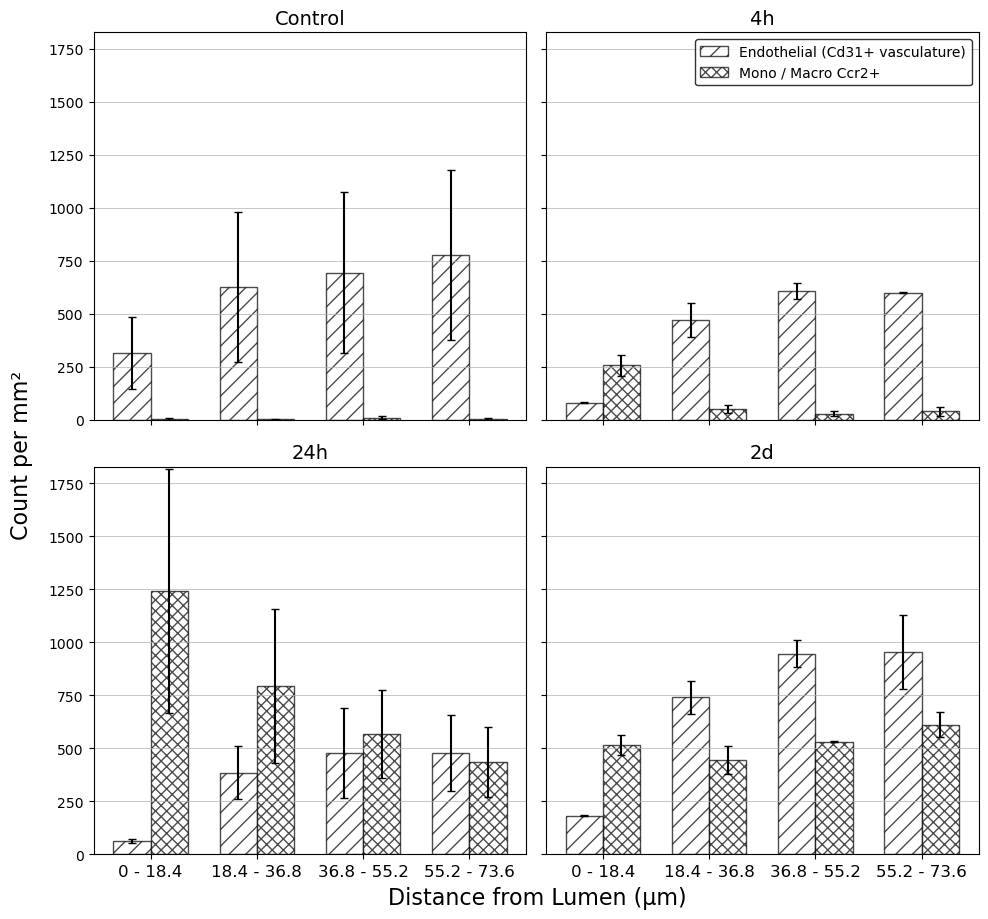

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure timepoints are ordered as Control, 4h, 24h, 2d
timepoint_order = ['Control', '4h', '24h', '2d']

# Calculate mean and SE of count_per_mm2
cell_data_subset_merged = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final_lumen_bins_plot.csv')
grouped_data = cell_data_subset_merged.groupby(['lumen_bin', 'timepoint']).agg(
    endothelial_mean=('endothelial_per_mm2', 'mean'),
    endothelial_std=('endothelial_per_mm2', 'std'),
    endocardial_mean=('endocardial_per_mm2', 'mean'),
    endocardial_std=('endocardial_per_mm2', 'std'),
    mono_mean=('mono_per_mm2', 'mean'),
    mono_std=('mono_per_mm2', 'std')
).reset_index()

# Optional: If the number of samples varies, calculate standard error (std / sqrt(n))
grouped_data['endothelial_se'] = grouped_data['endothelial_std'] / np.sqrt(2)  # Assuming 2-3 FOVs, adjust if needed
grouped_data['endocardial_se'] = grouped_data['endocardial_std'] / np.sqrt(2)
grouped_data['mono_se'] = grouped_data['mono_std'] / np.sqrt(2)

grouped_data['timepoint'] = grouped_data['timepoint'].replace('48h', '2d')

# Number of unique lumen bins
n_bins = len(grouped_data['lumen_bin'].unique())

# Set width of bars
bar_width = 0.35  # Adjust width to better fit the hatching

# Create subplots in a 2x2 grid with a white background
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharex=True, sharey=True, facecolor='white')

# Flatten axes for easier indexing
axes = axes.flatten()

# List of features and corresponding hatches
features = ['endothelial_mean', 'mono_mean']
errors = ['endothelial_se', 'mono_se']
hatches = ['//', 'xxx']  # Denser hatch for Mono
labels = ['Endothelial (Cd31+ vasculature)', 'Mono / Macro Ccr2+']

# Timepoints in specified order
timepoints_order = ['Control', '4h', '24h', '2d']

# Loop over the timepoints and create subplots
for i, timepoint in enumerate(timepoints_order):
    # Filter the data for the current timepoint
    df_timepoint = grouped_data[grouped_data['timepoint'] == timepoint]
    
    # Loop over the features
    for j, feature in enumerate(features):
        # Shift positions for each feature
        offset = (j - 0.5) * bar_width  # Shift each feature by its index
        
        # Plot the bars with error bars
        axes[i].bar(np.arange(n_bins) + offset, 
                     df_timepoint[feature], 
                     bar_width, 
                     yerr=df_timepoint[errors[j]], 
                     capsize=3, 
                     hatch=hatches[j],  # Apply hatch pattern
                     alpha=0.7, 
                     color='white',  # Set bar color to white
                     edgecolor='black')  # Set edge color to distinguish bars

    # Set titles for each subplot
    axes[i].set_title(f'{timepoint}', fontsize=14)

# Set x-axis tick labels for all subplots
distance_labels = ['0 - 18.4', '18.4 - 36.8', '36.8 - 55.2', '55.2 - 73.6']
for ax in axes:
    ax.set_xticks(np.arange(n_bins))
    ax.set_xticklabels(distance_labels, rotation=0, fontsize=12)
    ax.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5, zorder=1)  # Add grid lines for y-axis

# Set same y-axis limits based on the data
y_min = 0  # Set a minimum y limit
y_max = grouped_data[features].max().max() + grouped_data[errors].max().max() + 10  # Set a max limit based on your data
for ax in axes:
    ax.set_ylim(y_min, y_max)

# Create a global legend for the upper right subplot including both features
handles = [
    plt.Rectangle((0, 0), 1, 1, hatch=hatches[0], alpha=0.7, edgecolor='black', facecolor='none'),  # Endothelial
    plt.Rectangle((0, 0), 1, 1, hatch=hatches[1], alpha=0.7, edgecolor='black', facecolor='none')   # Mono
]
legend = axes[1].legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), frameon=True, edgecolor='black')

# Set white background for the legend
legend.get_frame().set_facecolor('white')

# Create a global y-axis title closer to the subplots
fig.text(0.09, 0.54, 'Count per mm²', ha='center', va='center', rotation='vertical', fontsize=16)

# Create a global x-axis title closer to the subplots
fig.text(0.52, 0.09, 'Distance from Lumen (µm)', ha='center', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.1, 0.1, 0.9, 1])  # Make room for the legends and titles

# Save plot as svg and png with tight bounding box
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/distance_from_lumen_areanorm.svg', format='svg', bbox_inches='tight')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/distance_from_lumen_areanorm.png', dpi=300, bbox_inches='tight')

plt.show()

## Distance from lumen explanation plot

In [13]:
# for sample 24h_83, get the cell type information for each cell, and read in the reannotated regions, and lumen_bin
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final.csv')
sample = '24h_83'
sample_paths = SamplePaths(sample)
cell_data_subset = cell_data[cell_data['fov'] == sample]

reannotated_regions = tifffile.imread(sample_paths.reannotated_regions_path)
lumen_bins = tifffile.imread(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/lumen_expanded_masks/{sample}_lumen_layers.tif')

import zarr
import dask.array
store = tifffile.imread(sample_paths.image_path, aszarr=True)
cache = zarr.LRUStoreCache(store, max_size=2**30)
zobj = zarr.open(cache, mode='r')
data = [
    zobj[int(dataset['path'])]
    for dataset in zobj.attrs['multiscales'][0]['datasets']
]
data = [dask.array.from_zarr(z) for z in data]
n_channels = data[0].shape[0]
for z in data:
    print(z)

dask.array<from-zarr, shape=(18, 28381, 30238), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
dask.array<from-zarr, shape=(18, 14191, 15119), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
dask.array<from-zarr, shape=(18, 7096, 7560), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
dask.array<from-zarr, shape=(18, 3548, 3780), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
dask.array<from-zarr, shape=(18, 1774, 1890), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
dask.array<from-zarr, shape=(18, 887, 945), dtype=uint16, chunksize=(1, 887, 945), chunktype=numpy.ndarray>


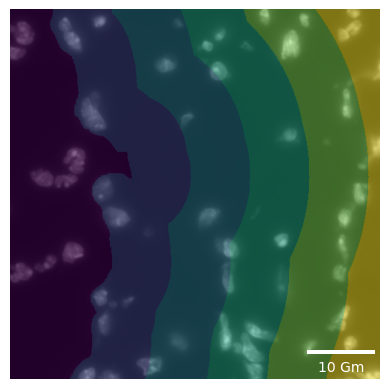

In [14]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

# for channel 0, plot the region from 18065,20009 to 18565,20509
plt.imshow(data[0][0, 18065:18565, 20009:20509], cmap='gray')
roi_coords = [18065, 18565, 20009, 20509]

reannotated_CROP = reannotated_regions[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
lumen_bins_CROP = lumen_bins[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]

plt.imshow(lumen_bins_CROP, cmap='viridis', alpha=0.5)
# remove the x axis and y axis labels
plt.axis('off')

# Calculate the number of pixels for 25 microns
microns_per_pixel = 0.00000023
pixels_for_25_microns = 25 / microns_per_pixel

x_axis_length = lumen_bins_CROP.shape[1]
length_fraction = pixels_for_25_microns / x_axis_length

# Add scale bar (1 pixel is 0.23 µm) spanning 25 microns
scalebar = ScaleBar(microns_per_pixel, location='lower right', color='white', box_alpha=0, scale_loc='bottom')
scalebar.dx = pixels_for_25_microns

plt.gca().add_artist(scalebar)
plt.show()

In [51]:
channel_2 = data[0][5, roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]  # Yellow

In [53]:
channel_2.max().compute()

62519

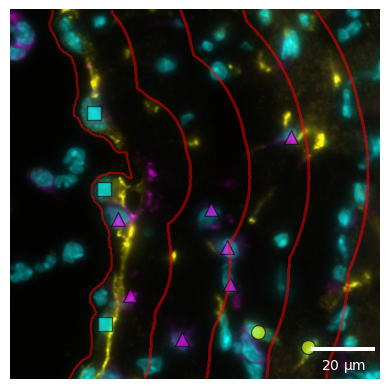

In [58]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
from skimage import segmentation

# Define the region of interest
roi_coords = [18065, 18565, 20009, 20509]

# Extract the region of interest for each channel
channel_0 = data[0][0, roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]  # Cyan
channel_1 = data[0][7, roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]  # Magenta
channel_2 = data[0][5, roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]  # Yellow

# Normalize the channels to the range [0, 1]
channel_0 = (channel_0 - channel_0.min()) / (channel_0.max() - channel_0.min())
channel_1 = (channel_1 - channel_1.min()) / (channel_1.max() - channel_1.min())
channel_2 = (channel_2 - channel_2.min()) / (channel_2.max()+3000 - channel_2.min())

# Create RGB components for cyan, magenta, and yellow
cyan = np.dstack((np.zeros_like(channel_0), channel_0, channel_0))  # Cyan: G + B
magenta = np.dstack((channel_1, np.zeros_like(channel_1), channel_1))  # Magenta: R + B
yellow = np.dstack((channel_2, channel_2, np.zeros_like(channel_2)))  # Yellow: R + G

# Combine the RGB components
rgb_image = np.clip(cyan + magenta + yellow, 0, 1)

# Plot the RGB image
plt.imshow(rgb_image)

# Overlay the reannotated regions and lumen bins
reannotated_CROP = reannotated_regions[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
lumen_bins_CROP = lumen_bins[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]

# show contours for reannotated regions - all contours should be
#plt.contour(lumen_bins_CROP, colors='red', linewidths=2, alpha=0.5)
lumen_boundaries = segmentation.find_boundaries(lumen_bins_CROP, mode='outer')
plt.contour(lumen_boundaries, colors='red', linewidths=1, alpha=0.5)  # Uniform contour intensity

# add text - 0 for where lumen_bin == 0, up to 5
#for i in range(0, 6):
#    plt.text(10 + i*90, 50, f'{i}', color='white', fontsize=20)

# at position 10, 100, add text lumen_bin
#plt.text(5, 170, f'Lumen', color='white', fontsize=16, rotation=90)

#plt.imshow(reannotated_CROP, cmap='viridis', alpha=0.5)
#plt.imshow(lumen_bins_CROP, cmap='viridis', alpha=0.5)
plt.axis('off')

# add white points for all centroids in the crop
centroids = cell_data_subset[(cell_data_subset['X_centroid'] >= roi_coords[2]) & (cell_data_subset['X_centroid'] < roi_coords[3]) & (cell_data_subset['Y_centroid'] >= roi_coords[0]) & (cell_data_subset['Y_centroid'] < roi_coords[1])]
#plt.scatter(centroids['X_centroid'] - roi_coords[2], centroids['Y_centroid'] - roi_coords[0], color='white', marker='.')

# cells that are mono/macrophages should be in magenta, and the size should be bigger, cells that are endothelial should be in yellow also bigger, cells that are endocardial should be in cyan
mono_macrophages = centroids[centroids['final_cell_type'] == 'Mono / Macros Ccr2+']
endothelial = centroids[centroids['final_cell_type'] == 'Endothelial cells']
endocardial = centroids[centroids['final_cell_type'] == 'Endocardial cells']

# the cells should have an outline monos should be squares, endothelial should be circles, endocardial should be triangles, no fill
plt.scatter(mono_macrophages['X_centroid'] - roi_coords[2], mono_macrophages['Y_centroid'] - roi_coords[0], marker='^', s=100, edgecolor='black', color='magenta', alpha=0.6)
plt.scatter(endothelial['X_centroid'] - roi_coords[2], endothelial['Y_centroid'] - roi_coords[0], marker='o', s=100, edgecolor='black', color='yellow', alpha=0.6)
plt.scatter(endocardial['X_centroid'] - roi_coords[2], endocardial['Y_centroid'] - roi_coords[0], marker='s', s=100, edgecolor='black', color='cyan', alpha=0.6)


#plt.scatter(endothelial['X_centroid'] - roi_coords[2], endothelial['Y_centroid'] - roi_coords[0], marker='*', s=100, edgecolor='black')
# triangle
#plt.scatter(endocardial['X_centroid'] - roi_coords[2], endocardial['Y_centroid'] - roi_coords[0], marker='.', s=100, edgecolor='black')


# Add scale bar (1 pixel is 0.23 µm)
microns_per_pixel = 0.00000023
scalebar = ScaleBar(microns_per_pixel, location='lower right', color='white', box_alpha=0, scale_loc='bottom')
plt.gca().add_artist(scalebar)
#plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/24h_83_region_of_interest_dummy.svg', format='svg', bbox_inches='tight')
#plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/24h_83_region_of_interest_dummy.png', dpi=300, bbox_inches='tight')
plt.show()

## Plots highlighting different cell types across all regions

In [7]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final.csv')
cell_data_subset = cell_data[cell_data['final_cell_type'] != 'exclude']
region_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/region_matching.csv')

In [11]:
# get count per timepoint, fov final_cell_type combination
cell_data_subset_grouped = cell_data_subset.groupby(['timepoint', 'fov', 'region_name', 'final_cell_type']).size().reset_index(name='count')
all_area = cell_data_subset.groupby(['timepoint', 'fov', 'final_cell_type']).size().reset_index(name='count')
# add column to all_area 
all_area['region_name'] = 'all'
# add all_area to cell_data_subset_grouped
cell_data_subset_grouped = pd.concat([cell_data_subset_grouped, all_area])
# get total number of cells per timepoint, fov, region_name
cell_data_subset_grouped_total = cell_data_subset_grouped.groupby(['timepoint', 'fov', 'region_name']).agg(total_count=('count', 'sum')).reset_index()
# add total count to cell_data_subset_grouped
cell_data_subset_grouped = pd.merge(cell_data_subset_grouped, cell_data_subset_grouped_total, on=['timepoint', 'fov', 'region_name'], how='left')
cell_data_subset_grouped['percentage'] = cell_data_subset_grouped['count'] / cell_data_subset_grouped['total_count']
cell_data_subset_grouped['area_px'] = -1


# get area per region
for sample in cell_data_subset_grouped.fov.unique():
    sample_paths = SamplePaths(sample)
    reannotated_regions = tifffile.imread(sample_paths.reannotated_regions_path)
   

    # based on region_name in region_matching, get area in pixels
    for region in cell_data_subset_grouped.region_name.unique():
        if region == 'all':

            cell_data_subset_grouped.loc[(cell_data_subset_grouped['fov'] == sample) & (cell_data_subset_grouped['region_name'] == region), 'area_px'] = np.sum(np.logical_and(np.logical_and(reannotated_regions != 1, reannotated_regions != 4), reannotated_regions!= 8)) # not lumen, not ignore and not background
        else:
            region_id = region_matching[region_matching['region_name'] == region]['region_id'].values[0]
            cell_data_subset_grouped.loc[(cell_data_subset_grouped['fov'] == sample) & (cell_data_subset_grouped['region_name'] == region), 'area_px'] = np.sum(reannotated_regions == region_id)
        
cell_data_subset_grouped['area_um'] = cell_data_subset_grouped['area_px'] * 0.23 * 0.23 # convert area from pixels to micrometers
cell_data_subset_grouped['count_per_um2'] = cell_data_subset_grouped['count'] / cell_data_subset_grouped['area_um']
cell_data_subset_grouped['count_per_mm2'] = cell_data_subset_grouped['count_per_um2'] * 1000000

In [12]:
cell_data_subset_grouped.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/region_quantifications_plot.csv', index=False)

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_86962/2044620077.py:110: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=color, edgecolor='black') for color in colors]


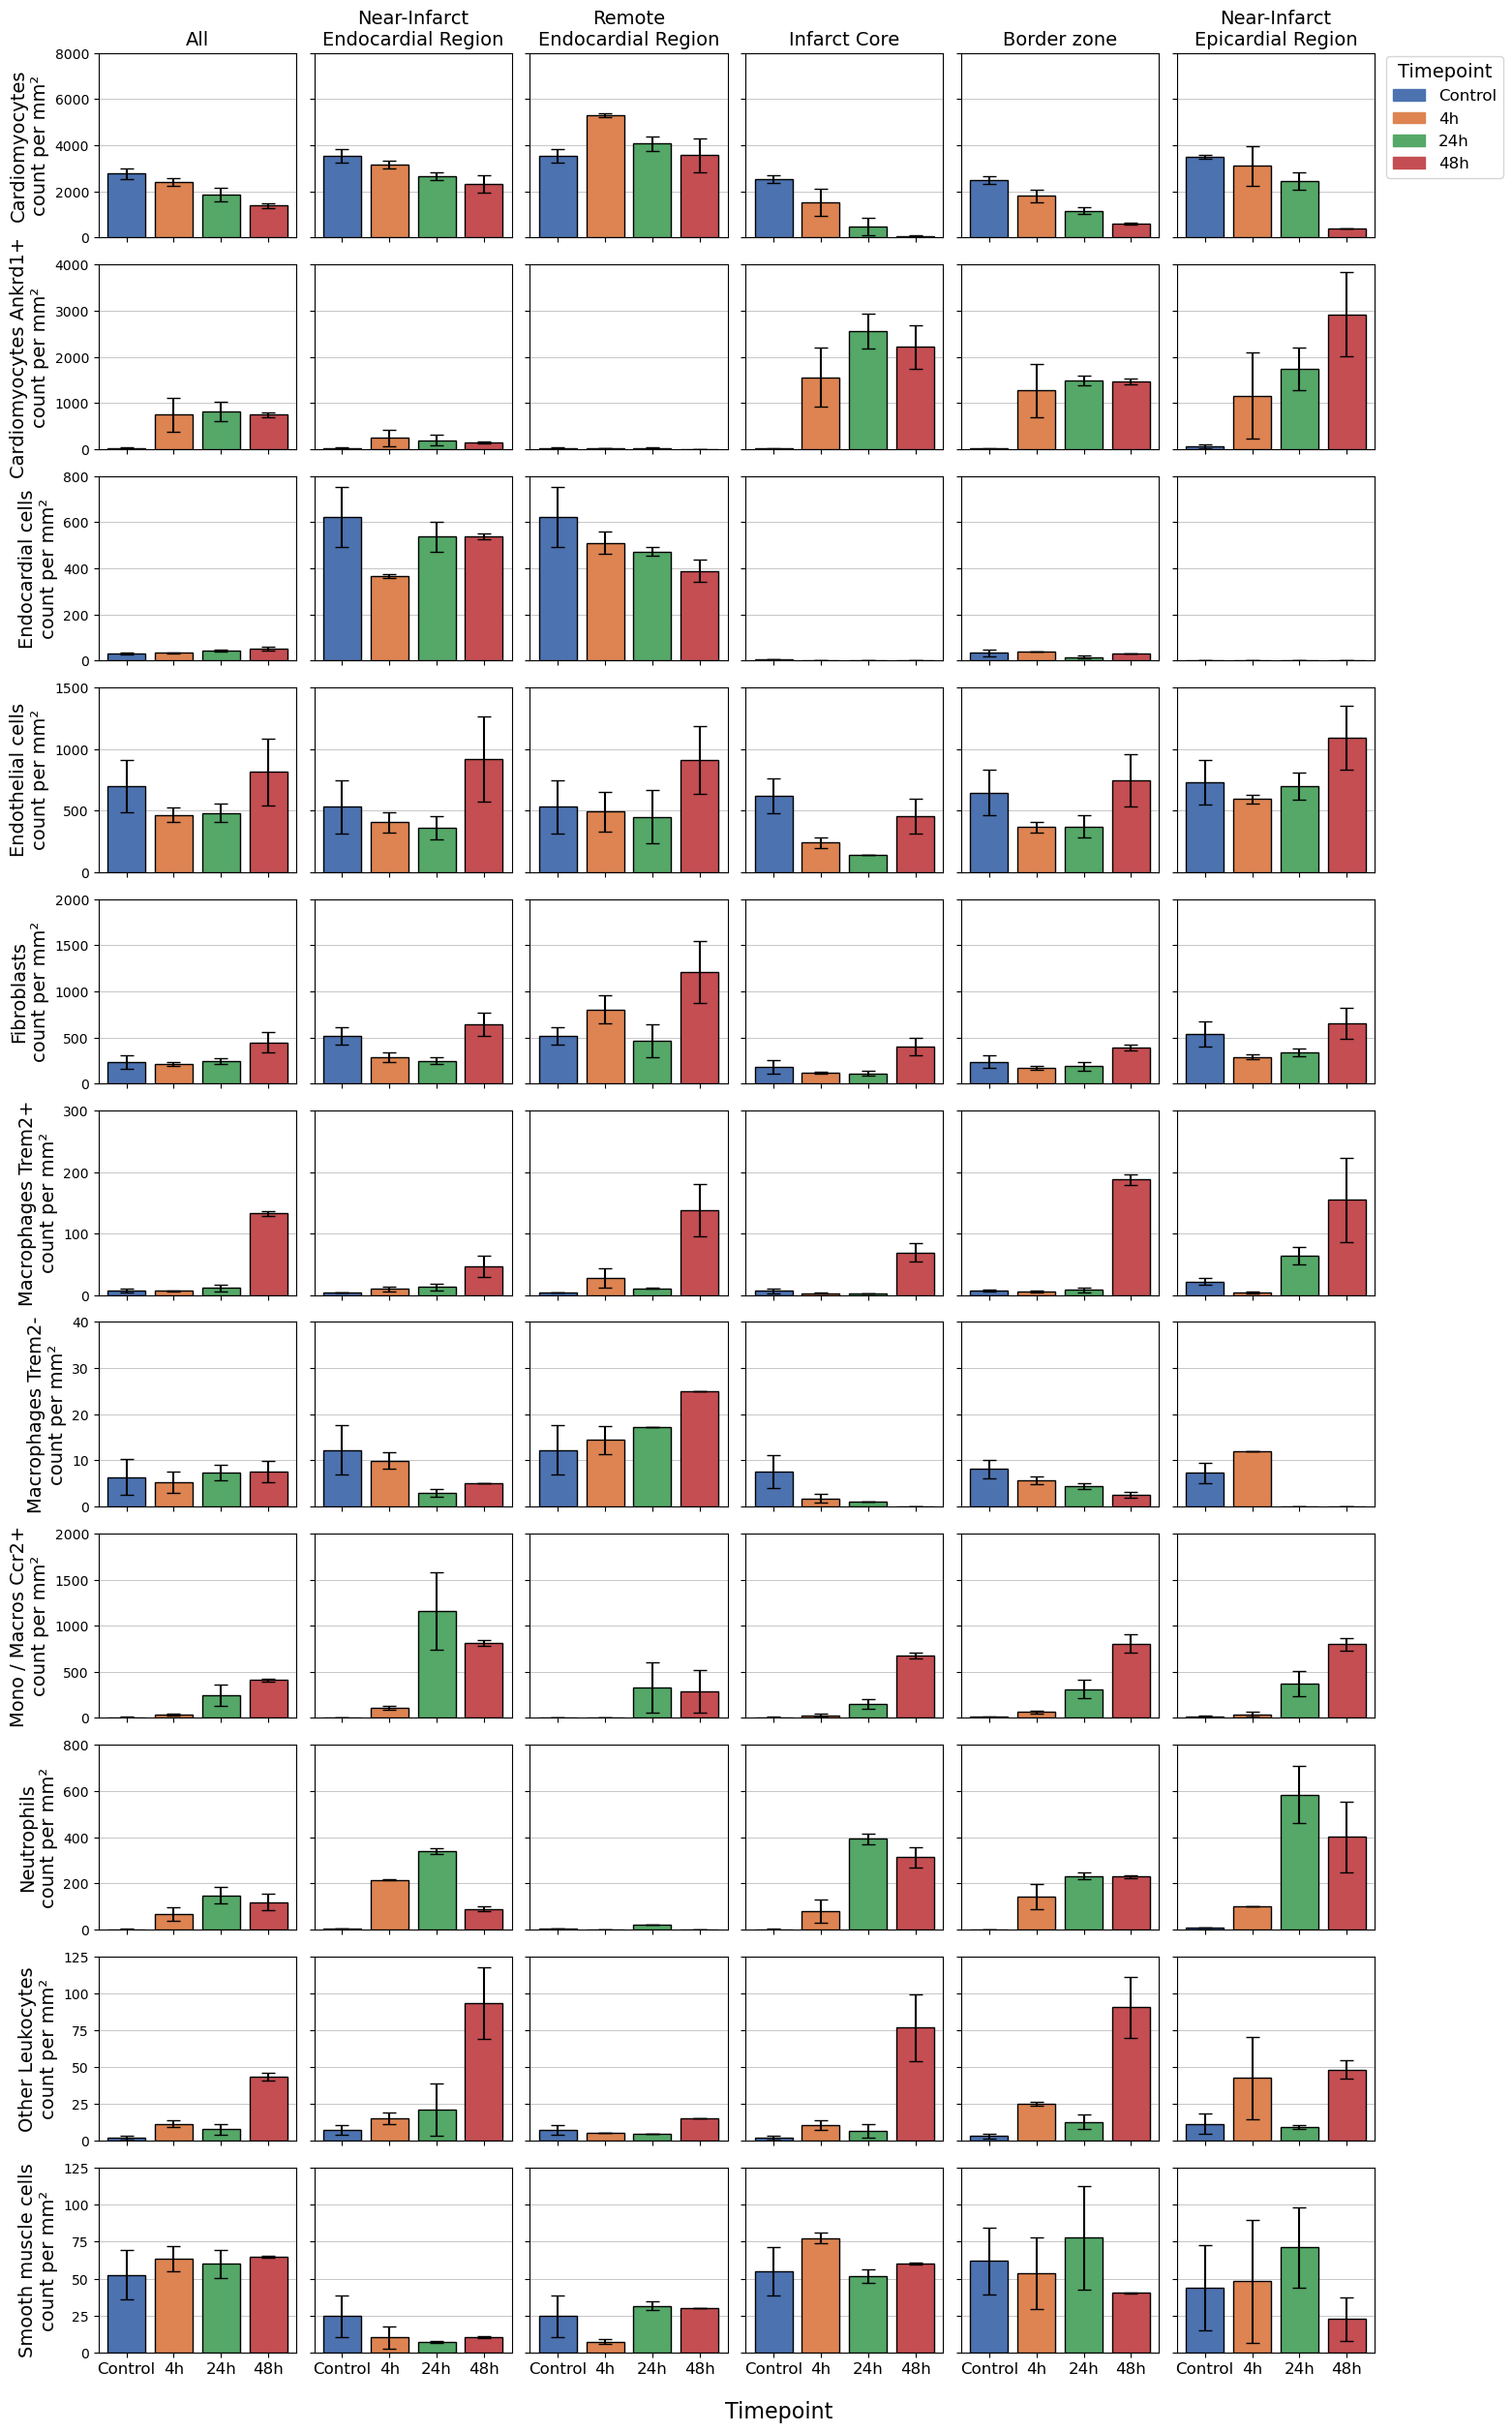

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

cell_data_subset_grouped = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/region_quantifications_plot.csv')
# Ensure timepoints are ordered as Control, 4h, 24h, 48h
timepoint_order = ['Control', '4h', '24h', '48h']

# Calculate mean and SE of count_per_mm2
grouped_data = cell_data_subset_grouped.groupby(['final_cell_type', 'region_name', 'timepoint']).agg(
    mean_count=('count_per_mm2', 'mean'),
    se_count=('count_per_mm2', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Fill NA values with 0
grouped_data.fillna(0, inplace=True)

# Mapping dictionary for region names
region_mapping = {
    'all': 'All',
    'border_zone': 'Border zone',
    'endocardial_region': 'Near-Infarct\nEndocardial Region',
    'epicardial_region': 'Near-Infarct\nEpicardial Region',
    'infarct_core': 'Infarct Core',
    'other_cardiac_tissue': 'Other tissue',  # Corrected the key to match the correct region name
    'remote_endocardial_region': 'Remote\nEndocardial Region'
}

# Apply the mapping to the region_name column
grouped_data['region_name'] = grouped_data['region_name'].map(region_mapping)

# Get unique cell types and regions
cell_types = grouped_data['final_cell_type'].unique()
regions = grouped_data['region_name'].unique()

# Exclude "Other tissue" from regions
regions = [region for region in regions if region != 'Other tissue']

# Reorder the regions as specified
regions_order = [
    'All',
    'Near-Infarct\nEndocardial Region',
    'Remote\nEndocardial Region',
    'Infarct Core',
    'Border zone',
    'Near-Infarct\nEpicardial Region'
]
regions = [region for region in regions_order if region in regions]

# Create a DataFrame with all combinations of cell types, regions, and timepoints, filling missing values with 0
full_index = pd.MultiIndex.from_product([cell_types, regions, timepoint_order], 
                                        names=['final_cell_type', 'region_name', 'timepoint'])
grouped_data = grouped_data.set_index(['final_cell_type', 'region_name', 'timepoint']).reindex(full_index, fill_value=0).reset_index()

# Adjust Control values for remote_endocardial_region
grouped_data.loc[(grouped_data['timepoint'] == 'Control') & (grouped_data['region_name'] == 'Remote\nEndocardial Region'), 'mean_count'] = grouped_data.loc[(grouped_data['timepoint'] == 'Control') & (grouped_data['region_name'] == 'Near-Infarct\nEndocardial Region'),'mean_count'].values
grouped_data.loc[(grouped_data['timepoint'] == 'Control') & (grouped_data['region_name'] == 'Remote\nEndocardial Region'), 'se_count'] = grouped_data.loc[(grouped_data['timepoint'] == 'Control') & (grouped_data['region_name'] == 'Near-Infarct\nEndocardial Region'),'se_count'].values

# Create the NxM grid of plots
N = len(cell_types)
M = len(regions)
fig, axes = plt.subplots(N, M, figsize=(M * 3, N * 2.5), sharey=False)  # Reduce figure size

# Define a color palette for the timepoints using seaborn
colors = sns.color_palette("deep", len(timepoint_order))

# Loop through each cell type and region to plot the data
for i, cell_type in enumerate(cell_types):
    # Determine the y-axis range for the current cell type across all regions
    y_max = grouped_data[grouped_data['final_cell_type'] == cell_type]['mean_count'].max() + grouped_data[grouped_data['final_cell_type'] == cell_type]['se_count'].max()
    
    for j, region in enumerate(regions):
        # Filter the data for the current cell type and region
        df_filtered = grouped_data[(grouped_data['final_cell_type'] == cell_type) & 
                                   (grouped_data['region_name'] == region)]
        
        # Plot the data with bars and error bars
        bars = axes[i, j].bar(df_filtered['timepoint'], df_filtered['mean_count'], 
                              yerr=df_filtered['se_count'], capsize=5, color=colors, edgecolor='black', zorder=3)
        
        # Set titles and labels
        if j == 0:
            axes[i, j].set_ylabel(f'{cell_type}\ncount per mm²', fontsize=14)  # Increase fontsize for y-axis titles
        
        # Set x-axis ticks
        axes[i, j].set_xticks(np.arange(len(timepoint_order)))
        axes[i, j].set_xticklabels(timepoint_order, fontsize=12)  # Increase fontsize for x-tick labels
        
        # Set y-axis limit for the entire row (same for each region)
        axes[i, j].set_ylim(0, y_max)
        
        # Only show y-axis labels on the leftmost subplot
        if j != 0:
            axes[i, j].set_yticklabels([])
        
        # Only show x-axis labels on the bottom row
        if i != N - 1:
            axes[i, j].set_xticklabels([])
        
        # Extend y-axis lines across ticks
        axes[i, j].grid(True, which='both', axis='y', linestyle='-', linewidth=0.5, zorder=1)  # Change linestyle to '-'
        axes[i, j].set_yticks(axes[i, 0].get_yticks())  # Ensure all subplots have the same y-ticks

# Set column titles
for ax, col in zip(axes[0], regions):
    ax.set_title(col, fontsize=14)  # Increase fontsize for region names

# Add a legend for the timepoints to the right of all subplots
handles = [plt.Rectangle((0, 0), 1, 1, color=color, edgecolor='black') for color in colors]
fig.legend(handles, timepoint_order, loc='upper right', title='Timepoint', fontsize=12, title_fontsize=14, bbox_to_anchor=(0.92, 0.93))  # Increase fontsize for legend

# Add a global x-axis title closer to the subplots
fig.text(0.5, 0.04, 'Timepoint', ha='center', fontsize=16)

# Adjust layout to be more compact
plt.tight_layout(rect=[0.05, 0.05, 0.85, 0.95], h_pad=1, w_pad=1)  # Adjust rect to make room for the legend
#plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/cell_count_plots.png', dpi=300,  bbox_inches='tight')
#plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/cell_count_plots.svg', format='svg',  bbox_inches='tight')

plt.show()

## Creates Endothelial - immune distance plots

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

sample_list = ['Control_12', 'Control_13', 'Control_14', '4h_96', '4h_97', '24h_83', '24h_86', '48h_76', '48h_79']
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final.csv')

# Filter endocardial cells and myeloid cells
endocardial_cells = cell_data[cell_data['final_cell_type'] == 'Endocardial cells']
myeloid_cell_types = ['Mono / Macros Ccr2+','Macrophages Trem2+','Macrophages Trem2-','Other Leukocytes' ]
myeloid_cell_types = ['Mono / Macros Ccr2+']
myeloid_cells = cell_data[cell_data['final_cell_type'].isin(myeloid_cell_types)]

# Function to calculate the closest three distances
def calculate_closest_distances(endocardial_cells, myeloid_cells):
    distances = []
    for sample in sample_list:
        for timepoint in endocardial_cells['timepoint'].unique():
            endo_sample = endocardial_cells[(endocardial_cells['fov'] == sample) & (endocardial_cells['timepoint'] == timepoint)]
            myeloid_sample = myeloid_cells[(myeloid_cells['fov'] == sample) & (myeloid_cells['timepoint'] == timepoint)]
            
            if len(myeloid_sample) == 0:
                continue
            
            tree = cKDTree(myeloid_sample[['X_centroid', 'Y_centroid']])
            for _, endo_cell in endo_sample.iterrows():
                dist, _ = tree.query([endo_cell['X_centroid'], endo_cell['Y_centroid']], k=3)
                distances.append({
                    'fov': sample,
                    'timepoint': timepoint,
                    'distance_1': dist[0],
                    'distance_2': dist[1],
                    'distance_3': dist[2]
                })
    return pd.DataFrame(distances)

# Calculate distances
distances_df = calculate_closest_distances(endocardial_cells, myeloid_cells)

# Melt the DataFrame for plotting
distances_melted = distances_df.melt(id_vars=['fov', 'timepoint'], value_vars=['distance_1', 'distance_2', 'distance_3'], var_name='neighbor', value_name='distance')

# Convert distances to micrometers if needed (assuming distances are in pixels and 1 pixel = 0.23 µm)
distances_melted['distance'] = distances_melted['distance'] * 0.23

distances_grouped = distances_melted.groupby(['timepoint', 'fov']).agg(
    mean_distance=('distance', 'mean'),
#    std_distance=('distance', 'std')
).reset_index()

# Calculate mean and standard deviation or standard error for each timepoint
distances_grouped_grouped = distances_grouped.groupby(['timepoint']).agg(
    mean_distance=('mean_distance', 'mean'),
    se_distance=('mean_distance', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()


In [12]:
import statannot

In [10]:
distances_grouped

timepoint         fov  mean_distance
0       24h      24h_83      33.637588
1       24h      24h_86      80.192387
2       48h      48h_76      78.876420
3       48h      48h_79      45.636805
4        4h       4h_96     177.497479
5        4h       4h_97     206.327715
6   Control  Control_12     254.213775
7   Control  Control_13     441.769445
8   Control  Control_14     479.519498

In [207]:
distances_grouped_grouped.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/closest_neighbor_distances.csv', index=False)

In [4]:
distances_grouped_grouped = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/closest_neighbor_distances.csv')

In [5]:
distances_grouped_grouped

timepoint  mean_distance  se_distance
0       24h      56.914987    23.277399
1       48h      62.256612    16.619807
2        4h     191.912597    14.415118
3   Control     391.834239    69.667809

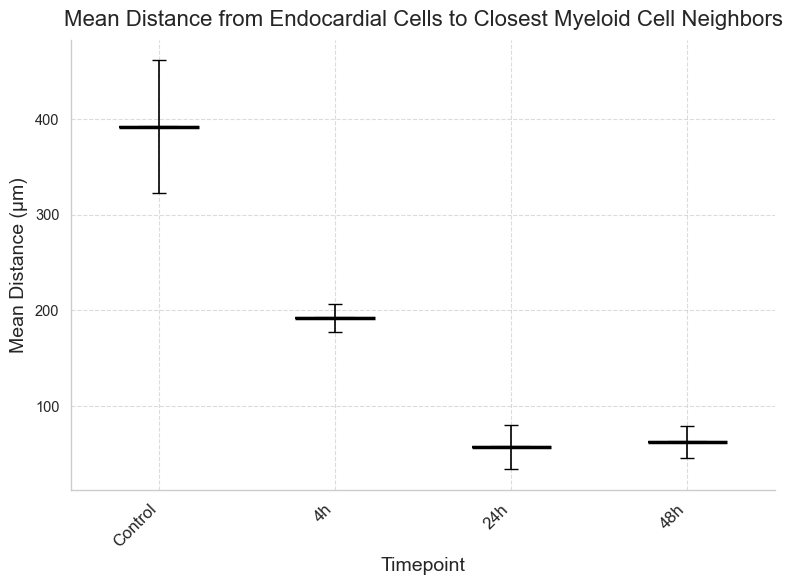

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming distances_grouped_grouped is already loaded and has columns: 'timepoint', 'mean_distance', 'se_distance'

# Ensure timepoints are ordered as 'Control', '4h', '24h', '48h'
timepoint_order = ['Control', '4h', '24h', '48h']
distances_grouped['timepoint'] = pd.Categorical(distances_grouped['timepoint'], categories=timepoint_order, ordered=True)

# Set the colors for the boxplots
colors = ['blue', 'orange', 'green', 'red']

# Create the boxplot
fig, ax = plt.subplots(figsize=(8, 6))

# Create boxplot
boxprops = dict(linewidth=1.5, color='black')
medianprops = dict(linewidth=2.5, color='black')
whiskerprops = dict(linewidth=1.5, color='black')
capprops = dict(linewidth=1.5, color='black')

bp = ax.boxplot([distances_grouped[distances_grouped['timepoint'] == tp]['mean_distance'] for tp in timepoint_order],
                patch_artist=True, showfliers=False, boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add error bars for SE
for i, timepoint in enumerate(timepoint_order):
    subset = distances_grouped_grouped[distances_grouped_grouped['timepoint'] == timepoint]
    mean = subset['mean_distance'].mean()
    se = subset['se_distance'].mean()
    ax.errorbar(i + 1, mean, yerr=se, fmt='none', c='black', capsize=5)

# Customize the plot
ax.set_title('Mean Distance from Endocardial Cells to Closest Myeloid Cell Neighbors', fontsize=16, pad=10)
ax.set_xlabel('Timepoint', fontsize=14, labelpad=5)
ax.set_ylabel('Mean Distance (µm)', fontsize=14, labelpad=5)
ax.set_xticklabels(timepoint_order, rotation=45, ha='right', fontsize=12)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the plot
plt.tight_layout()

plt.show()

In [14]:
distances_grouped

timepoint         fov  mean_distance
0       24h      24h_83      33.637588
1       24h      24h_86      80.192387
2       48h      48h_76      78.876420
3       48h      48h_79      45.636805
4        4h       4h_96     177.497479
5        4h       4h_97     206.327715
6   Control  Control_12     254.213775
7   Control  Control_13     441.769445
8   Control  Control_14     479.519498

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_16870/1744321314.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distances_grouped['se_distance'] = distances_grouped['std_distance'] / np.sqrt(distances_grouped.groupby('timepoint')['mean_distance'].transform('count'))


Comparison: Control vs 4h, p-value: 0.11440843753306609
Comparison: Control vs 24h, p-value: 0.03533465563279469
Comparison: Control vs 48h, p-value: 0.03599051026667229


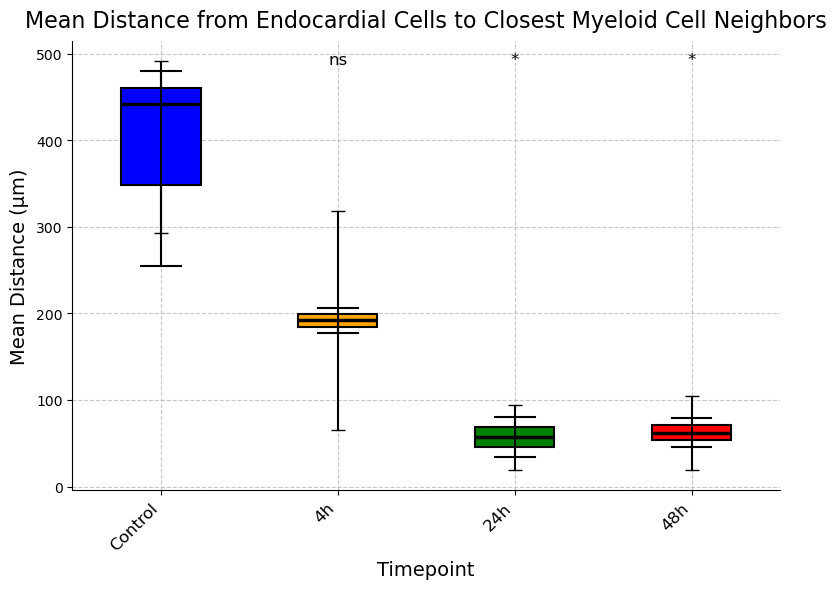

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Assuming distances_grouped is already defined and has columns: 'timepoint', 'mean_distance', 'std_distance'

# Ensure timepoints are ordered as 'Control', '4h', '24h', '48h'
timepoint_order = ['Control', '4h', '24h', '48h']
distances_grouped['timepoint'] = pd.Categorical(distances_grouped['timepoint'], categories=timepoint_order, ordered=True)

# Calculate SE from SD and sample size
distances_grouped['se_distance'] = distances_grouped['std_distance'] / np.sqrt(distances_grouped.groupby('timepoint')['mean_distance'].transform('count'))

# Set the colors for the boxplots
colors = ['blue', 'orange', 'green', 'red']

# Create the boxplot
fig, ax = plt.subplots(figsize=(8, 6))

# Create boxplot
boxprops = dict(linewidth=1.5, color='black')
medianprops = dict(linewidth=2.5, color='black')
whiskerprops = dict(linewidth=1.5, color='black')
capprops = dict(linewidth=1.5, color='black')

bp = ax.boxplot([distances_grouped[distances_grouped['timepoint'] == tp]['mean_distance'] for tp in timepoint_order],
                patch_artist=True, showfliers=False, boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add error bars for SE
for i, timepoint in enumerate(timepoint_order):
    subset = distances_grouped[distances_grouped['timepoint'] == timepoint]
    mean = subset['mean_distance'].mean()
    se = subset['se_distance'].mean()
    ax.errorbar(i + 1, mean, yerr=se, fmt='none', c='black', capsize=5)

# Perform statistical tests and add annotations
control_data = distances_grouped[distances_grouped['timepoint'] == 'Control']['mean_distance']
comparisons = [(0, i) for i in range(1, len(timepoint_order))]
p_values = []
for i, timepoint in enumerate(timepoint_order[1:], start=1):
    test_data = distances_grouped[distances_grouped['timepoint'] == timepoint]['mean_distance']
    stat, p_value = ttest_ind(control_data, test_data)
    p_values.append(p_value)
    print(f"Comparison: Control vs {timepoint}, p-value: {p_value}")

# Add manual annotations based on p-values
for i, p_value in enumerate(p_values, start=1):
    if p_value < 0.001:
        annotation = '***'
    elif p_value < 0.01:
        annotation = '**'
    elif p_value < 0.05:
        annotation = '*'
    else:
        annotation = 'ns'
    
    y_max = max(distances_grouped['mean_distance']) + 5  # Adjust the y position of the annotation
    ax.text(i + 1, y_max, annotation, ha='center', va='bottom', fontsize=12, color='black')

# Customize the plot
ax.set_title('Mean Distance from Endocardial Cells to Closest Myeloid Cell Neighbors', fontsize=16, pad=10)
ax.set_xlabel('Timepoint', fontsize=14, labelpad=5)
ax.set_ylabel('Mean Distance (µm)', fontsize=14, labelpad=5)
ax.set_xticklabels(timepoint_order, rotation=45, ha='right', fontsize=12)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the plot
plt.tight_layout()
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/closest_neighbor_distances.png', dpi=300, bbox_inches='tight')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/closest_neighbor_distances.svg', dpi=300, bbox_inches='tight')

plt.show()

In [21]:
distances_grouped

timepoint         fov  mean_distance  std_distance  se_distance
0       24h      24h_83      33.637588     29.012801    20.515148
1       24h      24h_86      80.192387     76.310553    53.959709
2       48h      48h_76      78.876420     85.996047    60.808388
3       48h      48h_79      45.636805     34.938745    24.705423
4        4h       4h_96     177.497479    131.488847    92.976655
5        4h       4h_97     206.327715    225.035096   159.123843
6   Control  Control_12     254.213775    104.698075    60.447462
7   Control  Control_13     441.769445    188.926857   109.076972
8   Control  Control_14     479.519498    221.820376   128.068054

In [25]:
distances_grouped

timepoint         fov  mean_distance
0       24h      24h_83      33.637588
1       24h      24h_86      80.192387
2       48h      48h_76      78.876420
3       48h      48h_79      45.636805
4        4h       4h_96     177.497479
5        4h       4h_97     206.327715
6   Control  Control_12     254.213775
7   Control  Control_13     441.769445
8   Control  Control_14     479.519498

In [26]:
import numpy as np

# Example data points
data_points = np.array([254.213775, 441.769445, 479.519498])

# Calculate the sample mean
mean = np.mean(data_points)

# Calculate the standard deviation (SD)
sd = np.std(data_points, ddof=1)

# Calculate the standard error (SE)
se = sd / np.sqrt(len(data_points))

print(f"Data points: {data_points}")
print(f"Mean: {mean}")
print(f"Standard Deviation (SD): {sd}")
print(f"Standard Error (SE): {se}")

Data points: [254.213775 441.769445 479.519498]
Mean: 391.8342393333334
Standard Deviation (SD): 120.66818461329153
Standard Error (SE): 69.66780886910733


/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_16870/952056370.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distances_grouped_grouped = distances_grouped.groupby(['timepoint']).agg(


Comparison: Control vs 4h, p-value: 0.11440843753306609
Comparison: Control vs 24h, p-value: 0.03533465563279469
Comparison: Control vs 48h, p-value: 0.03599051026667229


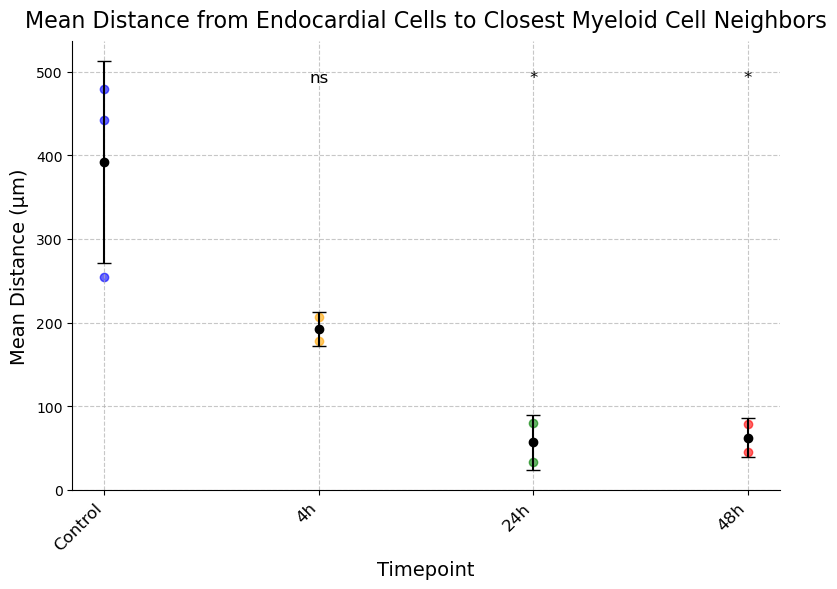

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Assuming distances_grouped and distances_grouped_grouped are already defined
# distances_grouped has columns: 'timepoint', 'mean_distance'
# distances_grouped_grouped has columns: 'timepoint', 'mean_distance', 'se_distance'

# Ensure timepoints are ordered as 'Control', '4h', '24h', '48h'
timepoint_order = ['Control', '4h', '24h', '48h']
distances_grouped['timepoint'] = pd.Categorical(distances_grouped['timepoint'], categories=timepoint_order, ordered=True)
distances_grouped_grouped = distances_grouped.groupby(['timepoint']).agg(
    mean_distance=('mean_distance', 'mean'),
    std_distance=('mean_distance', 'std'),
    se_distance=('mean_distance', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()
distances_grouped_grouped['timepoint'] = pd.Categorical(distances_grouped_grouped['timepoint'], categories=timepoint_order, ordered=True)

# Set the colors for the scatter plot
colors = ['blue', 'orange', 'green', 'red']

# Create the scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot individual data points
for i, timepoint in enumerate(timepoint_order):
    subset = distances_grouped[distances_grouped['timepoint'] == timepoint]
    x = np.full(subset.shape[0], i + 1)  # x positions for the points
    y = subset['mean_distance']
    ax.scatter(x, y, color=colors[i], label=timepoint, alpha=0.6)

# Plot group means with error bars
group_means = distances_grouped_grouped['mean_distance']
group_ses = distances_grouped_grouped['std_distance']
ax.errorbar(range(1, len(timepoint_order) + 1), group_means, yerr=group_ses, fmt='o', color='black', capsize=5)

# Perform statistical tests and add annotations
control_data = distances_grouped[distances_grouped['timepoint'] == 'Control']['mean_distance']
comparisons = [(0, i) for i in range(1, len(timepoint_order))]
p_values = []
for i, timepoint in enumerate(timepoint_order[1:], start=1):
    test_data = distances_grouped[distances_grouped['timepoint'] == timepoint]['mean_distance']
    stat, p_value = ttest_ind(control_data, test_data)
    p_values.append(p_value)
    print(f"Comparison: Control vs {timepoint}, p-value: {p_value}")

# Add manual annotations based on p-values
for i, p_value in enumerate(p_values, start=1):
    if p_value < 0.001:
        annotation = '***'
    elif p_value < 0.01:
        annotation = '**'
    elif p_value < 0.05:
        annotation = '*'
    else:
        annotation = 'ns'
    
    y_max = max(distances_grouped['mean_distance']) + 5  # Adjust the y position of the annotation
    ax.text(i + 1, y_max, annotation, ha='center', va='bottom', fontsize=12, color='black')

# Customize the plot
ax.set_title('Mean Distance from Endocardial Cells to Closest Myeloid Cell Neighbors', fontsize=16, pad=10)
ax.set_xlabel('Timepoint', fontsize=14, labelpad=5)
ax.set_ylabel('Mean Distance (µm)', fontsize=14, labelpad=5)
ax.set_xticks(range(1, len(timepoint_order) + 1))
ax.set_xticklabels(timepoint_order, rotation=45, ha='right', fontsize=12)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Save the plot
plt.tight_layout()
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/closest_neighbor_distances.png', dpi=300, bbox_inches='tight')
plt.savefig('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/figures_quantification/closest_neighbor_distances.svg', dpi=300, bbox_inches='tight')

plt.show()

### Get total area of each region for all samples

In [33]:
region_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/region_matching.csv')
sample_list = ['Control_12', 'Control_13', 'Control_14', '4h_96', '4h_97', '24h_83', '24h_86', '48h_76', '48h_79']

In [45]:
region_matching

region_id                region_name
0          1                      lumen
1          2         endocardial_region
2          3  remote_endocardial_region
3          4                 background
4          5                border_zone
5          7          epicardial_region
6          8                     ignore
7         10               infarct_core
8          0       other_cardiac_tissue

In [ ]:
# initialize the region_area_dataframe
region_area_dataframe = pd.DataFrame(columns=['fov', 'region_name', 'area_px', 'area_um'])

for sample in sample_list:
    region_image = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/reannotated/masks/{sample}_regions.tif'
    reannotated_regions = tifffile.imread(region_image)
    # for each region, calculate the area in pixels and micrometers
    for region in region_matching['region_name']:
        region_id = region_matching[region_matching['region_name'] == region]['region_id'].values[0]
        region_area_px = np.sum(reannotated_regions == region_id)
        region_area_um = region_area_px * 0.23 * 0.23
        region_area_dataframe = pd.concat([region_area_dataframe, pd.DataFrame({'fov': sample, 'region_name': region, 'area_px': region_area_px, 'area_um': region_area_um}, index=[0])])
    # add an entry for the 'all' region that is the sum of all regions except 1, 4, 8
    all_area_px = np.sum(np.logical_and(np.logical_and(reannotated_regions != 1, reannotated_regions != 4), reannotated_regions != 8))
    all_area_um = all_area_px * 0.23 * 0.23
    region_area_dataframe = pd.concat([region_area_dataframe, pd.DataFrame({'fov': sample, 'region_name': 'all', 'area_px': all_area_px, 'area_um': all_area_um}, index=[0])])
# add a column called area_mm for the area in mm
region_area_dataframe['area_mm'] = region_area_dataframe['area_um'] / 1000000
region_area_dataframe.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/region_areas.csv', index=False)

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_16870/3770975816.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  region_area_dataframe = pd.concat([region_area_dataframe, pd.DataFrame({'fov': sample, 'region_name': region, 'area_px': region_area_px, 'area_um': region_area_um}, index=[0])])


### Filter segmentation masks to exclude cells that are artefacts and not used for quantifications

In [35]:
cell_data = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final.csv')

#sample_list = ["Control_12", "Control_13", "Control_14", "4h_96", "4h_97", "24h_83", "24h_86", "48h_76", "48h_79"]
sample_matching = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/sample_name_matching.csv')

In [46]:
import tifffile
import numpy as np
for sample in sample_matching.sample_kb:
    segmentation_mask_path = f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/segmentation/cellpose_lunaphore/{sample}_clahe.ome_cp_masks.tif'
    segmentation_mask = tifffile.imread(segmentation_mask_path)
    cell_data_sample = cell_data[cell_data['fov'] == sample]
    cell_data_sample = cell_data_sample[cell_data_sample['final_cell_type'] == 'exclude']
    mask = np.isin(segmentation_mask, cell_data_sample.label.values)
    segmentation_mask[mask] = 0
    sample_final_name = sample_matching[sample_matching['sample_kb'] == sample]['sample_final'].values[0]
    tifffile.imwrite(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/labeled_masks/segmentation/cellpose_custom_cleanup/{sample_final_name}_filtered_masks.tif', segmentation_mask, compression='lzw')

cell_data_filtered = cell_data[cell_data['final_cell_type'] != 'exclude']
cell_data_filtered.reset_index(drop=True, inplace=True)
cell_data_filtered.drop(columns=['size_filter', 'artefact', 'exclude_annotation'], inplace=True)
cell_data_filtered['fov_final'] = cell_data_filtered['fov'].map(sample_matching.set_index('sample_kb')['sample_final'])
cell_data_filtered.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final_filtered.csv', index=False)

/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_86962/674277163.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_filtered.drop(columns=['size_filter', 'artefact', 'exclude_annotation'], inplace=True)
/var/folders/l7/tt9m66c9577c9x90t8n3xc6m0000gn/T/ipykernel_86962/674277163.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_data_filtered['fov_final'] = cell_data_filtered['fov'].map(sample_matching.set_index('sample_kb')['sample_final'])


In [24]:
cell_data_filtered = pd.read_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/cell_table_final_filtered.csv')

In [45]:
cell_data_filtered_grouped = cell_data_filtered.groupby(['timepoint', 'fov', 'region_name', 'final_cell_type']).size().reset_index(name='count')
all_area = cell_data_filtered.groupby(['timepoint', 'fov', 'final_cell_type']).size().reset_index(name='count')
# add column to all_area 
all_area['region_name'] = 'all'
# add all_area to cell_data_subset_grouped
cell_data_filtered_grouped = pd.concat([cell_data_filtered_grouped, all_area])

# get total number of cells per timepoint, fov, region_name
cell_data_filtered_grouped_total = cell_data_filtered_grouped.groupby(['timepoint', 'fov', 'region_name']).agg(total_count=('count', 'sum')).reset_index()
# add total count to cell_data_subset_grouped
cell_data_filtered_grouped = pd.merge(cell_data_filtered_grouped, cell_data_filtered_grouped_total, on=['timepoint', 'fov', 'region_name'], how='left')
cell_data_filtered_grouped['percentage'] = cell_data_filtered_grouped['count'] / cell_data_filtered_grouped['total_count']
cell_data_filtered_grouped['area_px'] = -1


# get area per region
for sample in cell_data_filtered_grouped.fov.unique():
    sample_paths = SamplePaths(sample)
    reannotated_regions = tifffile.imread(sample_paths.reannotated_regions_path)
   
    # based on region_name in region_matching, get area in pixels
    for region in cell_data_filtered_grouped.region_name.unique():
        if region == 'all':

            cell_data_filtered_grouped.loc[(cell_data_filtered_grouped['fov'] == sample) & (cell_data_filtered_grouped['region_name'] == region), 'area_px'] = np.sum(np.logical_and(np.logical_and(reannotated_regions != 1, reannotated_regions != 4), reannotated_regions!= 8)) # not lumen, not ignore and not background
        else:
            region_id = region_matching[region_matching['region_name'] == region]['region_id'].values[0]
            cell_data_filtered_grouped.loc[(cell_data_filtered_grouped['fov'] == sample) & (cell_data_filtered_grouped['region_name'] == region), 'area_px'] = np.sum(reannotated_regions == region_id)
        
cell_data_filtered_grouped['area_um'] = cell_data_filtered_grouped['area_px'] * 0.23 * 0.23 # convert area from pixels to micrometers
cell_data_filtered_grouped['count_per_um2'] = cell_data_filtered_grouped['count'] / cell_data_filtered_grouped['area_um']
cell_data_filtered_grouped['count_per_mm2'] = cell_data_filtered_grouped['count_per_um2'] * 1000000

In [46]:
cell_data_filtered_grouped

timepoint         fov  region_name         final_cell_type  count  \
0         24h      24h_83  border_zone          Cardiomyocytes   2469   
1         24h      24h_83  border_zone  Cardiomyocytes Ankrd1+   3870   
2         24h      24h_83  border_zone       Endocardial cells     53   
3         24h      24h_83  border_zone       Endothelial cells   1132   
4         24h      24h_83  border_zone             Fibroblasts    561   
..        ...         ...          ...                     ...    ...   
601   Control  Control_14          all      Macrophages Trem2-    288   
602   Control  Control_14          all     Mono / Macros Ccr2+     79   
603   Control  Control_14          all             Neutrophils      8   
604   Control  Control_14          all        Other Leukocytes     14   
605   Control  Control_14          all     Smooth muscle cells   1580   

     total_count  percentage    area_px       area_um  count_per_um2  \
0          10052    0.245623   46147947  2.441226e+06   1.011377e-03   
1          10052    0.384998   46147947  2.441226e+06   1.585269e-03   
2          10052    0.005273   46147947  2.441226e+06   2.171040e-05   
3          10052    0.112614   46147947  2.441226e+06   4.637014e-04   
4          10052    0.055810   46147947  2.441226e+06   2.298025e-04   
..           ...         ...        ...           ...            ...   
601        79235    0.003635  405283516  2.143950e+07   1.343315e-05   
602        79235    0.000997  405283516  2.143950e+07   3.684788e-06   
603        79235    0.000101  405283516  2.143950e+07   3.731431e-07   
604        79235    0.000177  405283516  2.143950e+07   6.530004e-07   
605        79235    0.019941  405283516  2.143950e+07   7.369576e-05   

     count_per_mm2  
0      1011.376906  
1      1585.268784  
2        21.710399  
3       463.701360  
4       229.802529  
..             ...  
601      13.433150  
602       3.684788  
603       0.373143  
604       0.653000  
605      73.695755  

[606 rows x 11 columns]

In [48]:
cell_data_filtered_grouped.to_csv('/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/all_cell_types_per_region_counts_perctentages_20241212.csv', index=False)

In [ ]:
cell_data_filtered_grouped.groupby(['timepoint', 'region_name', 'final_cell_type']).size().reset_index(name='count')

In [60]:
def standard_error(x):
    return np.std(x, ddof=1) / np.sqrt(len(x))

def aggregate(df, col):
    aggregated = df.groupby(['timepoint', 'region_name', 'final_cell_type'])[col].agg(
        mean='mean',
        se=standard_error,
        std='std'
    ).reset_index()
    aggregated.to_csv(f'/Users/kbestak/Documents/kbestak/phd/heart_manuscript_revision/aggregated_{col}_20241212.csv', index=False)

In [62]:
cell_data_filtered_grouped

timepoint         fov  region_name         final_cell_type  count  \
0         24h      24h_83  border_zone          Cardiomyocytes   2469   
1         24h      24h_83  border_zone  Cardiomyocytes Ankrd1+   3870   
2         24h      24h_83  border_zone       Endocardial cells     53   
3         24h      24h_83  border_zone       Endothelial cells   1132   
4         24h      24h_83  border_zone             Fibroblasts    561   
..        ...         ...          ...                     ...    ...   
601   Control  Control_14          all      Macrophages Trem2-    288   
602   Control  Control_14          all     Mono / Macros Ccr2+     79   
603   Control  Control_14          all             Neutrophils      8   
604   Control  Control_14          all        Other Leukocytes     14   
605   Control  Control_14          all     Smooth muscle cells   1580   

     total_count  percentage    area_px       area_um  count_per_um2  \
0          10052    0.245623   46147947  2.441226e+06   1.011377e-03   
1          10052    0.384998   46147947  2.441226e+06   1.585269e-03   
2          10052    0.005273   46147947  2.441226e+06   2.171040e-05   
3          10052    0.112614   46147947  2.441226e+06   4.637014e-04   
4          10052    0.055810   46147947  2.441226e+06   2.298025e-04   
..           ...         ...        ...           ...            ...   
601        79235    0.003635  405283516  2.143950e+07   1.343315e-05   
602        79235    0.000997  405283516  2.143950e+07   3.684788e-06   
603        79235    0.000101  405283516  2.143950e+07   3.731431e-07   
604        79235    0.000177  405283516  2.143950e+07   6.530004e-07   
605        79235    0.019941  405283516  2.143950e+07   7.369576e-05   

     count_per_mm2  
0      1011.376906  
1      1585.268784  
2        21.710399  
3       463.701360  
4       229.802529  
..             ...  
601      13.433150  
602       3.684788  
603       0.373143  
604       0.653000  
605      73.695755  

[606 rows x 11 columns]

In [63]:
aggregate(cell_data_filtered_grouped, 'percentage')
aggregate(cell_data_filtered_grouped, 'count_per_um2')
aggregate(cell_data_filtered_grouped, 'count_per_mm2')